##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below).

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings

As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [4]:
embedding_layer = layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.01630957,  0.01984828, -0.03788314, -0.01341792,  0.01039629],
       [-0.01535817, -0.04519538,  0.01342186,  0.03219224,  0.04160031],
       [-0.04119841, -0.04145253,  0.01424719,  0.02995778, -0.00483695]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest. The [Text Classification with an RNN](text_classification_rnn.ipynb) tutorial is a good next step.

## Learning embeddings from scratch

In this tutorial you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.

To load a text dataset from scratch see the  [Loading text tutorial](../load_data/text.ipynb).

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Get the encoder (`tfds.features.text.SubwordTextEncoder`), and have a quick look at the vocabulary. 

The "\_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "\_") and partial words which it can use to build larger words:

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the `padded_batch` method to standardize the lengths of the reviews.

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[7452, 1555, 7968, ..., 7984, 7976,  283],
       [7567,  194, 3805, ...,    0,    0,    0],
       [  69,   57,   93, ...,    0,    0,    0],
       ...,
       [  62,  347, 6073, ...,    0,    0,    0],
       [  12,  258,    4, ...,    0,    0,    0],
       [ 809,  110,  121, ...,    0,    0,    0]])

### Create a simple model

We will use the [Keras Sequential API](../../guide/keras) to define our model. In this case it is a "Continuous bag of words" style model.

* Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding).

In [11]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


   1/2500 [..............................] - ETA: 0s - loss: 0.6961 - accuracy: 0.7000

  12/2500 [..............................] - ETA: 10s - loss: 0.6950 - accuracy: 0.4667

  25/2500 [..............................] - ETA: 10s - loss: 0.6940 - accuracy: 0.4640

  38/2500 [..............................] - ETA: 10s - loss: 0.6937 - accuracy: 0.4789

  51/2500 [..............................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4706

  63/2500 [..............................] - ETA: 10s - loss: 0.6930 - accuracy: 0.4746

  76/2500 [..............................] - ETA: 10s - loss: 0.6937 - accuracy: 0.4882

  88/2500 [>.............................] - ETA: 10s - loss: 0.6933 - accuracy: 0.4784

 100/2500 [>.............................] - ETA: 10s - loss: 0.6932 - accuracy: 0.4790

 113/2500 [>.............................] - ETA: 9s - loss: 0.6930 - accuracy: 0.4788 

 126/2500 [>.............................] - ETA: 9s - loss: 0.6927 - accuracy: 0.4754

 138/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4841

 151/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4881

 163/2500 [>.............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.4847

 175/2500 [=>............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.4880

 188/2500 [=>............................] - ETA: 9s - loss: 0.6930 - accuracy: 0.4920

 201/2500 [=>............................] - ETA: 9s - loss: 0.6929 - accuracy: 0.4965

 214/2500 [=>............................] - ETA: 9s - loss: 0.6929 - accuracy: 0.4949

 226/2500 [=>............................] - ETA: 9s - loss: 0.6927 - accuracy: 0.5000

 238/2500 [=>............................] - ETA: 9s - loss: 0.6928 - accuracy: 0.4979

 251/2500 [==>...........................] - ETA: 9s - loss: 0.6927 - accuracy: 0.4972

 264/2500 [==>...........................] - ETA: 9s - loss: 0.6926 - accuracy: 0.4977

 276/2500 [==>...........................] - ETA: 9s - loss: 0.6924 - accuracy: 0.4960

 289/2500 [==>...........................] - ETA: 9s - loss: 0.6924 - accuracy: 0.4972

 302/2500 [==>...........................] - ETA: 9s - loss: 0.6923 - accuracy: 0.4964

 314/2500 [==>...........................] - ETA: 9s - loss: 0.6921 - accuracy: 0.4946

 326/2500 [==>...........................] - ETA: 9s - loss: 0.6917 - accuracy: 0.4905

 339/2500 [===>..........................] - ETA: 9s - loss: 0.6917 - accuracy: 0.4912

 351/2500 [===>..........................] - ETA: 8s - loss: 0.6912 - accuracy: 0.4886

 364/2500 [===>..........................] - ETA: 8s - loss: 0.6911 - accuracy: 0.4887

 376/2500 [===>..........................] - ETA: 8s - loss: 0.6912 - accuracy: 0.4902

 389/2500 [===>..........................] - ETA: 8s - loss: 0.6910 - accuracy: 0.4895

 401/2500 [===>..........................] - ETA: 8s - loss: 0.6909 - accuracy: 0.4918

 414/2500 [===>..........................] - ETA: 8s - loss: 0.6906 - accuracy: 0.4920

 426/2500 [====>.........................] - ETA: 8s - loss: 0.6902 - accuracy: 0.4923

 439/2500 [====>.........................] - ETA: 8s - loss: 0.6899 - accuracy: 0.4932

 452/2500 [====>.........................] - ETA: 8s - loss: 0.6894 - accuracy: 0.4927

 464/2500 [====>.........................] - ETA: 8s - loss: 0.6891 - accuracy: 0.4927

 477/2500 [====>.........................] - ETA: 8s - loss: 0.6889 - accuracy: 0.4941

 490/2500 [====>.........................] - ETA: 8s - loss: 0.6884 - accuracy: 0.4957

 503/2500 [=====>........................] - ETA: 8s - loss: 0.6880 - accuracy: 0.4956

 516/2500 [=====>........................] - ETA: 8s - loss: 0.6876 - accuracy: 0.4957

 529/2500 [=====>........................] - ETA: 8s - loss: 0.6871 - accuracy: 0.4951

 542/2500 [=====>........................] - ETA: 8s - loss: 0.6865 - accuracy: 0.4967

 555/2500 [=====>........................] - ETA: 8s - loss: 0.6859 - accuracy: 0.4978

 568/2500 [=====>........................] - ETA: 7s - loss: 0.6855 - accuracy: 0.4979

 581/2500 [=====>........................] - ETA: 7s - loss: 0.6849 - accuracy: 0.4988

 594/2500 [======>.......................] - ETA: 7s - loss: 0.6842 - accuracy: 0.5008

 607/2500 [======>.......................] - ETA: 7s - loss: 0.6834 - accuracy: 0.5008

 620/2500 [======>.......................] - ETA: 7s - loss: 0.6828 - accuracy: 0.5011

 633/2500 [======>.......................] - ETA: 7s - loss: 0.6822 - accuracy: 0.5009

 646/2500 [======>.......................] - ETA: 7s - loss: 0.6810 - accuracy: 0.5022

 659/2500 [======>.......................] - ETA: 7s - loss: 0.6799 - accuracy: 0.5032

 671/2500 [=======>......................] - ETA: 7s - loss: 0.6793 - accuracy: 0.5043

 683/2500 [=======>......................] - ETA: 7s - loss: 0.6785 - accuracy: 0.5057

 696/2500 [=======>......................] - ETA: 7s - loss: 0.6776 - accuracy: 0.5082

 709/2500 [=======>......................] - ETA: 7s - loss: 0.6767 - accuracy: 0.5096

 722/2500 [=======>......................] - ETA: 7s - loss: 0.6758 - accuracy: 0.5119

 735/2500 [=======>......................] - ETA: 7s - loss: 0.6749 - accuracy: 0.5129

 748/2500 [=======>......................] - ETA: 7s - loss: 0.6736 - accuracy: 0.5136

 761/2500 [========>.....................] - ETA: 7s - loss: 0.6725 - accuracy: 0.5158

 773/2500 [========>.....................] - ETA: 7s - loss: 0.6718 - accuracy: 0.5162

 785/2500 [========>.....................] - ETA: 7s - loss: 0.6709 - accuracy: 0.5175

 797/2500 [========>.....................] - ETA: 7s - loss: 0.6698 - accuracy: 0.5194

 810/2500 [========>.....................] - ETA: 6s - loss: 0.6688 - accuracy: 0.5211

 822/2500 [========>.....................] - ETA: 6s - loss: 0.6677 - accuracy: 0.5220

 835/2500 [=========>....................] - ETA: 6s - loss: 0.6663 - accuracy: 0.5246

 848/2500 [=========>....................] - ETA: 6s - loss: 0.6651 - accuracy: 0.5262

 861/2500 [=========>....................] - ETA: 6s - loss: 0.6636 - accuracy: 0.5280

 874/2500 [=========>....................] - ETA: 6s - loss: 0.6621 - accuracy: 0.5307

 886/2500 [=========>....................] - ETA: 6s - loss: 0.6609 - accuracy: 0.5316

 898/2500 [=========>....................] - ETA: 6s - loss: 0.6596 - accuracy: 0.5337

 911/2500 [=========>....................] - ETA: 6s - loss: 0.6586 - accuracy: 0.5355

 924/2500 [==========>...................] - ETA: 6s - loss: 0.6570 - accuracy: 0.5373

 937/2500 [==========>...................] - ETA: 6s - loss: 0.6559 - accuracy: 0.5385

 950/2500 [==========>...................] - ETA: 6s - loss: 0.6539 - accuracy: 0.5407

 963/2500 [==========>...................] - ETA: 6s - loss: 0.6525 - accuracy: 0.5426

 976/2500 [==========>...................] - ETA: 6s - loss: 0.6507 - accuracy: 0.5439

 989/2500 [==========>...................] - ETA: 6s - loss: 0.6494 - accuracy: 0.5470

1001/2500 [===========>..................] - ETA: 6s - loss: 0.6484 - accuracy: 0.5488

1014/2500 [===========>..................] - ETA: 6s - loss: 0.6471 - accuracy: 0.5496

1026/2500 [===========>..................] - ETA: 6s - loss: 0.6454 - accuracy: 0.5533

1039/2500 [===========>..................] - ETA: 6s - loss: 0.6440 - accuracy: 0.5559

1052/2500 [===========>..................] - ETA: 5s - loss: 0.6428 - accuracy: 0.5568

1064/2500 [===========>..................] - ETA: 5s - loss: 0.6410 - accuracy: 0.5593

1076/2500 [===========>..................] - ETA: 5s - loss: 0.6394 - accuracy: 0.5626

1088/2500 [============>.................] - ETA: 5s - loss: 0.6380 - accuracy: 0.5631

1100/2500 [============>.................] - ETA: 5s - loss: 0.6365 - accuracy: 0.5661

1113/2500 [============>.................] - ETA: 5s - loss: 0.6344 - accuracy: 0.5686

1125/2500 [============>.................] - ETA: 5s - loss: 0.6332 - accuracy: 0.5697

1138/2500 [============>.................] - ETA: 5s - loss: 0.6314 - accuracy: 0.5718

1151/2500 [============>.................] - ETA: 5s - loss: 0.6295 - accuracy: 0.5746

1164/2500 [============>.................] - ETA: 5s - loss: 0.6278 - accuracy: 0.5765

1177/2500 [=============>................] - ETA: 5s - loss: 0.6264 - accuracy: 0.5784

1190/2500 [=============>................] - ETA: 5s - loss: 0.6245 - accuracy: 0.5808

1203/2500 [=============>................] - ETA: 5s - loss: 0.6234 - accuracy: 0.5827

1215/2500 [=============>................] - ETA: 5s - loss: 0.6222 - accuracy: 0.5838

1228/2500 [=============>................] - ETA: 5s - loss: 0.6206 - accuracy: 0.5854

1241/2500 [=============>................] - ETA: 5s - loss: 0.6192 - accuracy: 0.5878

1254/2500 [==============>...............] - ETA: 5s - loss: 0.6174 - accuracy: 0.5896

1266/2500 [==============>...............] - ETA: 5s - loss: 0.6154 - accuracy: 0.5917

1279/2500 [==============>...............] - ETA: 5s - loss: 0.6136 - accuracy: 0.5935

1291/2500 [==============>...............] - ETA: 4s - loss: 0.6121 - accuracy: 0.5949

1304/2500 [==============>...............] - ETA: 4s - loss: 0.6107 - accuracy: 0.5966

1317/2500 [==============>...............] - ETA: 4s - loss: 0.6088 - accuracy: 0.5986

1329/2500 [==============>...............] - ETA: 4s - loss: 0.6077 - accuracy: 0.6003

1342/2500 [===============>..............] - ETA: 4s - loss: 0.6064 - accuracy: 0.6015

1355/2500 [===============>..............] - ETA: 4s - loss: 0.6051 - accuracy: 0.6034

1368/2500 [===============>..............] - ETA: 4s - loss: 0.6034 - accuracy: 0.6056

1380/2500 [===============>..............] - ETA: 4s - loss: 0.6017 - accuracy: 0.6077

1392/2500 [===============>..............] - ETA: 4s - loss: 0.6002 - accuracy: 0.6093

1404/2500 [===============>..............] - ETA: 4s - loss: 0.5991 - accuracy: 0.6108

1416/2500 [===============>..............] - ETA: 4s - loss: 0.5978 - accuracy: 0.6121

1429/2500 [================>.............] - ETA: 4s - loss: 0.5963 - accuracy: 0.6134

1442/2500 [================>.............] - ETA: 4s - loss: 0.5943 - accuracy: 0.6153

1454/2500 [================>.............] - ETA: 4s - loss: 0.5929 - accuracy: 0.6173

1466/2500 [================>.............] - ETA: 4s - loss: 0.5915 - accuracy: 0.6186

1478/2500 [================>.............] - ETA: 4s - loss: 0.5903 - accuracy: 0.6199

1490/2500 [================>.............] - ETA: 4s - loss: 0.5891 - accuracy: 0.6209

1503/2500 [=================>............] - ETA: 4s - loss: 0.5872 - accuracy: 0.6233

1516/2500 [=================>............] - ETA: 4s - loss: 0.5860 - accuracy: 0.6246

1529/2500 [=================>............] - ETA: 4s - loss: 0.5847 - accuracy: 0.6263

1541/2500 [=================>............] - ETA: 3s - loss: 0.5836 - accuracy: 0.6274

1553/2500 [=================>............] - ETA: 3s - loss: 0.5823 - accuracy: 0.6288

1565/2500 [=================>............] - ETA: 3s - loss: 0.5810 - accuracy: 0.6302

1578/2500 [=================>............] - ETA: 3s - loss: 0.5796 - accuracy: 0.6317

1590/2500 [==================>...........] - ETA: 3s - loss: 0.5779 - accuracy: 0.6333

1603/2500 [==================>...........] - ETA: 3s - loss: 0.5765 - accuracy: 0.6350

1616/2500 [==================>...........] - ETA: 3s - loss: 0.5752 - accuracy: 0.6358

1629/2500 [==================>...........] - ETA: 3s - loss: 0.5744 - accuracy: 0.6370

1641/2500 [==================>...........] - ETA: 3s - loss: 0.5734 - accuracy: 0.6378

1654/2500 [==================>...........] - ETA: 3s - loss: 0.5719 - accuracy: 0.6394

1666/2500 [==================>...........] - ETA: 3s - loss: 0.5707 - accuracy: 0.6402

1678/2500 [===================>..........] - ETA: 3s - loss: 0.5692 - accuracy: 0.6417

1691/2500 [===================>..........] - ETA: 3s - loss: 0.5680 - accuracy: 0.6428

1703/2500 [===================>..........] - ETA: 3s - loss: 0.5668 - accuracy: 0.6445

1716/2500 [===================>..........] - ETA: 3s - loss: 0.5654 - accuracy: 0.6461

1728/2500 [===================>..........] - ETA: 3s - loss: 0.5642 - accuracy: 0.6469

1740/2500 [===================>..........] - ETA: 3s - loss: 0.5633 - accuracy: 0.6480

1752/2500 [====================>.........] - ETA: 3s - loss: 0.5620 - accuracy: 0.6493

1764/2500 [====================>.........] - ETA: 3s - loss: 0.5605 - accuracy: 0.6507

1777/2500 [====================>.........] - ETA: 2s - loss: 0.5599 - accuracy: 0.6515

1790/2500 [====================>.........] - ETA: 2s - loss: 0.5585 - accuracy: 0.6529

1803/2500 [====================>.........] - ETA: 2s - loss: 0.5574 - accuracy: 0.6542

1816/2500 [====================>.........] - ETA: 2s - loss: 0.5562 - accuracy: 0.6555

1829/2500 [====================>.........] - ETA: 2s - loss: 0.5549 - accuracy: 0.6568

1841/2500 [=====================>........] - ETA: 2s - loss: 0.5541 - accuracy: 0.6573

1854/2500 [=====================>........] - ETA: 2s - loss: 0.5530 - accuracy: 0.6586

1866/2500 [=====================>........] - ETA: 2s - loss: 0.5520 - accuracy: 0.6594

1878/2500 [=====================>........] - ETA: 2s - loss: 0.5508 - accuracy: 0.6609

1890/2500 [=====================>........] - ETA: 2s - loss: 0.5501 - accuracy: 0.6618

1903/2500 [=====================>........] - ETA: 2s - loss: 0.5491 - accuracy: 0.6628

1916/2500 [=====================>........] - ETA: 2s - loss: 0.5480 - accuracy: 0.6642

1929/2500 [======================>.......] - ETA: 2s - loss: 0.5468 - accuracy: 0.6655

1942/2500 [======================>.......] - ETA: 2s - loss: 0.5459 - accuracy: 0.6665

1955/2500 [======================>.......] - ETA: 2s - loss: 0.5448 - accuracy: 0.6674

1968/2500 [======================>.......] - ETA: 2s - loss: 0.5441 - accuracy: 0.6684

1981/2500 [======================>.......] - ETA: 2s - loss: 0.5431 - accuracy: 0.6692

1994/2500 [======================>.......] - ETA: 2s - loss: 0.5420 - accuracy: 0.6706

2007/2500 [=======================>......] - ETA: 2s - loss: 0.5414 - accuracy: 0.6713

2020/2500 [=======================>......] - ETA: 1s - loss: 0.5409 - accuracy: 0.6723

2033/2500 [=======================>......] - ETA: 1s - loss: 0.5394 - accuracy: 0.6735

2046/2500 [=======================>......] - ETA: 1s - loss: 0.5381 - accuracy: 0.6749

2059/2500 [=======================>......] - ETA: 1s - loss: 0.5371 - accuracy: 0.6758

2072/2500 [=======================>......] - ETA: 1s - loss: 0.5360 - accuracy: 0.6767

2085/2500 [========================>.....] - ETA: 1s - loss: 0.5355 - accuracy: 0.6775

2097/2500 [========================>.....] - ETA: 1s - loss: 0.5347 - accuracy: 0.6784

2109/2500 [========================>.....] - ETA: 1s - loss: 0.5337 - accuracy: 0.6794

2122/2500 [========================>.....] - ETA: 1s - loss: 0.5327 - accuracy: 0.6801

2134/2500 [========================>.....] - ETA: 1s - loss: 0.5317 - accuracy: 0.6812

2147/2500 [========================>.....] - ETA: 1s - loss: 0.5307 - accuracy: 0.6823

2160/2500 [========================>.....] - ETA: 1s - loss: 0.5301 - accuracy: 0.6831

2172/2500 [=========================>....] - ETA: 1s - loss: 0.5294 - accuracy: 0.6840

2185/2500 [=========================>....] - ETA: 1s - loss: 0.5283 - accuracy: 0.6849

2198/2500 [=========================>....] - ETA: 1s - loss: 0.5277 - accuracy: 0.6858

2211/2500 [=========================>....] - ETA: 1s - loss: 0.5263 - accuracy: 0.6872

2224/2500 [=========================>....] - ETA: 1s - loss: 0.5254 - accuracy: 0.6878

2237/2500 [=========================>....] - ETA: 1s - loss: 0.5240 - accuracy: 0.6890

2250/2500 [==========================>...] - ETA: 1s - loss: 0.5230 - accuracy: 0.6897

2263/2500 [==========================>...] - ETA: 0s - loss: 0.5219 - accuracy: 0.6908

2276/2500 [==========================>...] - ETA: 0s - loss: 0.5212 - accuracy: 0.6913

2289/2500 [==========================>...] - ETA: 0s - loss: 0.5200 - accuracy: 0.6924

2302/2500 [==========================>...] - ETA: 0s - loss: 0.5189 - accuracy: 0.6934

2315/2500 [==========================>...] - ETA: 0s - loss: 0.5178 - accuracy: 0.6943

2328/2500 [==========================>...] - ETA: 0s - loss: 0.5167 - accuracy: 0.6951

2341/2500 [===========================>..] - ETA: 0s - loss: 0.5158 - accuracy: 0.6960

2354/2500 [===========================>..] - ETA: 0s - loss: 0.5150 - accuracy: 0.6967

2367/2500 [===========================>..] - ETA: 0s - loss: 0.5140 - accuracy: 0.6977

2380/2500 [===========================>..] - ETA: 0s - loss: 0.5130 - accuracy: 0.6987

2393/2500 [===========================>..] - ETA: 0s - loss: 0.5122 - accuracy: 0.6995

2405/2500 [===========================>..] - ETA: 0s - loss: 0.5117 - accuracy: 0.7002

2418/2500 [============================>.] - ETA: 0s - loss: 0.5109 - accuracy: 0.7010

2431/2500 [============================>.] - ETA: 0s - loss: 0.5101 - accuracy: 0.7018

2444/2500 [============================>.] - ETA: 0s - loss: 0.5090 - accuracy: 0.7027

2457/2500 [============================>.] - ETA: 0s - loss: 0.5082 - accuracy: 0.7033

2470/2500 [============================>.] - ETA: 0s - loss: 0.5075 - accuracy: 0.7041

2482/2500 [============================>.] - ETA: 0s - loss: 0.5064 - accuracy: 0.7050

2495/2500 [============================>.] - ETA: 0s - loss: 0.5056 - accuracy: 0.7056

2500/2500 [==============================] - 11s 4ms/step - loss: 0.5052 - accuracy: 0.7059 - val_loss: 0.3838 - val_accuracy: 0.8250


Epoch 2/10
   1/2500 [..............................] - ETA: 0s - loss: 0.3776 - accuracy: 0.8000

  13/2500 [..............................] - ETA: 9s - loss: 0.3033 - accuracy: 0.8231

  26/2500 [..............................] - ETA: 10s - loss: 0.3249 - accuracy: 0.8423

  38/2500 [..............................] - ETA: 10s - loss: 0.3414 - accuracy: 0.8500

  51/2500 [..............................] - ETA: 10s - loss: 0.3346 - accuracy: 0.8451

  64/2500 [..............................] - ETA: 10s - loss: 0.3293 - accuracy: 0.8531

  77/2500 [..............................] - ETA: 9s - loss: 0.3320 - accuracy: 0.8558 

  89/2500 [>.............................] - ETA: 9s - loss: 0.3360 - accuracy: 0.8562

 101/2500 [>.............................] - ETA: 9s - loss: 0.3280 - accuracy: 0.8614

 114/2500 [>.............................] - ETA: 9s - loss: 0.3338 - accuracy: 0.8570

 127/2500 [>.............................] - ETA: 9s - loss: 0.3341 - accuracy: 0.8567

 139/2500 [>.............................] - ETA: 9s - loss: 0.3342 - accuracy: 0.8561

 152/2500 [>.............................] - ETA: 9s - loss: 0.3338 - accuracy: 0.8539

 165/2500 [>.............................] - ETA: 9s - loss: 0.3303 - accuracy: 0.8576

 177/2500 [=>............................] - ETA: 9s - loss: 0.3273 - accuracy: 0.8605

 189/2500 [=>............................] - ETA: 9s - loss: 0.3241 - accuracy: 0.8587

 201/2500 [=>............................] - ETA: 9s - loss: 0.3225 - accuracy: 0.8607

 213/2500 [=>............................] - ETA: 9s - loss: 0.3267 - accuracy: 0.8577

 225/2500 [=>............................] - ETA: 9s - loss: 0.3232 - accuracy: 0.8596

 237/2500 [=>............................] - ETA: 9s - loss: 0.3228 - accuracy: 0.8599

 250/2500 [==>...........................] - ETA: 9s - loss: 0.3256 - accuracy: 0.8584

 263/2500 [==>...........................] - ETA: 9s - loss: 0.3251 - accuracy: 0.8586

 276/2500 [==>...........................] - ETA: 9s - loss: 0.3223 - accuracy: 0.8591

 289/2500 [==>...........................] - ETA: 9s - loss: 0.3228 - accuracy: 0.8616

 302/2500 [==>...........................] - ETA: 9s - loss: 0.3199 - accuracy: 0.8623

 315/2500 [==>...........................] - ETA: 9s - loss: 0.3184 - accuracy: 0.8613

 327/2500 [==>...........................] - ETA: 9s - loss: 0.3204 - accuracy: 0.8606

 338/2500 [===>..........................] - ETA: 9s - loss: 0.3224 - accuracy: 0.8562

 350/2500 [===>..........................] - ETA: 8s - loss: 0.3216 - accuracy: 0.8580

 363/2500 [===>..........................] - ETA: 8s - loss: 0.3237 - accuracy: 0.8565

 375/2500 [===>..........................] - ETA: 8s - loss: 0.3256 - accuracy: 0.8560

 387/2500 [===>..........................] - ETA: 8s - loss: 0.3248 - accuracy: 0.8574

 399/2500 [===>..........................] - ETA: 8s - loss: 0.3243 - accuracy: 0.8579

 412/2500 [===>..........................] - ETA: 8s - loss: 0.3233 - accuracy: 0.8590

 424/2500 [====>.........................] - ETA: 8s - loss: 0.3242 - accuracy: 0.8580

 437/2500 [====>.........................] - ETA: 8s - loss: 0.3222 - accuracy: 0.8586

 450/2500 [====>.........................] - ETA: 8s - loss: 0.3216 - accuracy: 0.8584

 463/2500 [====>.........................] - ETA: 8s - loss: 0.3228 - accuracy: 0.8583

 476/2500 [====>.........................] - ETA: 8s - loss: 0.3223 - accuracy: 0.8582

 489/2500 [====>.........................] - ETA: 8s - loss: 0.3227 - accuracy: 0.8587

 502/2500 [=====>........................] - ETA: 8s - loss: 0.3214 - accuracy: 0.8594

 514/2500 [=====>........................] - ETA: 8s - loss: 0.3203 - accuracy: 0.8599

 526/2500 [=====>........................] - ETA: 8s - loss: 0.3197 - accuracy: 0.8595

 537/2500 [=====>........................] - ETA: 8s - loss: 0.3194 - accuracy: 0.8601

 549/2500 [=====>........................] - ETA: 8s - loss: 0.3189 - accuracy: 0.8605

 562/2500 [=====>........................] - ETA: 8s - loss: 0.3184 - accuracy: 0.8605

 575/2500 [=====>........................] - ETA: 8s - loss: 0.3155 - accuracy: 0.8616

 587/2500 [======>.......................] - ETA: 7s - loss: 0.3142 - accuracy: 0.8622

 600/2500 [======>.......................] - ETA: 7s - loss: 0.3117 - accuracy: 0.8640

 613/2500 [======>.......................] - ETA: 7s - loss: 0.3114 - accuracy: 0.8639

 626/2500 [======>.......................] - ETA: 7s - loss: 0.3109 - accuracy: 0.8647

 639/2500 [======>.......................] - ETA: 7s - loss: 0.3109 - accuracy: 0.8642

 652/2500 [======>.......................] - ETA: 7s - loss: 0.3112 - accuracy: 0.8633

 665/2500 [======>.......................] - ETA: 7s - loss: 0.3107 - accuracy: 0.8635

 677/2500 [=======>......................] - ETA: 7s - loss: 0.3095 - accuracy: 0.8641

 689/2500 [=======>......................] - ETA: 7s - loss: 0.3104 - accuracy: 0.8636

 702/2500 [=======>......................] - ETA: 7s - loss: 0.3102 - accuracy: 0.8640

 713/2500 [=======>......................] - ETA: 7s - loss: 0.3107 - accuracy: 0.8648

 725/2500 [=======>......................] - ETA: 7s - loss: 0.3110 - accuracy: 0.8641

 738/2500 [=======>......................] - ETA: 7s - loss: 0.3124 - accuracy: 0.8644

 751/2500 [========>.....................] - ETA: 7s - loss: 0.3130 - accuracy: 0.8628

 764/2500 [========>.....................] - ETA: 7s - loss: 0.3127 - accuracy: 0.8626

 776/2500 [========>.....................] - ETA: 7s - loss: 0.3119 - accuracy: 0.8629

 788/2500 [========>.....................] - ETA: 7s - loss: 0.3112 - accuracy: 0.8635

 801/2500 [========>.....................] - ETA: 7s - loss: 0.3114 - accuracy: 0.8638

 813/2500 [========>.....................] - ETA: 7s - loss: 0.3103 - accuracy: 0.8642

 826/2500 [========>.....................] - ETA: 6s - loss: 0.3114 - accuracy: 0.8640

 839/2500 [=========>....................] - ETA: 6s - loss: 0.3105 - accuracy: 0.8642

 851/2500 [=========>....................] - ETA: 6s - loss: 0.3100 - accuracy: 0.8644

 863/2500 [=========>....................] - ETA: 6s - loss: 0.3095 - accuracy: 0.8645

 876/2500 [=========>....................] - ETA: 6s - loss: 0.3087 - accuracy: 0.8652

 889/2500 [=========>....................] - ETA: 6s - loss: 0.3084 - accuracy: 0.8651

 901/2500 [=========>....................] - ETA: 6s - loss: 0.3084 - accuracy: 0.8653

 914/2500 [=========>....................] - ETA: 6s - loss: 0.3078 - accuracy: 0.8663

 927/2500 [==========>...................] - ETA: 6s - loss: 0.3079 - accuracy: 0.8660

 940/2500 [==========>...................] - ETA: 6s - loss: 0.3071 - accuracy: 0.8669

 952/2500 [==========>...................] - ETA: 6s - loss: 0.3062 - accuracy: 0.8675

 965/2500 [==========>...................] - ETA: 6s - loss: 0.3048 - accuracy: 0.8679

 977/2500 [==========>...................] - ETA: 6s - loss: 0.3046 - accuracy: 0.8683

 990/2500 [==========>...................] - ETA: 6s - loss: 0.3045 - accuracy: 0.8686

1002/2500 [===========>..................] - ETA: 6s - loss: 0.3044 - accuracy: 0.8687

1014/2500 [===========>..................] - ETA: 6s - loss: 0.3030 - accuracy: 0.8696

1026/2500 [===========>..................] - ETA: 6s - loss: 0.3026 - accuracy: 0.8699

1039/2500 [===========>..................] - ETA: 6s - loss: 0.3017 - accuracy: 0.8705

1051/2500 [===========>..................] - ETA: 6s - loss: 0.3014 - accuracy: 0.8706

1064/2500 [===========>..................] - ETA: 5s - loss: 0.3013 - accuracy: 0.8701

1076/2500 [===========>..................] - ETA: 5s - loss: 0.3011 - accuracy: 0.8704

1089/2500 [============>.................] - ETA: 5s - loss: 0.3005 - accuracy: 0.8707

1101/2500 [============>.................] - ETA: 5s - loss: 0.3003 - accuracy: 0.8708

1113/2500 [============>.................] - ETA: 5s - loss: 0.3002 - accuracy: 0.8712

1126/2500 [============>.................] - ETA: 5s - loss: 0.2996 - accuracy: 0.8714

1139/2500 [============>.................] - ETA: 5s - loss: 0.2992 - accuracy: 0.8718

1152/2500 [============>.................] - ETA: 5s - loss: 0.2979 - accuracy: 0.8723

1165/2500 [============>.................] - ETA: 5s - loss: 0.2976 - accuracy: 0.8720

1177/2500 [=============>................] - ETA: 5s - loss: 0.2975 - accuracy: 0.8722

1189/2500 [=============>................] - ETA: 5s - loss: 0.2975 - accuracy: 0.8721

1201/2500 [=============>................] - ETA: 5s - loss: 0.2970 - accuracy: 0.8724

1213/2500 [=============>................] - ETA: 5s - loss: 0.2966 - accuracy: 0.8726

1225/2500 [=============>................] - ETA: 5s - loss: 0.2964 - accuracy: 0.8729

1237/2500 [=============>................] - ETA: 5s - loss: 0.2960 - accuracy: 0.8731

1249/2500 [=============>................] - ETA: 5s - loss: 0.2956 - accuracy: 0.8733

1262/2500 [==============>...............] - ETA: 5s - loss: 0.2954 - accuracy: 0.8735

1275/2500 [==============>...............] - ETA: 5s - loss: 0.2956 - accuracy: 0.8735

1288/2500 [==============>...............] - ETA: 5s - loss: 0.2958 - accuracy: 0.8731

1301/2500 [==============>...............] - ETA: 4s - loss: 0.2959 - accuracy: 0.8731

1314/2500 [==============>...............] - ETA: 4s - loss: 0.2956 - accuracy: 0.8734

1327/2500 [==============>...............] - ETA: 4s - loss: 0.2949 - accuracy: 0.8735

1339/2500 [===============>..............] - ETA: 4s - loss: 0.2945 - accuracy: 0.8739

1352/2500 [===============>..............] - ETA: 4s - loss: 0.2941 - accuracy: 0.8740

1365/2500 [===============>..............] - ETA: 4s - loss: 0.2938 - accuracy: 0.8737

1378/2500 [===============>..............] - ETA: 4s - loss: 0.2938 - accuracy: 0.8737

1391/2500 [===============>..............] - ETA: 4s - loss: 0.2934 - accuracy: 0.8741

1404/2500 [===============>..............] - ETA: 4s - loss: 0.2929 - accuracy: 0.8746

1416/2500 [===============>..............] - ETA: 4s - loss: 0.2927 - accuracy: 0.8746

1429/2500 [================>.............] - ETA: 4s - loss: 0.2928 - accuracy: 0.8748

1442/2500 [================>.............] - ETA: 4s - loss: 0.2929 - accuracy: 0.8748

1454/2500 [================>.............] - ETA: 4s - loss: 0.2923 - accuracy: 0.8752

1466/2500 [================>.............] - ETA: 4s - loss: 0.2922 - accuracy: 0.8753

1478/2500 [================>.............] - ETA: 4s - loss: 0.2920 - accuracy: 0.8754

1491/2500 [================>.............] - ETA: 4s - loss: 0.2919 - accuracy: 0.8756

1504/2500 [=================>............] - ETA: 4s - loss: 0.2912 - accuracy: 0.8761

1517/2500 [=================>............] - ETA: 4s - loss: 0.2923 - accuracy: 0.8757

1530/2500 [=================>............] - ETA: 4s - loss: 0.2923 - accuracy: 0.8759

1543/2500 [=================>............] - ETA: 3s - loss: 0.2923 - accuracy: 0.8761

1556/2500 [=================>............] - ETA: 3s - loss: 0.2921 - accuracy: 0.8762

1569/2500 [=================>............] - ETA: 3s - loss: 0.2920 - accuracy: 0.8764

1582/2500 [=================>............] - ETA: 3s - loss: 0.2919 - accuracy: 0.8767

1595/2500 [==================>...........] - ETA: 3s - loss: 0.2920 - accuracy: 0.8766

1608/2500 [==================>...........] - ETA: 3s - loss: 0.2919 - accuracy: 0.8767

1620/2500 [==================>...........] - ETA: 3s - loss: 0.2914 - accuracy: 0.8770

1633/2500 [==================>...........] - ETA: 3s - loss: 0.2910 - accuracy: 0.8773

1646/2500 [==================>...........] - ETA: 3s - loss: 0.2910 - accuracy: 0.8773

1659/2500 [==================>...........] - ETA: 3s - loss: 0.2908 - accuracy: 0.8775

1672/2500 [===================>..........] - ETA: 3s - loss: 0.2902 - accuracy: 0.8779

1685/2500 [===================>..........] - ETA: 3s - loss: 0.2897 - accuracy: 0.8779

1698/2500 [===================>..........] - ETA: 3s - loss: 0.2898 - accuracy: 0.8779

1710/2500 [===================>..........] - ETA: 3s - loss: 0.2896 - accuracy: 0.8781

1723/2500 [===================>..........] - ETA: 3s - loss: 0.2894 - accuracy: 0.8784

1736/2500 [===================>..........] - ETA: 3s - loss: 0.2890 - accuracy: 0.8785

1748/2500 [===================>..........] - ETA: 3s - loss: 0.2890 - accuracy: 0.8787

1760/2500 [====================>.........] - ETA: 3s - loss: 0.2890 - accuracy: 0.8788

1772/2500 [====================>.........] - ETA: 3s - loss: 0.2892 - accuracy: 0.8786

1784/2500 [====================>.........] - ETA: 2s - loss: 0.2890 - accuracy: 0.8788

1796/2500 [====================>.........] - ETA: 2s - loss: 0.2887 - accuracy: 0.8788

1809/2500 [====================>.........] - ETA: 2s - loss: 0.2881 - accuracy: 0.8792

1821/2500 [====================>.........] - ETA: 2s - loss: 0.2881 - accuracy: 0.8791

1833/2500 [====================>.........] - ETA: 2s - loss: 0.2878 - accuracy: 0.8791

1845/2500 [=====================>........] - ETA: 2s - loss: 0.2877 - accuracy: 0.8793

1857/2500 [=====================>........] - ETA: 2s - loss: 0.2873 - accuracy: 0.8796

1870/2500 [=====================>........] - ETA: 2s - loss: 0.2874 - accuracy: 0.8793

1882/2500 [=====================>........] - ETA: 2s - loss: 0.2874 - accuracy: 0.8794

1894/2500 [=====================>........] - ETA: 2s - loss: 0.2879 - accuracy: 0.8789

1906/2500 [=====================>........] - ETA: 2s - loss: 0.2886 - accuracy: 0.8786

1918/2500 [======================>.......] - ETA: 2s - loss: 0.2882 - accuracy: 0.8786

1930/2500 [======================>.......] - ETA: 2s - loss: 0.2886 - accuracy: 0.8785

1942/2500 [======================>.......] - ETA: 2s - loss: 0.2888 - accuracy: 0.8786

1954/2500 [======================>.......] - ETA: 2s - loss: 0.2886 - accuracy: 0.8788

1966/2500 [======================>.......] - ETA: 2s - loss: 0.2882 - accuracy: 0.8791

1979/2500 [======================>.......] - ETA: 2s - loss: 0.2885 - accuracy: 0.8788

1992/2500 [======================>.......] - ETA: 2s - loss: 0.2886 - accuracy: 0.8791

2005/2500 [=======================>......] - ETA: 2s - loss: 0.2885 - accuracy: 0.8792

2017/2500 [=======================>......] - ETA: 2s - loss: 0.2887 - accuracy: 0.8793

2030/2500 [=======================>......] - ETA: 1s - loss: 0.2886 - accuracy: 0.8795

2043/2500 [=======================>......] - ETA: 1s - loss: 0.2888 - accuracy: 0.8793

2054/2500 [=======================>......] - ETA: 1s - loss: 0.2887 - accuracy: 0.8792

2066/2500 [=======================>......] - ETA: 1s - loss: 0.2884 - accuracy: 0.8794

2078/2500 [=======================>......] - ETA: 1s - loss: 0.2885 - accuracy: 0.8795

2091/2500 [========================>.....] - ETA: 1s - loss: 0.2882 - accuracy: 0.8795

2104/2500 [========================>.....] - ETA: 1s - loss: 0.2880 - accuracy: 0.8798

2117/2500 [========================>.....] - ETA: 1s - loss: 0.2876 - accuracy: 0.8800

2129/2500 [========================>.....] - ETA: 1s - loss: 0.2872 - accuracy: 0.8799

2141/2500 [========================>.....] - ETA: 1s - loss: 0.2875 - accuracy: 0.8800

2154/2500 [========================>.....] - ETA: 1s - loss: 0.2871 - accuracy: 0.8800

2166/2500 [========================>.....] - ETA: 1s - loss: 0.2868 - accuracy: 0.8801

2178/2500 [=========================>....] - ETA: 1s - loss: 0.2867 - accuracy: 0.8803

2191/2500 [=========================>....] - ETA: 1s - loss: 0.2867 - accuracy: 0.8802

2204/2500 [=========================>....] - ETA: 1s - loss: 0.2862 - accuracy: 0.8807

2216/2500 [=========================>....] - ETA: 1s - loss: 0.2859 - accuracy: 0.8810

2228/2500 [=========================>....] - ETA: 1s - loss: 0.2862 - accuracy: 0.8808

2240/2500 [=========================>....] - ETA: 1s - loss: 0.2861 - accuracy: 0.8809

2252/2500 [==========================>...] - ETA: 1s - loss: 0.2860 - accuracy: 0.8808

2265/2500 [==========================>...] - ETA: 0s - loss: 0.2862 - accuracy: 0.8808

2278/2500 [==========================>...] - ETA: 0s - loss: 0.2864 - accuracy: 0.8806

2291/2500 [==========================>...] - ETA: 0s - loss: 0.2860 - accuracy: 0.8808

2303/2500 [==========================>...] - ETA: 0s - loss: 0.2859 - accuracy: 0.8807

2315/2500 [==========================>...] - ETA: 0s - loss: 0.2856 - accuracy: 0.8809

2328/2500 [==========================>...] - ETA: 0s - loss: 0.2855 - accuracy: 0.8808

2341/2500 [===========================>..] - ETA: 0s - loss: 0.2853 - accuracy: 0.8810

2354/2500 [===========================>..] - ETA: 0s - loss: 0.2851 - accuracy: 0.8811

2367/2500 [===========================>..] - ETA: 0s - loss: 0.2849 - accuracy: 0.8812

2379/2500 [===========================>..] - ETA: 0s - loss: 0.2848 - accuracy: 0.8812

2392/2500 [===========================>..] - ETA: 0s - loss: 0.2849 - accuracy: 0.8812

2405/2500 [===========================>..] - ETA: 0s - loss: 0.2849 - accuracy: 0.8812

2418/2500 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.8811

2431/2500 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.8813

2444/2500 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.8814

2457/2500 [============================>.] - ETA: 0s - loss: 0.2841 - accuracy: 0.8815

2470/2500 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.8815

2483/2500 [============================>.] - ETA: 0s - loss: 0.2843 - accuracy: 0.8814

2495/2500 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.8815

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2838 - accuracy: 0.8816 - val_loss: 0.3758 - val_accuracy: 0.8350


Epoch 3/10


   1/2500 [..............................] - ETA: 0s - loss: 0.1433 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.2957 - accuracy: 0.8857

  27/2500 [..............................] - ETA: 9s - loss: 0.2427 - accuracy: 0.9037

  40/2500 [..............................] - ETA: 9s - loss: 0.2323 - accuracy: 0.9050

  53/2500 [..............................] - ETA: 9s - loss: 0.2388 - accuracy: 0.8925

  66/2500 [..............................] - ETA: 9s - loss: 0.2588 - accuracy: 0.8924

  79/2500 [..............................] - ETA: 9s - loss: 0.2490 - accuracy: 0.8962

  92/2500 [>.............................] - ETA: 9s - loss: 0.2505 - accuracy: 0.8967

 105/2500 [>.............................] - ETA: 9s - loss: 0.2537 - accuracy: 0.8981

 118/2500 [>.............................] - ETA: 9s - loss: 0.2575 - accuracy: 0.8966

 131/2500 [>.............................] - ETA: 9s - loss: 0.2528 - accuracy: 0.9000

 144/2500 [>.............................] - ETA: 9s - loss: 0.2492 - accuracy: 0.8993

 156/2500 [>.............................] - ETA: 9s - loss: 0.2537 - accuracy: 0.8949

 169/2500 [=>............................] - ETA: 9s - loss: 0.2538 - accuracy: 0.8935

 181/2500 [=>............................] - ETA: 9s - loss: 0.2581 - accuracy: 0.8934

 194/2500 [=>............................] - ETA: 9s - loss: 0.2571 - accuracy: 0.8902

 206/2500 [=>............................] - ETA: 9s - loss: 0.2553 - accuracy: 0.8927

 219/2500 [=>............................] - ETA: 9s - loss: 0.2518 - accuracy: 0.8932

 230/2500 [=>............................] - ETA: 9s - loss: 0.2506 - accuracy: 0.8939

 242/2500 [=>............................] - ETA: 9s - loss: 0.2498 - accuracy: 0.8934

 254/2500 [==>...........................] - ETA: 9s - loss: 0.2487 - accuracy: 0.8933

 267/2500 [==>...........................] - ETA: 9s - loss: 0.2479 - accuracy: 0.8955

 280/2500 [==>...........................] - ETA: 9s - loss: 0.2460 - accuracy: 0.8964

 293/2500 [==>...........................] - ETA: 9s - loss: 0.2444 - accuracy: 0.8983

 306/2500 [==>...........................] - ETA: 8s - loss: 0.2411 - accuracy: 0.8993

 319/2500 [==>...........................] - ETA: 8s - loss: 0.2423 - accuracy: 0.8978

 332/2500 [==>...........................] - ETA: 8s - loss: 0.2397 - accuracy: 0.8991

 345/2500 [===>..........................] - ETA: 8s - loss: 0.2409 - accuracy: 0.8997

 357/2500 [===>..........................] - ETA: 8s - loss: 0.2427 - accuracy: 0.8978

 369/2500 [===>..........................] - ETA: 8s - loss: 0.2447 - accuracy: 0.8970

 382/2500 [===>..........................] - ETA: 8s - loss: 0.2460 - accuracy: 0.8969

 395/2500 [===>..........................] - ETA: 8s - loss: 0.2473 - accuracy: 0.8967

 408/2500 [===>..........................] - ETA: 8s - loss: 0.2476 - accuracy: 0.8956

 421/2500 [====>.........................] - ETA: 8s - loss: 0.2467 - accuracy: 0.8967

 433/2500 [====>.........................] - ETA: 8s - loss: 0.2492 - accuracy: 0.8952

 446/2500 [====>.........................] - ETA: 8s - loss: 0.2504 - accuracy: 0.8948

 459/2500 [====>.........................] - ETA: 8s - loss: 0.2501 - accuracy: 0.8961

 471/2500 [====>.........................] - ETA: 8s - loss: 0.2510 - accuracy: 0.8962

 483/2500 [====>.........................] - ETA: 8s - loss: 0.2506 - accuracy: 0.8967

 495/2500 [====>.........................] - ETA: 8s - loss: 0.2496 - accuracy: 0.8970

 508/2500 [=====>........................] - ETA: 8s - loss: 0.2488 - accuracy: 0.8978

 521/2500 [=====>........................] - ETA: 8s - loss: 0.2474 - accuracy: 0.8992

 534/2500 [=====>........................] - ETA: 8s - loss: 0.2467 - accuracy: 0.8981

 547/2500 [=====>........................] - ETA: 8s - loss: 0.2470 - accuracy: 0.8987

 560/2500 [=====>........................] - ETA: 7s - loss: 0.2451 - accuracy: 0.9000

 573/2500 [=====>........................] - ETA: 7s - loss: 0.2449 - accuracy: 0.9000

 586/2500 [======>.......................] - ETA: 7s - loss: 0.2439 - accuracy: 0.9005

 599/2500 [======>.......................] - ETA: 7s - loss: 0.2428 - accuracy: 0.9008

 612/2500 [======>.......................] - ETA: 7s - loss: 0.2421 - accuracy: 0.9015

 624/2500 [======>.......................] - ETA: 7s - loss: 0.2447 - accuracy: 0.9008

 636/2500 [======>.......................] - ETA: 7s - loss: 0.2440 - accuracy: 0.9005

 648/2500 [======>.......................] - ETA: 7s - loss: 0.2452 - accuracy: 0.8997

 660/2500 [======>.......................] - ETA: 7s - loss: 0.2445 - accuracy: 0.8992

 671/2500 [=======>......................] - ETA: 7s - loss: 0.2436 - accuracy: 0.9001

 684/2500 [=======>......................] - ETA: 7s - loss: 0.2435 - accuracy: 0.8997

 697/2500 [=======>......................] - ETA: 7s - loss: 0.2448 - accuracy: 0.9000

 710/2500 [=======>......................] - ETA: 7s - loss: 0.2439 - accuracy: 0.9000

 723/2500 [=======>......................] - ETA: 7s - loss: 0.2435 - accuracy: 0.9003

 736/2500 [=======>......................] - ETA: 7s - loss: 0.2432 - accuracy: 0.9004

 749/2500 [=======>......................] - ETA: 7s - loss: 0.2449 - accuracy: 0.8996

 761/2500 [========>.....................] - ETA: 7s - loss: 0.2444 - accuracy: 0.8996

 774/2500 [========>.....................] - ETA: 7s - loss: 0.2437 - accuracy: 0.8996

 786/2500 [========>.....................] - ETA: 7s - loss: 0.2437 - accuracy: 0.8997

 798/2500 [========>.....................] - ETA: 7s - loss: 0.2436 - accuracy: 0.8997

 810/2500 [========>.....................] - ETA: 6s - loss: 0.2425 - accuracy: 0.9002

 822/2500 [========>.....................] - ETA: 6s - loss: 0.2423 - accuracy: 0.9005

 835/2500 [=========>....................] - ETA: 6s - loss: 0.2422 - accuracy: 0.9002

 847/2500 [=========>....................] - ETA: 6s - loss: 0.2415 - accuracy: 0.9008

 860/2500 [=========>....................] - ETA: 6s - loss: 0.2425 - accuracy: 0.9009

 873/2500 [=========>....................] - ETA: 6s - loss: 0.2428 - accuracy: 0.9009

 886/2500 [=========>....................] - ETA: 6s - loss: 0.2427 - accuracy: 0.9014

 898/2500 [=========>....................] - ETA: 6s - loss: 0.2428 - accuracy: 0.9011

 910/2500 [=========>....................] - ETA: 6s - loss: 0.2420 - accuracy: 0.9015

 922/2500 [==========>...................] - ETA: 6s - loss: 0.2419 - accuracy: 0.9018

 934/2500 [==========>...................] - ETA: 6s - loss: 0.2413 - accuracy: 0.9022

 946/2500 [==========>...................] - ETA: 6s - loss: 0.2403 - accuracy: 0.9031

 958/2500 [==========>...................] - ETA: 6s - loss: 0.2402 - accuracy: 0.9027

 971/2500 [==========>...................] - ETA: 6s - loss: 0.2397 - accuracy: 0.9033

 984/2500 [==========>...................] - ETA: 6s - loss: 0.2393 - accuracy: 0.9030

 997/2500 [==========>...................] - ETA: 6s - loss: 0.2400 - accuracy: 0.9029

1010/2500 [===========>..................] - ETA: 6s - loss: 0.2402 - accuracy: 0.9028

1023/2500 [===========>..................] - ETA: 6s - loss: 0.2392 - accuracy: 0.9035

1036/2500 [===========>..................] - ETA: 6s - loss: 0.2391 - accuracy: 0.9037

1049/2500 [===========>..................] - ETA: 5s - loss: 0.2394 - accuracy: 0.9035

1062/2500 [===========>..................] - ETA: 5s - loss: 0.2393 - accuracy: 0.9036

1074/2500 [===========>..................] - ETA: 5s - loss: 0.2396 - accuracy: 0.9034

1087/2500 [============>.................] - ETA: 5s - loss: 0.2389 - accuracy: 0.9036

1099/2500 [============>.................] - ETA: 5s - loss: 0.2382 - accuracy: 0.9041

1111/2500 [============>.................] - ETA: 5s - loss: 0.2381 - accuracy: 0.9041

1124/2500 [============>.................] - ETA: 5s - loss: 0.2380 - accuracy: 0.9040

1137/2500 [============>.................] - ETA: 5s - loss: 0.2373 - accuracy: 0.9046

1150/2500 [============>.................] - ETA: 5s - loss: 0.2374 - accuracy: 0.9043

1162/2500 [============>.................] - ETA: 5s - loss: 0.2369 - accuracy: 0.9046

1175/2500 [=============>................] - ETA: 5s - loss: 0.2361 - accuracy: 0.9049

1188/2500 [=============>................] - ETA: 5s - loss: 0.2370 - accuracy: 0.9044

1201/2500 [=============>................] - ETA: 5s - loss: 0.2369 - accuracy: 0.9042

1213/2500 [=============>................] - ETA: 5s - loss: 0.2370 - accuracy: 0.9043

1226/2500 [=============>................] - ETA: 5s - loss: 0.2364 - accuracy: 0.9046

1238/2500 [=============>................] - ETA: 5s - loss: 0.2361 - accuracy: 0.9048

1251/2500 [==============>...............] - ETA: 5s - loss: 0.2354 - accuracy: 0.9053

1263/2500 [==============>...............] - ETA: 5s - loss: 0.2352 - accuracy: 0.9053

1275/2500 [==============>...............] - ETA: 5s - loss: 0.2357 - accuracy: 0.9053

1287/2500 [==============>...............] - ETA: 5s - loss: 0.2352 - accuracy: 0.9055

1300/2500 [==============>...............] - ETA: 4s - loss: 0.2349 - accuracy: 0.9055

1313/2500 [==============>...............] - ETA: 4s - loss: 0.2355 - accuracy: 0.9055

1326/2500 [==============>...............] - ETA: 4s - loss: 0.2355 - accuracy: 0.9056

1338/2500 [===============>..............] - ETA: 4s - loss: 0.2359 - accuracy: 0.9051

1351/2500 [===============>..............] - ETA: 4s - loss: 0.2360 - accuracy: 0.9053

1364/2500 [===============>..............] - ETA: 4s - loss: 0.2353 - accuracy: 0.9056

1376/2500 [===============>..............] - ETA: 4s - loss: 0.2356 - accuracy: 0.9053

1389/2500 [===============>..............] - ETA: 4s - loss: 0.2351 - accuracy: 0.9055

1402/2500 [===============>..............] - ETA: 4s - loss: 0.2351 - accuracy: 0.9057

1414/2500 [===============>..............] - ETA: 4s - loss: 0.2350 - accuracy: 0.9057

1427/2500 [================>.............] - ETA: 4s - loss: 0.2351 - accuracy: 0.9057

1440/2500 [================>.............] - ETA: 4s - loss: 0.2346 - accuracy: 0.9058

1452/2500 [================>.............] - ETA: 4s - loss: 0.2342 - accuracy: 0.9061

1464/2500 [================>.............] - ETA: 4s - loss: 0.2338 - accuracy: 0.9063

1476/2500 [================>.............] - ETA: 4s - loss: 0.2337 - accuracy: 0.9064

1489/2500 [================>.............] - ETA: 4s - loss: 0.2332 - accuracy: 0.9064

1501/2500 [=================>............] - ETA: 4s - loss: 0.2328 - accuracy: 0.9067

1514/2500 [=================>............] - ETA: 4s - loss: 0.2326 - accuracy: 0.9066

1527/2500 [=================>............] - ETA: 4s - loss: 0.2330 - accuracy: 0.9064

1539/2500 [=================>............] - ETA: 3s - loss: 0.2332 - accuracy: 0.9064

1551/2500 [=================>............] - ETA: 3s - loss: 0.2330 - accuracy: 0.9065

1564/2500 [=================>............] - ETA: 3s - loss: 0.2328 - accuracy: 0.9067

1577/2500 [=================>............] - ETA: 3s - loss: 0.2330 - accuracy: 0.9065

1589/2500 [==================>...........] - ETA: 3s - loss: 0.2324 - accuracy: 0.9067

1602/2500 [==================>...........] - ETA: 3s - loss: 0.2322 - accuracy: 0.9068

1615/2500 [==================>...........] - ETA: 3s - loss: 0.2316 - accuracy: 0.9071

1627/2500 [==================>...........] - ETA: 3s - loss: 0.2320 - accuracy: 0.9069

1640/2500 [==================>...........] - ETA: 3s - loss: 0.2325 - accuracy: 0.9065

1653/2500 [==================>...........] - ETA: 3s - loss: 0.2326 - accuracy: 0.9065

1665/2500 [==================>...........] - ETA: 3s - loss: 0.2334 - accuracy: 0.9059

1677/2500 [===================>..........] - ETA: 3s - loss: 0.2332 - accuracy: 0.9060

1690/2500 [===================>..........] - ETA: 3s - loss: 0.2333 - accuracy: 0.9060

1702/2500 [===================>..........] - ETA: 3s - loss: 0.2331 - accuracy: 0.9060

1714/2500 [===================>..........] - ETA: 3s - loss: 0.2332 - accuracy: 0.9060

1727/2500 [===================>..........] - ETA: 3s - loss: 0.2332 - accuracy: 0.9058

1739/2500 [===================>..........] - ETA: 3s - loss: 0.2332 - accuracy: 0.9058

1751/2500 [====================>.........] - ETA: 3s - loss: 0.2330 - accuracy: 0.9058

1764/2500 [====================>.........] - ETA: 3s - loss: 0.2333 - accuracy: 0.9055

1776/2500 [====================>.........] - ETA: 2s - loss: 0.2329 - accuracy: 0.9057

1788/2500 [====================>.........] - ETA: 2s - loss: 0.2327 - accuracy: 0.9059

1800/2500 [====================>.........] - ETA: 2s - loss: 0.2327 - accuracy: 0.9057

1812/2500 [====================>.........] - ETA: 2s - loss: 0.2321 - accuracy: 0.9061

1824/2500 [====================>.........] - ETA: 2s - loss: 0.2318 - accuracy: 0.9063

1836/2500 [=====================>........] - ETA: 2s - loss: 0.2318 - accuracy: 0.9063

1848/2500 [=====================>........] - ETA: 2s - loss: 0.2319 - accuracy: 0.9064

1861/2500 [=====================>........] - ETA: 2s - loss: 0.2323 - accuracy: 0.9066

1874/2500 [=====================>........] - ETA: 2s - loss: 0.2324 - accuracy: 0.9065

1887/2500 [=====================>........] - ETA: 2s - loss: 0.2324 - accuracy: 0.9065

1900/2500 [=====================>........] - ETA: 2s - loss: 0.2326 - accuracy: 0.9064

1913/2500 [=====================>........] - ETA: 2s - loss: 0.2322 - accuracy: 0.9064

1925/2500 [======================>.......] - ETA: 2s - loss: 0.2323 - accuracy: 0.9064

1937/2500 [======================>.......] - ETA: 2s - loss: 0.2323 - accuracy: 0.9064

1950/2500 [======================>.......] - ETA: 2s - loss: 0.2323 - accuracy: 0.9063

1963/2500 [======================>.......] - ETA: 2s - loss: 0.2320 - accuracy: 0.9066

1976/2500 [======================>.......] - ETA: 2s - loss: 0.2321 - accuracy: 0.9066

1989/2500 [======================>.......] - ETA: 2s - loss: 0.2323 - accuracy: 0.9066

2002/2500 [=======================>......] - ETA: 2s - loss: 0.2320 - accuracy: 0.9068

2014/2500 [=======================>......] - ETA: 2s - loss: 0.2324 - accuracy: 0.9068

2027/2500 [=======================>......] - ETA: 1s - loss: 0.2325 - accuracy: 0.9068

2039/2500 [=======================>......] - ETA: 1s - loss: 0.2330 - accuracy: 0.9065

2051/2500 [=======================>......] - ETA: 1s - loss: 0.2328 - accuracy: 0.9067

2064/2500 [=======================>......] - ETA: 1s - loss: 0.2329 - accuracy: 0.9068

2077/2500 [=======================>......] - ETA: 1s - loss: 0.2327 - accuracy: 0.9068

2091/2500 [========================>.....] - ETA: 1s - loss: 0.2330 - accuracy: 0.9067

2104/2500 [========================>.....] - ETA: 1s - loss: 0.2331 - accuracy: 0.9067

2117/2500 [========================>.....] - ETA: 1s - loss: 0.2333 - accuracy: 0.9065

2130/2500 [========================>.....] - ETA: 1s - loss: 0.2328 - accuracy: 0.9067

2143/2500 [========================>.....] - ETA: 1s - loss: 0.2325 - accuracy: 0.9069

2156/2500 [========================>.....] - ETA: 1s - loss: 0.2323 - accuracy: 0.9070

2169/2500 [=========================>....] - ETA: 1s - loss: 0.2318 - accuracy: 0.9072

2182/2500 [=========================>....] - ETA: 1s - loss: 0.2320 - accuracy: 0.9073

2195/2500 [=========================>....] - ETA: 1s - loss: 0.2319 - accuracy: 0.9075

2208/2500 [=========================>....] - ETA: 1s - loss: 0.2320 - accuracy: 0.9073

2222/2500 [=========================>....] - ETA: 1s - loss: 0.2316 - accuracy: 0.9076

2235/2500 [=========================>....] - ETA: 1s - loss: 0.2313 - accuracy: 0.9079

2248/2500 [=========================>....] - ETA: 1s - loss: 0.2311 - accuracy: 0.9081

2261/2500 [==========================>...] - ETA: 0s - loss: 0.2308 - accuracy: 0.9081

2274/2500 [==========================>...] - ETA: 0s - loss: 0.2313 - accuracy: 0.9080

2287/2500 [==========================>...] - ETA: 0s - loss: 0.2311 - accuracy: 0.9080

2300/2500 [==========================>...] - ETA: 0s - loss: 0.2312 - accuracy: 0.9080

2313/2500 [==========================>...] - ETA: 0s - loss: 0.2312 - accuracy: 0.9080

2326/2500 [==========================>...] - ETA: 0s - loss: 0.2309 - accuracy: 0.9083

2339/2500 [===========================>..] - ETA: 0s - loss: 0.2308 - accuracy: 0.9084

2352/2500 [===========================>..] - ETA: 0s - loss: 0.2308 - accuracy: 0.9082

2365/2500 [===========================>..] - ETA: 0s - loss: 0.2307 - accuracy: 0.9085

2378/2500 [===========================>..] - ETA: 0s - loss: 0.2308 - accuracy: 0.9082

2391/2500 [===========================>..] - ETA: 0s - loss: 0.2309 - accuracy: 0.9082

2404/2500 [===========================>..] - ETA: 0s - loss: 0.2314 - accuracy: 0.9079

2417/2500 [============================>.] - ETA: 0s - loss: 0.2314 - accuracy: 0.9079

2431/2500 [============================>.] - ETA: 0s - loss: 0.2314 - accuracy: 0.9078

2445/2500 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9076

2459/2500 [============================>.] - ETA: 0s - loss: 0.2313 - accuracy: 0.9075

2473/2500 [============================>.] - ETA: 0s - loss: 0.2310 - accuracy: 0.9075

2487/2500 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.9076

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2312 - accuracy: 0.9075 - val_loss: 0.4538 - val_accuracy: 0.8150


Epoch 4/10


   1/2500 [..............................] - ETA: 0s - loss: 0.5272 - accuracy: 0.7000

  14/2500 [..............................] - ETA: 9s - loss: 0.2335 - accuracy: 0.9000

  27/2500 [..............................] - ETA: 9s - loss: 0.2154 - accuracy: 0.9148

  40/2500 [..............................] - ETA: 9s - loss: 0.1969 - accuracy: 0.9250

  53/2500 [..............................] - ETA: 9s - loss: 0.1925 - accuracy: 0.9283

  65/2500 [..............................] - ETA: 9s - loss: 0.2008 - accuracy: 0.9231

  77/2500 [..............................] - ETA: 9s - loss: 0.2150 - accuracy: 0.9130

  90/2500 [>.............................] - ETA: 9s - loss: 0.2232 - accuracy: 0.9078

 103/2500 [>.............................] - ETA: 9s - loss: 0.2182 - accuracy: 0.9107

 116/2500 [>.............................] - ETA: 9s - loss: 0.2152 - accuracy: 0.9086

 129/2500 [>.............................] - ETA: 9s - loss: 0.2194 - accuracy: 0.9093

 142/2500 [>.............................] - ETA: 9s - loss: 0.2220 - accuracy: 0.9049

 155/2500 [>.............................] - ETA: 9s - loss: 0.2183 - accuracy: 0.9077

 168/2500 [=>............................] - ETA: 9s - loss: 0.2190 - accuracy: 0.9077

 181/2500 [=>............................] - ETA: 9s - loss: 0.2149 - accuracy: 0.9110

 194/2500 [=>............................] - ETA: 9s - loss: 0.2117 - accuracy: 0.9119

 207/2500 [=>............................] - ETA: 9s - loss: 0.2132 - accuracy: 0.9135

 220/2500 [=>............................] - ETA: 9s - loss: 0.2157 - accuracy: 0.9123

 233/2500 [=>............................] - ETA: 9s - loss: 0.2151 - accuracy: 0.9129

 246/2500 [=>............................] - ETA: 9s - loss: 0.2090 - accuracy: 0.9167

 259/2500 [==>...........................] - ETA: 8s - loss: 0.2052 - accuracy: 0.9185

 272/2500 [==>...........................] - ETA: 8s - loss: 0.2128 - accuracy: 0.9151

 285/2500 [==>...........................] - ETA: 8s - loss: 0.2122 - accuracy: 0.9154

 298/2500 [==>...........................] - ETA: 8s - loss: 0.2100 - accuracy: 0.9161

 311/2500 [==>...........................] - ETA: 8s - loss: 0.2083 - accuracy: 0.9174

 324/2500 [==>...........................] - ETA: 8s - loss: 0.2066 - accuracy: 0.9173

 337/2500 [===>..........................] - ETA: 8s - loss: 0.2099 - accuracy: 0.9169

 350/2500 [===>..........................] - ETA: 8s - loss: 0.2093 - accuracy: 0.9174

 363/2500 [===>..........................] - ETA: 8s - loss: 0.2082 - accuracy: 0.9185

 376/2500 [===>..........................] - ETA: 8s - loss: 0.2097 - accuracy: 0.9165

 389/2500 [===>..........................] - ETA: 8s - loss: 0.2084 - accuracy: 0.9177

 402/2500 [===>..........................] - ETA: 8s - loss: 0.2090 - accuracy: 0.9177

 415/2500 [===>..........................] - ETA: 8s - loss: 0.2128 - accuracy: 0.9161

 428/2500 [====>.........................] - ETA: 8s - loss: 0.2131 - accuracy: 0.9161

 441/2500 [====>.........................] - ETA: 8s - loss: 0.2122 - accuracy: 0.9156

 454/2500 [====>.........................] - ETA: 8s - loss: 0.2112 - accuracy: 0.9163

 467/2500 [====>.........................] - ETA: 8s - loss: 0.2106 - accuracy: 0.9167

 480/2500 [====>.........................] - ETA: 8s - loss: 0.2117 - accuracy: 0.9167

 493/2500 [====>.........................] - ETA: 8s - loss: 0.2106 - accuracy: 0.9172

 506/2500 [=====>........................] - ETA: 7s - loss: 0.2101 - accuracy: 0.9174

 519/2500 [=====>........................] - ETA: 7s - loss: 0.2124 - accuracy: 0.9170

 532/2500 [=====>........................] - ETA: 7s - loss: 0.2100 - accuracy: 0.9182

 545/2500 [=====>........................] - ETA: 7s - loss: 0.2099 - accuracy: 0.9180

 558/2500 [=====>........................] - ETA: 7s - loss: 0.2104 - accuracy: 0.9183

 571/2500 [=====>........................] - ETA: 7s - loss: 0.2104 - accuracy: 0.9189

 584/2500 [======>.......................] - ETA: 7s - loss: 0.2115 - accuracy: 0.9188

 597/2500 [======>.......................] - ETA: 7s - loss: 0.2106 - accuracy: 0.9199

 610/2500 [======>.......................] - ETA: 7s - loss: 0.2089 - accuracy: 0.9203

 623/2500 [======>.......................] - ETA: 7s - loss: 0.2103 - accuracy: 0.9193

 636/2500 [======>.......................] - ETA: 7s - loss: 0.2088 - accuracy: 0.9203

 649/2500 [======>.......................] - ETA: 7s - loss: 0.2076 - accuracy: 0.9210

 662/2500 [======>.......................] - ETA: 7s - loss: 0.2076 - accuracy: 0.9208

 675/2500 [=======>......................] - ETA: 7s - loss: 0.2068 - accuracy: 0.9207

 688/2500 [=======>......................] - ETA: 7s - loss: 0.2070 - accuracy: 0.9211

 701/2500 [=======>......................] - ETA: 7s - loss: 0.2061 - accuracy: 0.9214

 714/2500 [=======>......................] - ETA: 7s - loss: 0.2090 - accuracy: 0.9204

 727/2500 [=======>......................] - ETA: 7s - loss: 0.2099 - accuracy: 0.9193

 740/2500 [=======>......................] - ETA: 7s - loss: 0.2099 - accuracy: 0.9191

 753/2500 [========>.....................] - ETA: 6s - loss: 0.2083 - accuracy: 0.9198

 766/2500 [========>.....................] - ETA: 6s - loss: 0.2076 - accuracy: 0.9200

 779/2500 [========>.....................] - ETA: 6s - loss: 0.2077 - accuracy: 0.9198

 792/2500 [========>.....................] - ETA: 6s - loss: 0.2074 - accuracy: 0.9197

 805/2500 [========>.....................] - ETA: 6s - loss: 0.2072 - accuracy: 0.9200

 818/2500 [========>.....................] - ETA: 6s - loss: 0.2067 - accuracy: 0.9203

 831/2500 [========>.....................] - ETA: 6s - loss: 0.2066 - accuracy: 0.9205

 844/2500 [=========>....................] - ETA: 6s - loss: 0.2082 - accuracy: 0.9200

 857/2500 [=========>....................] - ETA: 6s - loss: 0.2068 - accuracy: 0.9208

 870/2500 [=========>....................] - ETA: 6s - loss: 0.2057 - accuracy: 0.9215

 883/2500 [=========>....................] - ETA: 6s - loss: 0.2058 - accuracy: 0.9214

 896/2500 [=========>....................] - ETA: 6s - loss: 0.2051 - accuracy: 0.9214

 909/2500 [=========>....................] - ETA: 6s - loss: 0.2050 - accuracy: 0.9213

 922/2500 [==========>...................] - ETA: 6s - loss: 0.2055 - accuracy: 0.9215

 935/2500 [==========>...................] - ETA: 6s - loss: 0.2057 - accuracy: 0.9206

 948/2500 [==========>...................] - ETA: 6s - loss: 0.2046 - accuracy: 0.9213

 961/2500 [==========>...................] - ETA: 6s - loss: 0.2042 - accuracy: 0.9214

 974/2500 [==========>...................] - ETA: 6s - loss: 0.2049 - accuracy: 0.9209

 987/2500 [==========>...................] - ETA: 6s - loss: 0.2047 - accuracy: 0.9214

 999/2500 [==========>...................] - ETA: 6s - loss: 0.2052 - accuracy: 0.9208

1012/2500 [===========>..................] - ETA: 5s - loss: 0.2062 - accuracy: 0.9201

1024/2500 [===========>..................] - ETA: 5s - loss: 0.2054 - accuracy: 0.9205

1037/2500 [===========>..................] - ETA: 5s - loss: 0.2051 - accuracy: 0.9205

1050/2500 [===========>..................] - ETA: 5s - loss: 0.2050 - accuracy: 0.9206

1063/2500 [===========>..................] - ETA: 5s - loss: 0.2052 - accuracy: 0.9204

1076/2500 [===========>..................] - ETA: 5s - loss: 0.2049 - accuracy: 0.9204

1089/2500 [============>.................] - ETA: 5s - loss: 0.2045 - accuracy: 0.9204

1102/2500 [============>.................] - ETA: 5s - loss: 0.2042 - accuracy: 0.9207

1115/2500 [============>.................] - ETA: 5s - loss: 0.2046 - accuracy: 0.9208

1128/2500 [============>.................] - ETA: 5s - loss: 0.2052 - accuracy: 0.9203

1141/2500 [============>.................] - ETA: 5s - loss: 0.2056 - accuracy: 0.9200

1154/2500 [============>.................] - ETA: 5s - loss: 0.2053 - accuracy: 0.9201

1167/2500 [=============>................] - ETA: 5s - loss: 0.2049 - accuracy: 0.9200

1180/2500 [=============>................] - ETA: 5s - loss: 0.2049 - accuracy: 0.9203

1193/2500 [=============>................] - ETA: 5s - loss: 0.2048 - accuracy: 0.9204

1206/2500 [=============>................] - ETA: 5s - loss: 0.2047 - accuracy: 0.9204

1218/2500 [=============>................] - ETA: 5s - loss: 0.2050 - accuracy: 0.9203

1231/2500 [=============>................] - ETA: 5s - loss: 0.2041 - accuracy: 0.9206

1244/2500 [=============>................] - ETA: 5s - loss: 0.2042 - accuracy: 0.9203

1257/2500 [==============>...............] - ETA: 4s - loss: 0.2043 - accuracy: 0.9201

1270/2500 [==============>...............] - ETA: 4s - loss: 0.2045 - accuracy: 0.9201

1283/2500 [==============>...............] - ETA: 4s - loss: 0.2032 - accuracy: 0.9206

1296/2500 [==============>...............] - ETA: 4s - loss: 0.2031 - accuracy: 0.9204

1309/2500 [==============>...............] - ETA: 4s - loss: 0.2033 - accuracy: 0.9206

1321/2500 [==============>...............] - ETA: 4s - loss: 0.2031 - accuracy: 0.9207

1333/2500 [==============>...............] - ETA: 4s - loss: 0.2040 - accuracy: 0.9201

1345/2500 [===============>..............] - ETA: 4s - loss: 0.2033 - accuracy: 0.9204

1358/2500 [===============>..............] - ETA: 4s - loss: 0.2027 - accuracy: 0.9208

1371/2500 [===============>..............] - ETA: 4s - loss: 0.2022 - accuracy: 0.9209

1383/2500 [===============>..............] - ETA: 4s - loss: 0.2020 - accuracy: 0.9213

1396/2500 [===============>..............] - ETA: 4s - loss: 0.2014 - accuracy: 0.9216

1408/2500 [===============>..............] - ETA: 4s - loss: 0.2015 - accuracy: 0.9218

1420/2500 [================>.............] - ETA: 4s - loss: 0.2019 - accuracy: 0.9217

1433/2500 [================>.............] - ETA: 4s - loss: 0.2017 - accuracy: 0.9218

1446/2500 [================>.............] - ETA: 4s - loss: 0.2013 - accuracy: 0.9221

1459/2500 [================>.............] - ETA: 4s - loss: 0.2015 - accuracy: 0.9224

1472/2500 [================>.............] - ETA: 4s - loss: 0.2009 - accuracy: 0.9228

1484/2500 [================>.............] - ETA: 4s - loss: 0.2003 - accuracy: 0.9230

1496/2500 [================>.............] - ETA: 4s - loss: 0.2002 - accuracy: 0.9228

1509/2500 [=================>............] - ETA: 4s - loss: 0.1994 - accuracy: 0.9231

1522/2500 [=================>............] - ETA: 3s - loss: 0.1992 - accuracy: 0.9233

1535/2500 [=================>............] - ETA: 3s - loss: 0.1998 - accuracy: 0.9228

1548/2500 [=================>............] - ETA: 3s - loss: 0.2001 - accuracy: 0.9229

1560/2500 [=================>............] - ETA: 3s - loss: 0.1996 - accuracy: 0.9231

1573/2500 [=================>............] - ETA: 3s - loss: 0.1993 - accuracy: 0.9230

1586/2500 [==================>...........] - ETA: 3s - loss: 0.1995 - accuracy: 0.9232

1599/2500 [==================>...........] - ETA: 3s - loss: 0.1995 - accuracy: 0.9230

1612/2500 [==================>...........] - ETA: 3s - loss: 0.1994 - accuracy: 0.9231

1624/2500 [==================>...........] - ETA: 3s - loss: 0.1996 - accuracy: 0.9230

1637/2500 [==================>...........] - ETA: 3s - loss: 0.1999 - accuracy: 0.9227

1650/2500 [==================>...........] - ETA: 3s - loss: 0.2000 - accuracy: 0.9227

1663/2500 [==================>...........] - ETA: 3s - loss: 0.2001 - accuracy: 0.9229

1676/2500 [===================>..........] - ETA: 3s - loss: 0.1998 - accuracy: 0.9229

1689/2500 [===================>..........] - ETA: 3s - loss: 0.1995 - accuracy: 0.9229

1702/2500 [===================>..........] - ETA: 3s - loss: 0.1994 - accuracy: 0.9231

1715/2500 [===================>..........] - ETA: 3s - loss: 0.1994 - accuracy: 0.9230

1728/2500 [===================>..........] - ETA: 3s - loss: 0.1994 - accuracy: 0.9232

1741/2500 [===================>..........] - ETA: 3s - loss: 0.1993 - accuracy: 0.9230

1753/2500 [====================>.........] - ETA: 3s - loss: 0.1996 - accuracy: 0.9229

1766/2500 [====================>.........] - ETA: 2s - loss: 0.1994 - accuracy: 0.9230

1778/2500 [====================>.........] - ETA: 2s - loss: 0.1994 - accuracy: 0.9230

1790/2500 [====================>.........] - ETA: 2s - loss: 0.1993 - accuracy: 0.9231

1803/2500 [====================>.........] - ETA: 2s - loss: 0.1991 - accuracy: 0.9231

1816/2500 [====================>.........] - ETA: 2s - loss: 0.1990 - accuracy: 0.9231

1828/2500 [====================>.........] - ETA: 2s - loss: 0.1988 - accuracy: 0.9230

1841/2500 [=====================>........] - ETA: 2s - loss: 0.1990 - accuracy: 0.9231

1854/2500 [=====================>........] - ETA: 2s - loss: 0.1992 - accuracy: 0.9231

1867/2500 [=====================>........] - ETA: 2s - loss: 0.2000 - accuracy: 0.9228

1880/2500 [=====================>........] - ETA: 2s - loss: 0.2001 - accuracy: 0.9229

1893/2500 [=====================>........] - ETA: 2s - loss: 0.2004 - accuracy: 0.9225

1906/2500 [=====================>........] - ETA: 2s - loss: 0.2004 - accuracy: 0.9224

1919/2500 [======================>.......] - ETA: 2s - loss: 0.2003 - accuracy: 0.9224

1932/2500 [======================>.......] - ETA: 2s - loss: 0.2009 - accuracy: 0.9220

1945/2500 [======================>.......] - ETA: 2s - loss: 0.2009 - accuracy: 0.9222

1958/2500 [======================>.......] - ETA: 2s - loss: 0.2010 - accuracy: 0.9220

1971/2500 [======================>.......] - ETA: 2s - loss: 0.2006 - accuracy: 0.9222

1984/2500 [======================>.......] - ETA: 2s - loss: 0.2006 - accuracy: 0.9223

1997/2500 [======================>.......] - ETA: 2s - loss: 0.2005 - accuracy: 0.9225

2010/2500 [=======================>......] - ETA: 1s - loss: 0.2005 - accuracy: 0.9225

2023/2500 [=======================>......] - ETA: 1s - loss: 0.2002 - accuracy: 0.9226

2035/2500 [=======================>......] - ETA: 1s - loss: 0.2004 - accuracy: 0.9227

2048/2500 [=======================>......] - ETA: 1s - loss: 0.2006 - accuracy: 0.9226

2061/2500 [=======================>......] - ETA: 1s - loss: 0.2006 - accuracy: 0.9225

2074/2500 [=======================>......] - ETA: 1s - loss: 0.2004 - accuracy: 0.9225

2087/2500 [========================>.....] - ETA: 1s - loss: 0.2008 - accuracy: 0.9225

2100/2500 [========================>.....] - ETA: 1s - loss: 0.2006 - accuracy: 0.9225

2113/2500 [========================>.....] - ETA: 1s - loss: 0.2005 - accuracy: 0.9226

2126/2500 [========================>.....] - ETA: 1s - loss: 0.2007 - accuracy: 0.9225

2139/2500 [========================>.....] - ETA: 1s - loss: 0.2006 - accuracy: 0.9227

2151/2500 [========================>.....] - ETA: 1s - loss: 0.2011 - accuracy: 0.9226

2164/2500 [========================>.....] - ETA: 1s - loss: 0.2012 - accuracy: 0.9222

2177/2500 [=========================>....] - ETA: 1s - loss: 0.2012 - accuracy: 0.9223

2190/2500 [=========================>....] - ETA: 1s - loss: 0.2006 - accuracy: 0.9226

2203/2500 [=========================>....] - ETA: 1s - loss: 0.2003 - accuracy: 0.9227

2216/2500 [=========================>....] - ETA: 1s - loss: 0.2002 - accuracy: 0.9229

2229/2500 [=========================>....] - ETA: 1s - loss: 0.1999 - accuracy: 0.9230

2242/2500 [=========================>....] - ETA: 1s - loss: 0.1993 - accuracy: 0.9232

2255/2500 [==========================>...] - ETA: 0s - loss: 0.1996 - accuracy: 0.9231

2268/2500 [==========================>...] - ETA: 0s - loss: 0.1993 - accuracy: 0.9232

2281/2500 [==========================>...] - ETA: 0s - loss: 0.1992 - accuracy: 0.9233

2294/2500 [==========================>...] - ETA: 0s - loss: 0.1994 - accuracy: 0.9232

2307/2500 [==========================>...] - ETA: 0s - loss: 0.1991 - accuracy: 0.9233

2320/2500 [==========================>...] - ETA: 0s - loss: 0.1989 - accuracy: 0.9234

2333/2500 [==========================>...] - ETA: 0s - loss: 0.1990 - accuracy: 0.9234

2346/2500 [===========================>..] - ETA: 0s - loss: 0.1992 - accuracy: 0.9234

2359/2500 [===========================>..] - ETA: 0s - loss: 0.1993 - accuracy: 0.9233

2372/2500 [===========================>..] - ETA: 0s - loss: 0.1997 - accuracy: 0.9231

2385/2500 [===========================>..] - ETA: 0s - loss: 0.1992 - accuracy: 0.9234

2398/2500 [===========================>..] - ETA: 0s - loss: 0.1990 - accuracy: 0.9236

2411/2500 [===========================>..] - ETA: 0s - loss: 0.1988 - accuracy: 0.9236

2425/2500 [============================>.] - ETA: 0s - loss: 0.1989 - accuracy: 0.9235

2438/2500 [============================>.] - ETA: 0s - loss: 0.1989 - accuracy: 0.9237

2451/2500 [============================>.] - ETA: 0s - loss: 0.1988 - accuracy: 0.9237

2464/2500 [============================>.] - ETA: 0s - loss: 0.1989 - accuracy: 0.9237

2477/2500 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9238

2490/2500 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9240

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1985 - accuracy: 0.9239 - val_loss: 0.3184 - val_accuracy: 0.8900


Epoch 5/10


   1/2500 [..............................] - ETA: 0s - loss: 0.2293 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 9s - loss: 0.1708 - accuracy: 0.9286

  27/2500 [..............................] - ETA: 9s - loss: 0.2086 - accuracy: 0.9074

  40/2500 [..............................] - ETA: 9s - loss: 0.2114 - accuracy: 0.9050

  53/2500 [..............................] - ETA: 9s - loss: 0.2232 - accuracy: 0.8962

  66/2500 [..............................] - ETA: 9s - loss: 0.2168 - accuracy: 0.8970

  79/2500 [..............................] - ETA: 9s - loss: 0.2178 - accuracy: 0.9000

  92/2500 [>.............................] - ETA: 9s - loss: 0.2148 - accuracy: 0.9033

 105/2500 [>.............................] - ETA: 9s - loss: 0.2128 - accuracy: 0.9057

 118/2500 [>.............................] - ETA: 9s - loss: 0.2112 - accuracy: 0.9076

 131/2500 [>.............................] - ETA: 9s - loss: 0.2048 - accuracy: 0.9137

 144/2500 [>.............................] - ETA: 9s - loss: 0.2026 - accuracy: 0.9167

 157/2500 [>.............................] - ETA: 9s - loss: 0.1958 - accuracy: 0.9197

 170/2500 [=>............................] - ETA: 9s - loss: 0.1907 - accuracy: 0.9212

 182/2500 [=>............................] - ETA: 9s - loss: 0.1900 - accuracy: 0.9225

 194/2500 [=>............................] - ETA: 9s - loss: 0.1889 - accuracy: 0.9216

 206/2500 [=>............................] - ETA: 9s - loss: 0.1915 - accuracy: 0.9214

 218/2500 [=>............................] - ETA: 9s - loss: 0.1892 - accuracy: 0.9220

 231/2500 [=>............................] - ETA: 9s - loss: 0.1862 - accuracy: 0.9216

 243/2500 [=>............................] - ETA: 9s - loss: 0.1856 - accuracy: 0.9226

 256/2500 [==>...........................] - ETA: 9s - loss: 0.1837 - accuracy: 0.9234

 268/2500 [==>...........................] - ETA: 9s - loss: 0.1822 - accuracy: 0.9235

 280/2500 [==>...........................] - ETA: 9s - loss: 0.1833 - accuracy: 0.9236

 292/2500 [==>...........................] - ETA: 9s - loss: 0.1866 - accuracy: 0.9223

 304/2500 [==>...........................] - ETA: 9s - loss: 0.1864 - accuracy: 0.9237

 317/2500 [==>...........................] - ETA: 8s - loss: 0.1864 - accuracy: 0.9230

 330/2500 [==>...........................] - ETA: 8s - loss: 0.1882 - accuracy: 0.9218

 342/2500 [===>..........................] - ETA: 8s - loss: 0.1856 - accuracy: 0.9228

 355/2500 [===>..........................] - ETA: 8s - loss: 0.1889 - accuracy: 0.9220

 368/2500 [===>..........................] - ETA: 8s - loss: 0.1885 - accuracy: 0.9223

 381/2500 [===>..........................] - ETA: 8s - loss: 0.1880 - accuracy: 0.9234

 393/2500 [===>..........................] - ETA: 8s - loss: 0.1906 - accuracy: 0.9237

 405/2500 [===>..........................] - ETA: 8s - loss: 0.1891 - accuracy: 0.9244

 417/2500 [====>.........................] - ETA: 8s - loss: 0.1897 - accuracy: 0.9245

 429/2500 [====>.........................] - ETA: 8s - loss: 0.1894 - accuracy: 0.9242

 441/2500 [====>.........................] - ETA: 8s - loss: 0.1890 - accuracy: 0.9243

 453/2500 [====>.........................] - ETA: 8s - loss: 0.1891 - accuracy: 0.9247

 465/2500 [====>.........................] - ETA: 8s - loss: 0.1894 - accuracy: 0.9247

 477/2500 [====>.........................] - ETA: 8s - loss: 0.1889 - accuracy: 0.9249

 489/2500 [====>.........................] - ETA: 8s - loss: 0.1895 - accuracy: 0.9241

 501/2500 [=====>........................] - ETA: 8s - loss: 0.1891 - accuracy: 0.9248

 513/2500 [=====>........................] - ETA: 8s - loss: 0.1895 - accuracy: 0.9240

 525/2500 [=====>........................] - ETA: 8s - loss: 0.1878 - accuracy: 0.9250

 538/2500 [=====>........................] - ETA: 8s - loss: 0.1854 - accuracy: 0.9264

 551/2500 [=====>........................] - ETA: 8s - loss: 0.1850 - accuracy: 0.9265

 564/2500 [=====>........................] - ETA: 8s - loss: 0.1834 - accuracy: 0.9271

 577/2500 [=====>........................] - ETA: 7s - loss: 0.1828 - accuracy: 0.9276

 590/2500 [======>.......................] - ETA: 7s - loss: 0.1808 - accuracy: 0.9280

 603/2500 [======>.......................] - ETA: 7s - loss: 0.1801 - accuracy: 0.9285

 615/2500 [======>.......................] - ETA: 7s - loss: 0.1797 - accuracy: 0.9286

 627/2500 [======>.......................] - ETA: 7s - loss: 0.1792 - accuracy: 0.9292

 640/2500 [======>.......................] - ETA: 7s - loss: 0.1786 - accuracy: 0.9295

 653/2500 [======>.......................] - ETA: 7s - loss: 0.1803 - accuracy: 0.9285

 665/2500 [======>.......................] - ETA: 7s - loss: 0.1797 - accuracy: 0.9290

 678/2500 [=======>......................] - ETA: 7s - loss: 0.1818 - accuracy: 0.9285

 691/2500 [=======>......................] - ETA: 7s - loss: 0.1832 - accuracy: 0.9282

 704/2500 [=======>......................] - ETA: 7s - loss: 0.1819 - accuracy: 0.9288

 717/2500 [=======>......................] - ETA: 7s - loss: 0.1816 - accuracy: 0.9293

 730/2500 [=======>......................] - ETA: 7s - loss: 0.1827 - accuracy: 0.9282

 742/2500 [=======>......................] - ETA: 7s - loss: 0.1829 - accuracy: 0.9286

 755/2500 [========>.....................] - ETA: 7s - loss: 0.1835 - accuracy: 0.9282

 767/2500 [========>.....................] - ETA: 7s - loss: 0.1839 - accuracy: 0.9283

 779/2500 [========>.....................] - ETA: 7s - loss: 0.1851 - accuracy: 0.9276

 791/2500 [========>.....................] - ETA: 7s - loss: 0.1860 - accuracy: 0.9271

 803/2500 [========>.....................] - ETA: 7s - loss: 0.1867 - accuracy: 0.9270

 816/2500 [========>.....................] - ETA: 7s - loss: 0.1862 - accuracy: 0.9276

 829/2500 [========>.....................] - ETA: 6s - loss: 0.1856 - accuracy: 0.9271

 841/2500 [=========>....................] - ETA: 6s - loss: 0.1859 - accuracy: 0.9268

 853/2500 [=========>....................] - ETA: 6s - loss: 0.1850 - accuracy: 0.9272

 865/2500 [=========>....................] - ETA: 6s - loss: 0.1854 - accuracy: 0.9266

 877/2500 [=========>....................] - ETA: 6s - loss: 0.1852 - accuracy: 0.9269

 890/2500 [=========>....................] - ETA: 6s - loss: 0.1843 - accuracy: 0.9275

 903/2500 [=========>....................] - ETA: 6s - loss: 0.1836 - accuracy: 0.9277

 916/2500 [=========>....................] - ETA: 6s - loss: 0.1844 - accuracy: 0.9276

 929/2500 [==========>...................] - ETA: 6s - loss: 0.1852 - accuracy: 0.9272

 942/2500 [==========>...................] - ETA: 6s - loss: 0.1841 - accuracy: 0.9276

 954/2500 [==========>...................] - ETA: 6s - loss: 0.1835 - accuracy: 0.9279

 967/2500 [==========>...................] - ETA: 6s - loss: 0.1830 - accuracy: 0.9282

 980/2500 [==========>...................] - ETA: 6s - loss: 0.1829 - accuracy: 0.9282

 992/2500 [==========>...................] - ETA: 6s - loss: 0.1834 - accuracy: 0.9277

1005/2500 [===========>..................] - ETA: 6s - loss: 0.1834 - accuracy: 0.9280

1018/2500 [===========>..................] - ETA: 6s - loss: 0.1844 - accuracy: 0.9277

1031/2500 [===========>..................] - ETA: 6s - loss: 0.1853 - accuracy: 0.9273

1044/2500 [===========>..................] - ETA: 6s - loss: 0.1848 - accuracy: 0.9275

1057/2500 [===========>..................] - ETA: 5s - loss: 0.1845 - accuracy: 0.9278

1069/2500 [===========>..................] - ETA: 5s - loss: 0.1853 - accuracy: 0.9274

1081/2500 [===========>..................] - ETA: 5s - loss: 0.1848 - accuracy: 0.9276

1094/2500 [============>.................] - ETA: 5s - loss: 0.1845 - accuracy: 0.9280

1106/2500 [============>.................] - ETA: 5s - loss: 0.1839 - accuracy: 0.9282

1118/2500 [============>.................] - ETA: 5s - loss: 0.1842 - accuracy: 0.9282

1130/2500 [============>.................] - ETA: 5s - loss: 0.1846 - accuracy: 0.9279

1142/2500 [============>.................] - ETA: 5s - loss: 0.1844 - accuracy: 0.9279

1154/2500 [============>.................] - ETA: 5s - loss: 0.1839 - accuracy: 0.9281

1166/2500 [============>.................] - ETA: 5s - loss: 0.1829 - accuracy: 0.9285

1178/2500 [=============>................] - ETA: 5s - loss: 0.1833 - accuracy: 0.9285

1191/2500 [=============>................] - ETA: 5s - loss: 0.1832 - accuracy: 0.9285

1204/2500 [=============>................] - ETA: 5s - loss: 0.1830 - accuracy: 0.9288

1217/2500 [=============>................] - ETA: 5s - loss: 0.1825 - accuracy: 0.9289

1229/2500 [=============>................] - ETA: 5s - loss: 0.1827 - accuracy: 0.9290

1241/2500 [=============>................] - ETA: 5s - loss: 0.1826 - accuracy: 0.9289

1253/2500 [==============>...............] - ETA: 5s - loss: 0.1824 - accuracy: 0.9289

1266/2500 [==============>...............] - ETA: 5s - loss: 0.1830 - accuracy: 0.9285

1278/2500 [==============>...............] - ETA: 5s - loss: 0.1831 - accuracy: 0.9288

1291/2500 [==============>...............] - ETA: 5s - loss: 0.1825 - accuracy: 0.9289

1304/2500 [==============>...............] - ETA: 4s - loss: 0.1829 - accuracy: 0.9290

1317/2500 [==============>...............] - ETA: 4s - loss: 0.1820 - accuracy: 0.9294

1330/2500 [==============>...............] - ETA: 4s - loss: 0.1826 - accuracy: 0.9292

1343/2500 [===============>..............] - ETA: 4s - loss: 0.1825 - accuracy: 0.9293

1356/2500 [===============>..............] - ETA: 4s - loss: 0.1830 - accuracy: 0.9290

1368/2500 [===============>..............] - ETA: 4s - loss: 0.1838 - accuracy: 0.9287

1381/2500 [===============>..............] - ETA: 4s - loss: 0.1834 - accuracy: 0.9289

1394/2500 [===============>..............] - ETA: 4s - loss: 0.1829 - accuracy: 0.9292

1407/2500 [===============>..............] - ETA: 4s - loss: 0.1822 - accuracy: 0.9294

1420/2500 [================>.............] - ETA: 4s - loss: 0.1818 - accuracy: 0.9296

1433/2500 [================>.............] - ETA: 4s - loss: 0.1814 - accuracy: 0.9299

1446/2500 [================>.............] - ETA: 4s - loss: 0.1815 - accuracy: 0.9301

1459/2500 [================>.............] - ETA: 4s - loss: 0.1808 - accuracy: 0.9304

1472/2500 [================>.............] - ETA: 4s - loss: 0.1806 - accuracy: 0.9306

1485/2500 [================>.............] - ETA: 4s - loss: 0.1802 - accuracy: 0.9307

1498/2500 [================>.............] - ETA: 4s - loss: 0.1800 - accuracy: 0.9308

1511/2500 [=================>............] - ETA: 4s - loss: 0.1800 - accuracy: 0.9309

1524/2500 [=================>............] - ETA: 4s - loss: 0.1801 - accuracy: 0.9310

1537/2500 [=================>............] - ETA: 3s - loss: 0.1796 - accuracy: 0.9310

1550/2500 [=================>............] - ETA: 3s - loss: 0.1795 - accuracy: 0.9310

1563/2500 [=================>............] - ETA: 3s - loss: 0.1794 - accuracy: 0.9313

1576/2500 [=================>............] - ETA: 3s - loss: 0.1790 - accuracy: 0.9315

1589/2500 [==================>...........] - ETA: 3s - loss: 0.1794 - accuracy: 0.9315

1602/2500 [==================>...........] - ETA: 3s - loss: 0.1789 - accuracy: 0.9317

1615/2500 [==================>...........] - ETA: 3s - loss: 0.1787 - accuracy: 0.9316

1628/2500 [==================>...........] - ETA: 3s - loss: 0.1784 - accuracy: 0.9318

1641/2500 [==================>...........] - ETA: 3s - loss: 0.1788 - accuracy: 0.9317

1654/2500 [==================>...........] - ETA: 3s - loss: 0.1782 - accuracy: 0.9320

1666/2500 [==================>...........] - ETA: 3s - loss: 0.1785 - accuracy: 0.9318

1679/2500 [===================>..........] - ETA: 3s - loss: 0.1779 - accuracy: 0.9321

1692/2500 [===================>..........] - ETA: 3s - loss: 0.1775 - accuracy: 0.9322

1704/2500 [===================>..........] - ETA: 3s - loss: 0.1772 - accuracy: 0.9323

1716/2500 [===================>..........] - ETA: 3s - loss: 0.1773 - accuracy: 0.9321

1728/2500 [===================>..........] - ETA: 3s - loss: 0.1770 - accuracy: 0.9323

1741/2500 [===================>..........] - ETA: 3s - loss: 0.1772 - accuracy: 0.9323

1754/2500 [====================>.........] - ETA: 3s - loss: 0.1776 - accuracy: 0.9322

1767/2500 [====================>.........] - ETA: 3s - loss: 0.1778 - accuracy: 0.9323

1779/2500 [====================>.........] - ETA: 2s - loss: 0.1775 - accuracy: 0.9323

1791/2500 [====================>.........] - ETA: 2s - loss: 0.1773 - accuracy: 0.9324

1803/2500 [====================>.........] - ETA: 2s - loss: 0.1773 - accuracy: 0.9324

1815/2500 [====================>.........] - ETA: 2s - loss: 0.1775 - accuracy: 0.9323

1827/2500 [====================>.........] - ETA: 2s - loss: 0.1770 - accuracy: 0.9325

1839/2500 [=====================>........] - ETA: 2s - loss: 0.1772 - accuracy: 0.9325

1852/2500 [=====================>........] - ETA: 2s - loss: 0.1769 - accuracy: 0.9325

1864/2500 [=====================>........] - ETA: 2s - loss: 0.1769 - accuracy: 0.9324

1876/2500 [=====================>........] - ETA: 2s - loss: 0.1782 - accuracy: 0.9320

1888/2500 [=====================>........] - ETA: 2s - loss: 0.1783 - accuracy: 0.9319

1900/2500 [=====================>........] - ETA: 2s - loss: 0.1787 - accuracy: 0.9317

1912/2500 [=====================>........] - ETA: 2s - loss: 0.1783 - accuracy: 0.9319

1925/2500 [======================>.......] - ETA: 2s - loss: 0.1787 - accuracy: 0.9319

1937/2500 [======================>.......] - ETA: 2s - loss: 0.1786 - accuracy: 0.9318

1949/2500 [======================>.......] - ETA: 2s - loss: 0.1786 - accuracy: 0.9319

1961/2500 [======================>.......] - ETA: 2s - loss: 0.1783 - accuracy: 0.9318

1973/2500 [======================>.......] - ETA: 2s - loss: 0.1783 - accuracy: 0.9318

1985/2500 [======================>.......] - ETA: 2s - loss: 0.1779 - accuracy: 0.9319

1997/2500 [======================>.......] - ETA: 2s - loss: 0.1779 - accuracy: 0.9319

2009/2500 [=======================>......] - ETA: 2s - loss: 0.1778 - accuracy: 0.9320

2021/2500 [=======================>......] - ETA: 1s - loss: 0.1774 - accuracy: 0.9322

2033/2500 [=======================>......] - ETA: 1s - loss: 0.1775 - accuracy: 0.9323

2045/2500 [=======================>......] - ETA: 1s - loss: 0.1775 - accuracy: 0.9324

2057/2500 [=======================>......] - ETA: 1s - loss: 0.1774 - accuracy: 0.9324

2069/2500 [=======================>......] - ETA: 1s - loss: 0.1774 - accuracy: 0.9323

2081/2500 [=======================>......] - ETA: 1s - loss: 0.1773 - accuracy: 0.9324

2093/2500 [========================>.....] - ETA: 1s - loss: 0.1774 - accuracy: 0.9323

2105/2500 [========================>.....] - ETA: 1s - loss: 0.1770 - accuracy: 0.9326

2118/2500 [========================>.....] - ETA: 1s - loss: 0.1771 - accuracy: 0.9327

2130/2500 [========================>.....] - ETA: 1s - loss: 0.1767 - accuracy: 0.9327

2142/2500 [========================>.....] - ETA: 1s - loss: 0.1768 - accuracy: 0.9327

2154/2500 [========================>.....] - ETA: 1s - loss: 0.1767 - accuracy: 0.9327

2166/2500 [========================>.....] - ETA: 1s - loss: 0.1764 - accuracy: 0.9329

2178/2500 [=========================>....] - ETA: 1s - loss: 0.1763 - accuracy: 0.9330

2190/2500 [=========================>....] - ETA: 1s - loss: 0.1763 - accuracy: 0.9329

2202/2500 [=========================>....] - ETA: 1s - loss: 0.1765 - accuracy: 0.9328

2214/2500 [=========================>....] - ETA: 1s - loss: 0.1763 - accuracy: 0.9329

2226/2500 [=========================>....] - ETA: 1s - loss: 0.1763 - accuracy: 0.9329

2239/2500 [=========================>....] - ETA: 1s - loss: 0.1762 - accuracy: 0.9329

2251/2500 [==========================>...] - ETA: 1s - loss: 0.1764 - accuracy: 0.9329

2264/2500 [==========================>...] - ETA: 0s - loss: 0.1765 - accuracy: 0.9328

2277/2500 [==========================>...] - ETA: 0s - loss: 0.1768 - accuracy: 0.9325

2289/2500 [==========================>...] - ETA: 0s - loss: 0.1768 - accuracy: 0.9325

2301/2500 [==========================>...] - ETA: 0s - loss: 0.1764 - accuracy: 0.9328

2313/2500 [==========================>...] - ETA: 0s - loss: 0.1765 - accuracy: 0.9329

2324/2500 [==========================>...] - ETA: 0s - loss: 0.1771 - accuracy: 0.9324

2337/2500 [===========================>..] - ETA: 0s - loss: 0.1768 - accuracy: 0.9325

2350/2500 [===========================>..] - ETA: 0s - loss: 0.1770 - accuracy: 0.9324

2363/2500 [===========================>..] - ETA: 0s - loss: 0.1764 - accuracy: 0.9328

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1766 - accuracy: 0.9328

2388/2500 [===========================>..] - ETA: 0s - loss: 0.1763 - accuracy: 0.9329

2401/2500 [===========================>..] - ETA: 0s - loss: 0.1763 - accuracy: 0.9328

2414/2500 [===========================>..] - ETA: 0s - loss: 0.1762 - accuracy: 0.9329

2427/2500 [============================>.] - ETA: 0s - loss: 0.1760 - accuracy: 0.9329

2440/2500 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9330

2454/2500 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9329

2467/2500 [============================>.] - ETA: 0s - loss: 0.1757 - accuracy: 0.9330

2481/2500 [============================>.] - ETA: 0s - loss: 0.1757 - accuracy: 0.9328

2494/2500 [============================>.] - ETA: 0s - loss: 0.1756 - accuracy: 0.9329

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1754 - accuracy: 0.9330 - val_loss: 0.3536 - val_accuracy: 0.8200


Epoch 6/10


   1/2500 [..............................] - ETA: 0s - loss: 0.2175 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 9s - loss: 0.2558 - accuracy: 0.8929

  27/2500 [..............................] - ETA: 9s - loss: 0.1849 - accuracy: 0.9185

  40/2500 [..............................] - ETA: 9s - loss: 0.2000 - accuracy: 0.9125

  53/2500 [..............................] - ETA: 9s - loss: 0.1863 - accuracy: 0.9170

  66/2500 [..............................] - ETA: 9s - loss: 0.1771 - accuracy: 0.9167

  78/2500 [..............................] - ETA: 9s - loss: 0.1753 - accuracy: 0.9192

  91/2500 [>.............................] - ETA: 9s - loss: 0.1696 - accuracy: 0.9220

 103/2500 [>.............................] - ETA: 9s - loss: 0.1667 - accuracy: 0.9262

 115/2500 [>.............................] - ETA: 9s - loss: 0.1712 - accuracy: 0.9243

 127/2500 [>.............................] - ETA: 9s - loss: 0.1704 - accuracy: 0.9236

 139/2500 [>.............................] - ETA: 9s - loss: 0.1712 - accuracy: 0.9245

 151/2500 [>.............................] - ETA: 9s - loss: 0.1751 - accuracy: 0.9199

 164/2500 [>.............................] - ETA: 9s - loss: 0.1712 - accuracy: 0.9220

 177/2500 [=>............................] - ETA: 9s - loss: 0.1745 - accuracy: 0.9226

 189/2500 [=>............................] - ETA: 9s - loss: 0.1746 - accuracy: 0.9233

 202/2500 [=>............................] - ETA: 9s - loss: 0.1715 - accuracy: 0.9248

 215/2500 [=>............................] - ETA: 9s - loss: 0.1772 - accuracy: 0.9233

 228/2500 [=>............................] - ETA: 9s - loss: 0.1799 - accuracy: 0.9237

 241/2500 [=>............................] - ETA: 9s - loss: 0.1791 - accuracy: 0.9241

 253/2500 [==>...........................] - ETA: 9s - loss: 0.1784 - accuracy: 0.9237

 266/2500 [==>...........................] - ETA: 9s - loss: 0.1783 - accuracy: 0.9226

 279/2500 [==>...........................] - ETA: 9s - loss: 0.1755 - accuracy: 0.9240

 291/2500 [==>...........................] - ETA: 9s - loss: 0.1753 - accuracy: 0.9247

 304/2500 [==>...........................] - ETA: 9s - loss: 0.1765 - accuracy: 0.9243

 317/2500 [==>...........................] - ETA: 9s - loss: 0.1761 - accuracy: 0.9252

 330/2500 [==>...........................] - ETA: 8s - loss: 0.1726 - accuracy: 0.9276

 343/2500 [===>..........................] - ETA: 8s - loss: 0.1729 - accuracy: 0.9283

 356/2500 [===>..........................] - ETA: 8s - loss: 0.1728 - accuracy: 0.9281

 369/2500 [===>..........................] - ETA: 8s - loss: 0.1730 - accuracy: 0.9285

 381/2500 [===>..........................] - ETA: 8s - loss: 0.1720 - accuracy: 0.9291

 394/2500 [===>..........................] - ETA: 8s - loss: 0.1710 - accuracy: 0.9299

 407/2500 [===>..........................] - ETA: 8s - loss: 0.1719 - accuracy: 0.9305

 420/2500 [====>.........................] - ETA: 8s - loss: 0.1730 - accuracy: 0.9307

 433/2500 [====>.........................] - ETA: 8s - loss: 0.1720 - accuracy: 0.9305

 446/2500 [====>.........................] - ETA: 8s - loss: 0.1719 - accuracy: 0.9314

 458/2500 [====>.........................] - ETA: 8s - loss: 0.1714 - accuracy: 0.9319

 470/2500 [====>.........................] - ETA: 8s - loss: 0.1716 - accuracy: 0.9321

 482/2500 [====>.........................] - ETA: 8s - loss: 0.1721 - accuracy: 0.9324

 494/2500 [====>.........................] - ETA: 8s - loss: 0.1713 - accuracy: 0.9326

 506/2500 [=====>........................] - ETA: 8s - loss: 0.1717 - accuracy: 0.9328

 518/2500 [=====>........................] - ETA: 8s - loss: 0.1706 - accuracy: 0.9334

 530/2500 [=====>........................] - ETA: 8s - loss: 0.1694 - accuracy: 0.9338

 542/2500 [=====>........................] - ETA: 8s - loss: 0.1686 - accuracy: 0.9338

 554/2500 [=====>........................] - ETA: 8s - loss: 0.1680 - accuracy: 0.9343

 567/2500 [=====>........................] - ETA: 8s - loss: 0.1678 - accuracy: 0.9346

 580/2500 [=====>........................] - ETA: 7s - loss: 0.1664 - accuracy: 0.9353

 593/2500 [======>.......................] - ETA: 7s - loss: 0.1652 - accuracy: 0.9358

 606/2500 [======>.......................] - ETA: 7s - loss: 0.1654 - accuracy: 0.9358

 618/2500 [======>.......................] - ETA: 7s - loss: 0.1660 - accuracy: 0.9359

 631/2500 [======>.......................] - ETA: 7s - loss: 0.1654 - accuracy: 0.9358

 643/2500 [======>.......................] - ETA: 7s - loss: 0.1683 - accuracy: 0.9353

 655/2500 [======>.......................] - ETA: 7s - loss: 0.1684 - accuracy: 0.9353

 667/2500 [=======>......................] - ETA: 7s - loss: 0.1675 - accuracy: 0.9358

 680/2500 [=======>......................] - ETA: 7s - loss: 0.1664 - accuracy: 0.9362

 693/2500 [=======>......................] - ETA: 7s - loss: 0.1660 - accuracy: 0.9361

 706/2500 [=======>......................] - ETA: 7s - loss: 0.1656 - accuracy: 0.9361

 719/2500 [=======>......................] - ETA: 7s - loss: 0.1649 - accuracy: 0.9364

 731/2500 [=======>......................] - ETA: 7s - loss: 0.1663 - accuracy: 0.9361

 744/2500 [=======>......................] - ETA: 7s - loss: 0.1676 - accuracy: 0.9358

 756/2500 [========>.....................] - ETA: 7s - loss: 0.1687 - accuracy: 0.9347

 768/2500 [========>.....................] - ETA: 7s - loss: 0.1695 - accuracy: 0.9349

 780/2500 [========>.....................] - ETA: 7s - loss: 0.1694 - accuracy: 0.9342

 792/2500 [========>.....................] - ETA: 7s - loss: 0.1693 - accuracy: 0.9346

 804/2500 [========>.....................] - ETA: 7s - loss: 0.1695 - accuracy: 0.9345

 816/2500 [========>.....................] - ETA: 6s - loss: 0.1691 - accuracy: 0.9347

 828/2500 [========>.....................] - ETA: 6s - loss: 0.1686 - accuracy: 0.9349

 840/2500 [=========>....................] - ETA: 6s - loss: 0.1680 - accuracy: 0.9354

 853/2500 [=========>....................] - ETA: 6s - loss: 0.1677 - accuracy: 0.9354

 866/2500 [=========>....................] - ETA: 6s - loss: 0.1671 - accuracy: 0.9355

 879/2500 [=========>....................] - ETA: 6s - loss: 0.1662 - accuracy: 0.9359

 892/2500 [=========>....................] - ETA: 6s - loss: 0.1655 - accuracy: 0.9363

 905/2500 [=========>....................] - ETA: 6s - loss: 0.1647 - accuracy: 0.9369

 918/2500 [==========>...................] - ETA: 6s - loss: 0.1638 - accuracy: 0.9374

 931/2500 [==========>...................] - ETA: 6s - loss: 0.1649 - accuracy: 0.9366

 944/2500 [==========>...................] - ETA: 6s - loss: 0.1645 - accuracy: 0.9370

 957/2500 [==========>...................] - ETA: 6s - loss: 0.1639 - accuracy: 0.9375

 970/2500 [==========>...................] - ETA: 6s - loss: 0.1639 - accuracy: 0.9374

 983/2500 [==========>...................] - ETA: 6s - loss: 0.1635 - accuracy: 0.9374

 995/2500 [==========>...................] - ETA: 6s - loss: 0.1629 - accuracy: 0.9378

1007/2500 [===========>..................] - ETA: 6s - loss: 0.1644 - accuracy: 0.9377

1020/2500 [===========>..................] - ETA: 6s - loss: 0.1644 - accuracy: 0.9375

1032/2500 [===========>..................] - ETA: 6s - loss: 0.1645 - accuracy: 0.9377

1045/2500 [===========>..................] - ETA: 6s - loss: 0.1640 - accuracy: 0.9377

1058/2500 [===========>..................] - ETA: 5s - loss: 0.1653 - accuracy: 0.9377

1071/2500 [===========>..................] - ETA: 5s - loss: 0.1649 - accuracy: 0.9377

1084/2500 [============>.................] - ETA: 5s - loss: 0.1647 - accuracy: 0.9378

1097/2500 [============>.................] - ETA: 5s - loss: 0.1638 - accuracy: 0.9383

1109/2500 [============>.................] - ETA: 5s - loss: 0.1642 - accuracy: 0.9379

1122/2500 [============>.................] - ETA: 5s - loss: 0.1651 - accuracy: 0.9379

1135/2500 [============>.................] - ETA: 5s - loss: 0.1649 - accuracy: 0.9379

1148/2500 [============>.................] - ETA: 5s - loss: 0.1656 - accuracy: 0.9376

1161/2500 [============>.................] - ETA: 5s - loss: 0.1653 - accuracy: 0.9374

1174/2500 [=============>................] - ETA: 5s - loss: 0.1650 - accuracy: 0.9375

1187/2500 [=============>................] - ETA: 5s - loss: 0.1654 - accuracy: 0.9373

1200/2500 [=============>................] - ETA: 5s - loss: 0.1655 - accuracy: 0.9373

1213/2500 [=============>................] - ETA: 5s - loss: 0.1651 - accuracy: 0.9374

1226/2500 [=============>................] - ETA: 5s - loss: 0.1647 - accuracy: 0.9374

1239/2500 [=============>................] - ETA: 5s - loss: 0.1651 - accuracy: 0.9374

1252/2500 [==============>...............] - ETA: 5s - loss: 0.1653 - accuracy: 0.9375

1265/2500 [==============>...............] - ETA: 5s - loss: 0.1648 - accuracy: 0.9377

1278/2500 [==============>...............] - ETA: 5s - loss: 0.1646 - accuracy: 0.9378

1291/2500 [==============>...............] - ETA: 4s - loss: 0.1648 - accuracy: 0.9379

1304/2500 [==============>...............] - ETA: 4s - loss: 0.1641 - accuracy: 0.9380

1317/2500 [==============>...............] - ETA: 4s - loss: 0.1637 - accuracy: 0.9378

1329/2500 [==============>...............] - ETA: 4s - loss: 0.1637 - accuracy: 0.9379

1342/2500 [===============>..............] - ETA: 4s - loss: 0.1635 - accuracy: 0.9381

1355/2500 [===============>..............] - ETA: 4s - loss: 0.1639 - accuracy: 0.9382

1368/2500 [===============>..............] - ETA: 4s - loss: 0.1641 - accuracy: 0.9380

1380/2500 [===============>..............] - ETA: 4s - loss: 0.1646 - accuracy: 0.9380

1393/2500 [===============>..............] - ETA: 4s - loss: 0.1647 - accuracy: 0.9378

1405/2500 [===============>..............] - ETA: 4s - loss: 0.1643 - accuracy: 0.9380

1418/2500 [================>.............] - ETA: 4s - loss: 0.1637 - accuracy: 0.9383

1430/2500 [================>.............] - ETA: 4s - loss: 0.1641 - accuracy: 0.9380

1442/2500 [================>.............] - ETA: 4s - loss: 0.1644 - accuracy: 0.9381

1455/2500 [================>.............] - ETA: 4s - loss: 0.1642 - accuracy: 0.9382

1467/2500 [================>.............] - ETA: 4s - loss: 0.1638 - accuracy: 0.9384

1479/2500 [================>.............] - ETA: 4s - loss: 0.1633 - accuracy: 0.9387

1491/2500 [================>.............] - ETA: 4s - loss: 0.1629 - accuracy: 0.9390

1503/2500 [=================>............] - ETA: 4s - loss: 0.1641 - accuracy: 0.9387

1515/2500 [=================>............] - ETA: 4s - loss: 0.1635 - accuracy: 0.9388

1528/2500 [=================>............] - ETA: 4s - loss: 0.1637 - accuracy: 0.9386

1541/2500 [=================>............] - ETA: 3s - loss: 0.1633 - accuracy: 0.9389

1554/2500 [=================>............] - ETA: 3s - loss: 0.1626 - accuracy: 0.9393

1566/2500 [=================>............] - ETA: 3s - loss: 0.1622 - accuracy: 0.9394

1578/2500 [=================>............] - ETA: 3s - loss: 0.1620 - accuracy: 0.9396

1591/2500 [==================>...........] - ETA: 3s - loss: 0.1620 - accuracy: 0.9397

1604/2500 [==================>...........] - ETA: 3s - loss: 0.1616 - accuracy: 0.9399

1617/2500 [==================>...........] - ETA: 3s - loss: 0.1613 - accuracy: 0.9400

1630/2500 [==================>...........] - ETA: 3s - loss: 0.1613 - accuracy: 0.9400

1643/2500 [==================>...........] - ETA: 3s - loss: 0.1613 - accuracy: 0.9399

1656/2500 [==================>...........] - ETA: 3s - loss: 0.1611 - accuracy: 0.9400

1669/2500 [===================>..........] - ETA: 3s - loss: 0.1609 - accuracy: 0.9400

1682/2500 [===================>..........] - ETA: 3s - loss: 0.1607 - accuracy: 0.9401

1695/2500 [===================>..........] - ETA: 3s - loss: 0.1603 - accuracy: 0.9402

1708/2500 [===================>..........] - ETA: 3s - loss: 0.1603 - accuracy: 0.9403

1721/2500 [===================>..........] - ETA: 3s - loss: 0.1602 - accuracy: 0.9403

1733/2500 [===================>..........] - ETA: 3s - loss: 0.1603 - accuracy: 0.9402

1746/2500 [===================>..........] - ETA: 3s - loss: 0.1603 - accuracy: 0.9401

1759/2500 [====================>.........] - ETA: 3s - loss: 0.1606 - accuracy: 0.9402

1771/2500 [====================>.........] - ETA: 3s - loss: 0.1602 - accuracy: 0.9403

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1602 - accuracy: 0.9404

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1608 - accuracy: 0.9401

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1605 - accuracy: 0.9402

1823/2500 [====================>.........] - ETA: 2s - loss: 0.1604 - accuracy: 0.9403

1836/2500 [=====================>........] - ETA: 2s - loss: 0.1604 - accuracy: 0.9405

1849/2500 [=====================>........] - ETA: 2s - loss: 0.1600 - accuracy: 0.9405

1862/2500 [=====================>........] - ETA: 2s - loss: 0.1599 - accuracy: 0.9407

1875/2500 [=====================>........] - ETA: 2s - loss: 0.1600 - accuracy: 0.9406

1887/2500 [=====================>........] - ETA: 2s - loss: 0.1599 - accuracy: 0.9406

1900/2500 [=====================>........] - ETA: 2s - loss: 0.1600 - accuracy: 0.9406

1913/2500 [=====================>........] - ETA: 2s - loss: 0.1596 - accuracy: 0.9408

1926/2500 [======================>.......] - ETA: 2s - loss: 0.1595 - accuracy: 0.9408

1939/2500 [======================>.......] - ETA: 2s - loss: 0.1593 - accuracy: 0.9408

1952/2500 [======================>.......] - ETA: 2s - loss: 0.1594 - accuracy: 0.9408

1965/2500 [======================>.......] - ETA: 2s - loss: 0.1594 - accuracy: 0.9406

1978/2500 [======================>.......] - ETA: 2s - loss: 0.1596 - accuracy: 0.9404

1991/2500 [======================>.......] - ETA: 2s - loss: 0.1592 - accuracy: 0.9406

2004/2500 [=======================>......] - ETA: 2s - loss: 0.1589 - accuracy: 0.9408

2017/2500 [=======================>......] - ETA: 1s - loss: 0.1592 - accuracy: 0.9405

2030/2500 [=======================>......] - ETA: 1s - loss: 0.1590 - accuracy: 0.9407

2043/2500 [=======================>......] - ETA: 1s - loss: 0.1597 - accuracy: 0.9405

2056/2500 [=======================>......] - ETA: 1s - loss: 0.1598 - accuracy: 0.9406

2069/2500 [=======================>......] - ETA: 1s - loss: 0.1595 - accuracy: 0.9406

2082/2500 [=======================>......] - ETA: 1s - loss: 0.1595 - accuracy: 0.9405

2095/2500 [========================>.....] - ETA: 1s - loss: 0.1596 - accuracy: 0.9405

2108/2500 [========================>.....] - ETA: 1s - loss: 0.1597 - accuracy: 0.9404

2121/2500 [========================>.....] - ETA: 1s - loss: 0.1594 - accuracy: 0.9406

2133/2500 [========================>.....] - ETA: 1s - loss: 0.1595 - accuracy: 0.9406

2146/2500 [========================>.....] - ETA: 1s - loss: 0.1597 - accuracy: 0.9405

2158/2500 [========================>.....] - ETA: 1s - loss: 0.1597 - accuracy: 0.9405

2171/2500 [=========================>....] - ETA: 1s - loss: 0.1597 - accuracy: 0.9406

2184/2500 [=========================>....] - ETA: 1s - loss: 0.1598 - accuracy: 0.9406

2197/2500 [=========================>....] - ETA: 1s - loss: 0.1598 - accuracy: 0.9406

2210/2500 [=========================>....] - ETA: 1s - loss: 0.1600 - accuracy: 0.9405

2223/2500 [=========================>....] - ETA: 1s - loss: 0.1599 - accuracy: 0.9407

2235/2500 [=========================>....] - ETA: 1s - loss: 0.1597 - accuracy: 0.9409

2248/2500 [=========================>....] - ETA: 1s - loss: 0.1593 - accuracy: 0.9409

2260/2500 [==========================>...] - ETA: 0s - loss: 0.1589 - accuracy: 0.9411

2271/2500 [==========================>...] - ETA: 0s - loss: 0.1590 - accuracy: 0.9410

2283/2500 [==========================>...] - ETA: 0s - loss: 0.1590 - accuracy: 0.9411

2295/2500 [==========================>...] - ETA: 0s - loss: 0.1588 - accuracy: 0.9413

2307/2500 [==========================>...] - ETA: 0s - loss: 0.1587 - accuracy: 0.9414

2319/2500 [==========================>...] - ETA: 0s - loss: 0.1585 - accuracy: 0.9415

2330/2500 [==========================>...] - ETA: 0s - loss: 0.1582 - accuracy: 0.9417

2342/2500 [===========================>..] - ETA: 0s - loss: 0.1580 - accuracy: 0.9418

2354/2500 [===========================>..] - ETA: 0s - loss: 0.1582 - accuracy: 0.9419

2366/2500 [===========================>..] - ETA: 0s - loss: 0.1584 - accuracy: 0.9417

2379/2500 [===========================>..] - ETA: 0s - loss: 0.1581 - accuracy: 0.9420

2391/2500 [===========================>..] - ETA: 0s - loss: 0.1581 - accuracy: 0.9418

2403/2500 [===========================>..] - ETA: 0s - loss: 0.1578 - accuracy: 0.9420

2415/2500 [===========================>..] - ETA: 0s - loss: 0.1576 - accuracy: 0.9420

2428/2500 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9420

2440/2500 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9421

2452/2500 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9422

2464/2500 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9421

2476/2500 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9421

2488/2500 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9421

2500/2500 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9421

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1573 - accuracy: 0.9421 - val_loss: 0.3788 - val_accuracy: 0.8600


Epoch 7/10


   1/2500 [..............................] - ETA: 0s - loss: 0.4415 - accuracy: 0.9000

  12/2500 [..............................] - ETA: 10s - loss: 0.1920 - accuracy: 0.9167

  25/2500 [..............................] - ETA: 10s - loss: 0.1778 - accuracy: 0.9280

  37/2500 [..............................] - ETA: 10s - loss: 0.1510 - accuracy: 0.9351

  49/2500 [..............................] - ETA: 10s - loss: 0.1539 - accuracy: 0.9367

  60/2500 [..............................] - ETA: 10s - loss: 0.1538 - accuracy: 0.9367

  72/2500 [..............................] - ETA: 10s - loss: 0.1413 - accuracy: 0.9403

  83/2500 [..............................] - ETA: 10s - loss: 0.1326 - accuracy: 0.9458

  94/2500 [>.............................] - ETA: 10s - loss: 0.1340 - accuracy: 0.9457

 105/2500 [>.............................] - ETA: 10s - loss: 0.1404 - accuracy: 0.9429

 116/2500 [>.............................] - ETA: 10s - loss: 0.1463 - accuracy: 0.9405

 128/2500 [>.............................] - ETA: 10s - loss: 0.1461 - accuracy: 0.9406

 139/2500 [>.............................] - ETA: 10s - loss: 0.1401 - accuracy: 0.9432

 150/2500 [>.............................] - ETA: 10s - loss: 0.1406 - accuracy: 0.9433

 161/2500 [>.............................] - ETA: 10s - loss: 0.1427 - accuracy: 0.9435

 172/2500 [=>............................] - ETA: 10s - loss: 0.1452 - accuracy: 0.9419

 183/2500 [=>............................] - ETA: 10s - loss: 0.1551 - accuracy: 0.9399

 194/2500 [=>............................] - ETA: 10s - loss: 0.1539 - accuracy: 0.9397

 205/2500 [=>............................] - ETA: 10s - loss: 0.1513 - accuracy: 0.9415

 216/2500 [=>............................] - ETA: 10s - loss: 0.1524 - accuracy: 0.9403

 227/2500 [=>............................] - ETA: 10s - loss: 0.1506 - accuracy: 0.9401

 238/2500 [=>............................] - ETA: 10s - loss: 0.1478 - accuracy: 0.9420

 249/2500 [=>............................] - ETA: 10s - loss: 0.1478 - accuracy: 0.9418

 260/2500 [==>...........................] - ETA: 10s - loss: 0.1491 - accuracy: 0.9400

 271/2500 [==>...........................] - ETA: 10s - loss: 0.1494 - accuracy: 0.9406

 282/2500 [==>...........................] - ETA: 10s - loss: 0.1468 - accuracy: 0.9418

 293/2500 [==>...........................] - ETA: 10s - loss: 0.1474 - accuracy: 0.9413

 304/2500 [==>...........................] - ETA: 10s - loss: 0.1504 - accuracy: 0.9414

 315/2500 [==>...........................] - ETA: 10s - loss: 0.1521 - accuracy: 0.9406

 326/2500 [==>...........................] - ETA: 10s - loss: 0.1527 - accuracy: 0.9411

 337/2500 [===>..........................] - ETA: 10s - loss: 0.1547 - accuracy: 0.9395

 348/2500 [===>..........................] - ETA: 9s - loss: 0.1562 - accuracy: 0.9391 

 359/2500 [===>..........................] - ETA: 9s - loss: 0.1554 - accuracy: 0.9398

 371/2500 [===>..........................] - ETA: 9s - loss: 0.1565 - accuracy: 0.9396

 382/2500 [===>..........................] - ETA: 9s - loss: 0.1552 - accuracy: 0.9408

 394/2500 [===>..........................] - ETA: 9s - loss: 0.1556 - accuracy: 0.9409

 405/2500 [===>..........................] - ETA: 9s - loss: 0.1543 - accuracy: 0.9402

 417/2500 [====>.........................] - ETA: 9s - loss: 0.1534 - accuracy: 0.9405

 429/2500 [====>.........................] - ETA: 9s - loss: 0.1518 - accuracy: 0.9413

 441/2500 [====>.........................] - ETA: 9s - loss: 0.1506 - accuracy: 0.9410

 453/2500 [====>.........................] - ETA: 9s - loss: 0.1497 - accuracy: 0.9419

 465/2500 [====>.........................] - ETA: 9s - loss: 0.1525 - accuracy: 0.9413

 477/2500 [====>.........................] - ETA: 9s - loss: 0.1509 - accuracy: 0.9417

 489/2500 [====>.........................] - ETA: 9s - loss: 0.1500 - accuracy: 0.9417

 501/2500 [=====>........................] - ETA: 9s - loss: 0.1509 - accuracy: 0.9415

 513/2500 [=====>........................] - ETA: 9s - loss: 0.1502 - accuracy: 0.9415

 525/2500 [=====>........................] - ETA: 9s - loss: 0.1492 - accuracy: 0.9421

 537/2500 [=====>........................] - ETA: 8s - loss: 0.1500 - accuracy: 0.9421

 549/2500 [=====>........................] - ETA: 8s - loss: 0.1494 - accuracy: 0.9421

 561/2500 [=====>........................] - ETA: 8s - loss: 0.1490 - accuracy: 0.9422

 573/2500 [=====>........................] - ETA: 8s - loss: 0.1500 - accuracy: 0.9421

 585/2500 [======>.......................] - ETA: 8s - loss: 0.1497 - accuracy: 0.9426

 597/2500 [======>.......................] - ETA: 8s - loss: 0.1501 - accuracy: 0.9425

 608/2500 [======>.......................] - ETA: 8s - loss: 0.1486 - accuracy: 0.9431

 620/2500 [======>.......................] - ETA: 8s - loss: 0.1494 - accuracy: 0.9431

 632/2500 [======>.......................] - ETA: 8s - loss: 0.1491 - accuracy: 0.9435

 644/2500 [======>.......................] - ETA: 8s - loss: 0.1485 - accuracy: 0.9438

 656/2500 [======>.......................] - ETA: 8s - loss: 0.1481 - accuracy: 0.9442

 668/2500 [=======>......................] - ETA: 8s - loss: 0.1473 - accuracy: 0.9443

 679/2500 [=======>......................] - ETA: 8s - loss: 0.1468 - accuracy: 0.9446

 691/2500 [=======>......................] - ETA: 8s - loss: 0.1466 - accuracy: 0.9450

 703/2500 [=======>......................] - ETA: 8s - loss: 0.1468 - accuracy: 0.9442

 715/2500 [=======>......................] - ETA: 8s - loss: 0.1479 - accuracy: 0.9436

 728/2500 [=======>......................] - ETA: 7s - loss: 0.1487 - accuracy: 0.9434

 740/2500 [=======>......................] - ETA: 7s - loss: 0.1484 - accuracy: 0.9436

 752/2500 [========>.....................] - ETA: 7s - loss: 0.1483 - accuracy: 0.9436

 764/2500 [========>.....................] - ETA: 7s - loss: 0.1478 - accuracy: 0.9438

 776/2500 [========>.....................] - ETA: 7s - loss: 0.1476 - accuracy: 0.9437

 788/2500 [========>.....................] - ETA: 7s - loss: 0.1493 - accuracy: 0.9428

 800/2500 [========>.....................] - ETA: 7s - loss: 0.1510 - accuracy: 0.9424

 812/2500 [========>.....................] - ETA: 7s - loss: 0.1508 - accuracy: 0.9425

 823/2500 [========>.....................] - ETA: 7s - loss: 0.1509 - accuracy: 0.9425

 835/2500 [=========>....................] - ETA: 7s - loss: 0.1511 - accuracy: 0.9423

 847/2500 [=========>....................] - ETA: 7s - loss: 0.1508 - accuracy: 0.9424

 859/2500 [=========>....................] - ETA: 7s - loss: 0.1506 - accuracy: 0.9425

 871/2500 [=========>....................] - ETA: 7s - loss: 0.1502 - accuracy: 0.9424

 884/2500 [=========>....................] - ETA: 7s - loss: 0.1504 - accuracy: 0.9426

 897/2500 [=========>....................] - ETA: 7s - loss: 0.1502 - accuracy: 0.9427

 909/2500 [=========>....................] - ETA: 7s - loss: 0.1500 - accuracy: 0.9429

 922/2500 [==========>...................] - ETA: 7s - loss: 0.1491 - accuracy: 0.9433

 935/2500 [==========>...................] - ETA: 6s - loss: 0.1482 - accuracy: 0.9436

 948/2500 [==========>...................] - ETA: 6s - loss: 0.1484 - accuracy: 0.9438

 961/2500 [==========>...................] - ETA: 6s - loss: 0.1488 - accuracy: 0.9439

 974/2500 [==========>...................] - ETA: 6s - loss: 0.1490 - accuracy: 0.9436

 987/2500 [==========>...................] - ETA: 6s - loss: 0.1495 - accuracy: 0.9436

1000/2500 [===========>..................] - ETA: 6s - loss: 0.1486 - accuracy: 0.9439

1013/2500 [===========>..................] - ETA: 6s - loss: 0.1489 - accuracy: 0.9439

1026/2500 [===========>..................] - ETA: 6s - loss: 0.1481 - accuracy: 0.9441

1039/2500 [===========>..................] - ETA: 6s - loss: 0.1483 - accuracy: 0.9440

1052/2500 [===========>..................] - ETA: 6s - loss: 0.1482 - accuracy: 0.9437

1065/2500 [===========>..................] - ETA: 6s - loss: 0.1477 - accuracy: 0.9439

1078/2500 [===========>..................] - ETA: 6s - loss: 0.1477 - accuracy: 0.9442

1091/2500 [============>.................] - ETA: 6s - loss: 0.1477 - accuracy: 0.9441

1104/2500 [============>.................] - ETA: 6s - loss: 0.1475 - accuracy: 0.9443

1117/2500 [============>.................] - ETA: 6s - loss: 0.1478 - accuracy: 0.9444

1130/2500 [============>.................] - ETA: 5s - loss: 0.1478 - accuracy: 0.9443

1143/2500 [============>.................] - ETA: 5s - loss: 0.1478 - accuracy: 0.9443

1155/2500 [============>.................] - ETA: 5s - loss: 0.1478 - accuracy: 0.9442

1168/2500 [=============>................] - ETA: 5s - loss: 0.1480 - accuracy: 0.9443

1180/2500 [=============>................] - ETA: 5s - loss: 0.1476 - accuracy: 0.9444

1193/2500 [=============>................] - ETA: 5s - loss: 0.1477 - accuracy: 0.9445

1206/2500 [=============>................] - ETA: 5s - loss: 0.1480 - accuracy: 0.9441

1218/2500 [=============>................] - ETA: 5s - loss: 0.1477 - accuracy: 0.9441

1231/2500 [=============>................] - ETA: 5s - loss: 0.1483 - accuracy: 0.9439

1244/2500 [=============>................] - ETA: 5s - loss: 0.1483 - accuracy: 0.9439

1257/2500 [==============>...............] - ETA: 5s - loss: 0.1487 - accuracy: 0.9436

1270/2500 [==============>...............] - ETA: 5s - loss: 0.1487 - accuracy: 0.9436

1283/2500 [==============>...............] - ETA: 5s - loss: 0.1489 - accuracy: 0.9434

1296/2500 [==============>...............] - ETA: 5s - loss: 0.1492 - accuracy: 0.9434

1309/2500 [==============>...............] - ETA: 5s - loss: 0.1487 - accuracy: 0.9435

1322/2500 [==============>...............] - ETA: 5s - loss: 0.1490 - accuracy: 0.9435

1334/2500 [===============>..............] - ETA: 5s - loss: 0.1488 - accuracy: 0.9436

1347/2500 [===============>..............] - ETA: 4s - loss: 0.1484 - accuracy: 0.9439

1360/2500 [===============>..............] - ETA: 4s - loss: 0.1481 - accuracy: 0.9440

1373/2500 [===============>..............] - ETA: 4s - loss: 0.1484 - accuracy: 0.9441

1386/2500 [===============>..............] - ETA: 4s - loss: 0.1489 - accuracy: 0.9439

1398/2500 [===============>..............] - ETA: 4s - loss: 0.1486 - accuracy: 0.9441

1410/2500 [===============>..............] - ETA: 4s - loss: 0.1482 - accuracy: 0.9443

1423/2500 [================>.............] - ETA: 4s - loss: 0.1475 - accuracy: 0.9445

1436/2500 [================>.............] - ETA: 4s - loss: 0.1483 - accuracy: 0.9443

1449/2500 [================>.............] - ETA: 4s - loss: 0.1480 - accuracy: 0.9445

1461/2500 [================>.............] - ETA: 4s - loss: 0.1485 - accuracy: 0.9443

1473/2500 [================>.............] - ETA: 4s - loss: 0.1484 - accuracy: 0.9445

1485/2500 [================>.............] - ETA: 4s - loss: 0.1483 - accuracy: 0.9446

1497/2500 [================>.............] - ETA: 4s - loss: 0.1481 - accuracy: 0.9448

1509/2500 [=================>............] - ETA: 4s - loss: 0.1479 - accuracy: 0.9449

1522/2500 [=================>............] - ETA: 4s - loss: 0.1475 - accuracy: 0.9451

1533/2500 [=================>............] - ETA: 4s - loss: 0.1471 - accuracy: 0.9453

1546/2500 [=================>............] - ETA: 4s - loss: 0.1468 - accuracy: 0.9455

1559/2500 [=================>............] - ETA: 4s - loss: 0.1466 - accuracy: 0.9453

1572/2500 [=================>............] - ETA: 3s - loss: 0.1467 - accuracy: 0.9454

1585/2500 [==================>...........] - ETA: 3s - loss: 0.1470 - accuracy: 0.9453

1598/2500 [==================>...........] - ETA: 3s - loss: 0.1464 - accuracy: 0.9453

1611/2500 [==================>...........] - ETA: 3s - loss: 0.1461 - accuracy: 0.9455

1624/2500 [==================>...........] - ETA: 3s - loss: 0.1460 - accuracy: 0.9456

1637/2500 [==================>...........] - ETA: 3s - loss: 0.1459 - accuracy: 0.9456

1649/2500 [==================>...........] - ETA: 3s - loss: 0.1459 - accuracy: 0.9458

1661/2500 [==================>...........] - ETA: 3s - loss: 0.1456 - accuracy: 0.9460

1674/2500 [===================>..........] - ETA: 3s - loss: 0.1456 - accuracy: 0.9461

1687/2500 [===================>..........] - ETA: 3s - loss: 0.1459 - accuracy: 0.9461

1700/2500 [===================>..........] - ETA: 3s - loss: 0.1465 - accuracy: 0.9456

1712/2500 [===================>..........] - ETA: 3s - loss: 0.1461 - accuracy: 0.9459

1725/2500 [===================>..........] - ETA: 3s - loss: 0.1457 - accuracy: 0.9461

1738/2500 [===================>..........] - ETA: 3s - loss: 0.1458 - accuracy: 0.9460

1751/2500 [====================>.........] - ETA: 3s - loss: 0.1459 - accuracy: 0.9460

1764/2500 [====================>.........] - ETA: 3s - loss: 0.1463 - accuracy: 0.9458

1777/2500 [====================>.........] - ETA: 3s - loss: 0.1460 - accuracy: 0.9460

1789/2500 [====================>.........] - ETA: 3s - loss: 0.1456 - accuracy: 0.9461

1801/2500 [====================>.........] - ETA: 2s - loss: 0.1453 - accuracy: 0.9462

1813/2500 [====================>.........] - ETA: 2s - loss: 0.1456 - accuracy: 0.9461

1825/2500 [====================>.........] - ETA: 2s - loss: 0.1467 - accuracy: 0.9458

1838/2500 [=====================>........] - ETA: 2s - loss: 0.1467 - accuracy: 0.9458

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1466 - accuracy: 0.9460

1863/2500 [=====================>........] - ETA: 2s - loss: 0.1462 - accuracy: 0.9462

1876/2500 [=====================>........] - ETA: 2s - loss: 0.1467 - accuracy: 0.9461

1889/2500 [=====================>........] - ETA: 2s - loss: 0.1466 - accuracy: 0.9461

1902/2500 [=====================>........] - ETA: 2s - loss: 0.1465 - accuracy: 0.9460

1915/2500 [=====================>........] - ETA: 2s - loss: 0.1467 - accuracy: 0.9460

1928/2500 [======================>.......] - ETA: 2s - loss: 0.1464 - accuracy: 0.9460

1941/2500 [======================>.......] - ETA: 2s - loss: 0.1462 - accuracy: 0.9461

1954/2500 [======================>.......] - ETA: 2s - loss: 0.1464 - accuracy: 0.9460

1967/2500 [======================>.......] - ETA: 2s - loss: 0.1461 - accuracy: 0.9461

1979/2500 [======================>.......] - ETA: 2s - loss: 0.1462 - accuracy: 0.9460

1992/2500 [======================>.......] - ETA: 2s - loss: 0.1461 - accuracy: 0.9461

2005/2500 [=======================>......] - ETA: 2s - loss: 0.1463 - accuracy: 0.9461

2018/2500 [=======================>......] - ETA: 2s - loss: 0.1469 - accuracy: 0.9459

2030/2500 [=======================>......] - ETA: 2s - loss: 0.1467 - accuracy: 0.9461

2043/2500 [=======================>......] - ETA: 1s - loss: 0.1463 - accuracy: 0.9463

2056/2500 [=======================>......] - ETA: 1s - loss: 0.1466 - accuracy: 0.9462

2069/2500 [=======================>......] - ETA: 1s - loss: 0.1464 - accuracy: 0.9464

2082/2500 [=======================>......] - ETA: 1s - loss: 0.1462 - accuracy: 0.9464

2095/2500 [========================>.....] - ETA: 1s - loss: 0.1461 - accuracy: 0.9466

2108/2500 [========================>.....] - ETA: 1s - loss: 0.1460 - accuracy: 0.9466

2121/2500 [========================>.....] - ETA: 1s - loss: 0.1465 - accuracy: 0.9465

2133/2500 [========================>.....] - ETA: 1s - loss: 0.1468 - accuracy: 0.9463

2145/2500 [========================>.....] - ETA: 1s - loss: 0.1466 - accuracy: 0.9464

2156/2500 [========================>.....] - ETA: 1s - loss: 0.1467 - accuracy: 0.9464

2168/2500 [=========================>....] - ETA: 1s - loss: 0.1467 - accuracy: 0.9464

2180/2500 [=========================>....] - ETA: 1s - loss: 0.1468 - accuracy: 0.9464

2193/2500 [=========================>....] - ETA: 1s - loss: 0.1469 - accuracy: 0.9463

2206/2500 [=========================>....] - ETA: 1s - loss: 0.1469 - accuracy: 0.9463

2219/2500 [=========================>....] - ETA: 1s - loss: 0.1467 - accuracy: 0.9462

2232/2500 [=========================>....] - ETA: 1s - loss: 0.1467 - accuracy: 0.9463

2245/2500 [=========================>....] - ETA: 1s - loss: 0.1464 - accuracy: 0.9462

2258/2500 [==========================>...] - ETA: 1s - loss: 0.1462 - accuracy: 0.9463

2271/2500 [==========================>...] - ETA: 0s - loss: 0.1463 - accuracy: 0.9461

2284/2500 [==========================>...] - ETA: 0s - loss: 0.1468 - accuracy: 0.9458

2296/2500 [==========================>...] - ETA: 0s - loss: 0.1470 - accuracy: 0.9458

2309/2500 [==========================>...] - ETA: 0s - loss: 0.1467 - accuracy: 0.9459

2322/2500 [==========================>...] - ETA: 0s - loss: 0.1463 - accuracy: 0.9460

2334/2500 [===========================>..] - ETA: 0s - loss: 0.1466 - accuracy: 0.9461

2346/2500 [===========================>..] - ETA: 0s - loss: 0.1469 - accuracy: 0.9461

2359/2500 [===========================>..] - ETA: 0s - loss: 0.1468 - accuracy: 0.9462

2372/2500 [===========================>..] - ETA: 0s - loss: 0.1465 - accuracy: 0.9462

2385/2500 [===========================>..] - ETA: 0s - loss: 0.1468 - accuracy: 0.9462

2398/2500 [===========================>..] - ETA: 0s - loss: 0.1466 - accuracy: 0.9462

2411/2500 [===========================>..] - ETA: 0s - loss: 0.1466 - accuracy: 0.9462

2424/2500 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9460

2437/2500 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9461

2450/2500 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9462

2463/2500 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9462

2476/2500 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9464

2489/2500 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9466

2500/2500 [==============================] - 11s 4ms/step - loss: 0.1451 - accuracy: 0.9466 - val_loss: 0.2806 - val_accuracy: 0.8750


Epoch 8/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0220 - accuracy: 1.0000

  13/2500 [..............................] - ETA: 9s - loss: 0.1692 - accuracy: 0.9231

  25/2500 [..............................] - ETA: 10s - loss: 0.1450 - accuracy: 0.9480

  38/2500 [..............................] - ETA: 9s - loss: 0.1357 - accuracy: 0.9526 

  50/2500 [..............................] - ETA: 9s - loss: 0.1332 - accuracy: 0.9500

  63/2500 [..............................] - ETA: 9s - loss: 0.1370 - accuracy: 0.9397

  75/2500 [..............................] - ETA: 9s - loss: 0.1391 - accuracy: 0.9413

  87/2500 [>.............................] - ETA: 9s - loss: 0.1444 - accuracy: 0.9368

 100/2500 [>.............................] - ETA: 9s - loss: 0.1422 - accuracy: 0.9400

 113/2500 [>.............................] - ETA: 9s - loss: 0.1377 - accuracy: 0.9434

 126/2500 [>.............................] - ETA: 9s - loss: 0.1331 - accuracy: 0.9452

 139/2500 [>.............................] - ETA: 9s - loss: 0.1324 - accuracy: 0.9468

 151/2500 [>.............................] - ETA: 9s - loss: 0.1279 - accuracy: 0.9483

 164/2500 [>.............................] - ETA: 9s - loss: 0.1246 - accuracy: 0.9494

 176/2500 [=>............................] - ETA: 9s - loss: 0.1217 - accuracy: 0.9511

 189/2500 [=>............................] - ETA: 9s - loss: 0.1158 - accuracy: 0.9534

 202/2500 [=>............................] - ETA: 9s - loss: 0.1232 - accuracy: 0.9525

 215/2500 [=>............................] - ETA: 9s - loss: 0.1263 - accuracy: 0.9526

 228/2500 [=>............................] - ETA: 9s - loss: 0.1264 - accuracy: 0.9513

 241/2500 [=>............................] - ETA: 9s - loss: 0.1260 - accuracy: 0.9523

 254/2500 [==>...........................] - ETA: 9s - loss: 0.1267 - accuracy: 0.9508

 267/2500 [==>...........................] - ETA: 9s - loss: 0.1290 - accuracy: 0.9498

 280/2500 [==>...........................] - ETA: 9s - loss: 0.1288 - accuracy: 0.9489

 293/2500 [==>...........................] - ETA: 9s - loss: 0.1280 - accuracy: 0.9502

 305/2500 [==>...........................] - ETA: 9s - loss: 0.1305 - accuracy: 0.9502

 318/2500 [==>...........................] - ETA: 8s - loss: 0.1345 - accuracy: 0.9484

 330/2500 [==>...........................] - ETA: 8s - loss: 0.1331 - accuracy: 0.9491

 343/2500 [===>..........................] - ETA: 8s - loss: 0.1349 - accuracy: 0.9499

 355/2500 [===>..........................] - ETA: 8s - loss: 0.1354 - accuracy: 0.9501

 368/2500 [===>..........................] - ETA: 8s - loss: 0.1356 - accuracy: 0.9508

 380/2500 [===>..........................] - ETA: 8s - loss: 0.1345 - accuracy: 0.9516

 393/2500 [===>..........................] - ETA: 8s - loss: 0.1339 - accuracy: 0.9522

 405/2500 [===>..........................] - ETA: 8s - loss: 0.1318 - accuracy: 0.9536

 417/2500 [====>.........................] - ETA: 8s - loss: 0.1331 - accuracy: 0.9532

 430/2500 [====>.........................] - ETA: 8s - loss: 0.1317 - accuracy: 0.9535

 443/2500 [====>.........................] - ETA: 8s - loss: 0.1314 - accuracy: 0.9535

 455/2500 [====>.........................] - ETA: 8s - loss: 0.1303 - accuracy: 0.9545

 467/2500 [====>.........................] - ETA: 8s - loss: 0.1298 - accuracy: 0.9544

 479/2500 [====>.........................] - ETA: 8s - loss: 0.1311 - accuracy: 0.9541

 492/2500 [====>.........................] - ETA: 8s - loss: 0.1318 - accuracy: 0.9537

 504/2500 [=====>........................] - ETA: 8s - loss: 0.1320 - accuracy: 0.9538

 516/2500 [=====>........................] - ETA: 8s - loss: 0.1307 - accuracy: 0.9543

 528/2500 [=====>........................] - ETA: 8s - loss: 0.1320 - accuracy: 0.9542

 540/2500 [=====>........................] - ETA: 8s - loss: 0.1325 - accuracy: 0.9537

 552/2500 [=====>........................] - ETA: 8s - loss: 0.1329 - accuracy: 0.9533

 564/2500 [=====>........................] - ETA: 8s - loss: 0.1314 - accuracy: 0.9541

 576/2500 [=====>........................] - ETA: 8s - loss: 0.1331 - accuracy: 0.9535

 588/2500 [======>.......................] - ETA: 7s - loss: 0.1319 - accuracy: 0.9543

 600/2500 [======>.......................] - ETA: 7s - loss: 0.1317 - accuracy: 0.9542

 612/2500 [======>.......................] - ETA: 7s - loss: 0.1305 - accuracy: 0.9547

 624/2500 [======>.......................] - ETA: 7s - loss: 0.1303 - accuracy: 0.9546

 636/2500 [======>.......................] - ETA: 7s - loss: 0.1295 - accuracy: 0.9549

 648/2500 [======>.......................] - ETA: 7s - loss: 0.1307 - accuracy: 0.9548

 660/2500 [======>.......................] - ETA: 7s - loss: 0.1319 - accuracy: 0.9547

 672/2500 [=======>......................] - ETA: 7s - loss: 0.1327 - accuracy: 0.9542

 684/2500 [=======>......................] - ETA: 7s - loss: 0.1320 - accuracy: 0.9545

 696/2500 [=======>......................] - ETA: 7s - loss: 0.1324 - accuracy: 0.9542

 708/2500 [=======>......................] - ETA: 7s - loss: 0.1319 - accuracy: 0.9541

 720/2500 [=======>......................] - ETA: 7s - loss: 0.1328 - accuracy: 0.9539

 732/2500 [=======>......................] - ETA: 7s - loss: 0.1325 - accuracy: 0.9530

 744/2500 [=======>......................] - ETA: 7s - loss: 0.1319 - accuracy: 0.9531

 757/2500 [========>.....................] - ETA: 7s - loss: 0.1328 - accuracy: 0.9524

 770/2500 [========>.....................] - ETA: 7s - loss: 0.1340 - accuracy: 0.9522

 782/2500 [========>.....................] - ETA: 7s - loss: 0.1347 - accuracy: 0.9517

 794/2500 [========>.....................] - ETA: 7s - loss: 0.1350 - accuracy: 0.9516

 807/2500 [========>.....................] - ETA: 7s - loss: 0.1341 - accuracy: 0.9519

 820/2500 [========>.....................] - ETA: 7s - loss: 0.1348 - accuracy: 0.9518

 832/2500 [========>.....................] - ETA: 6s - loss: 0.1345 - accuracy: 0.9519

 843/2500 [=========>....................] - ETA: 6s - loss: 0.1344 - accuracy: 0.9522

 854/2500 [=========>....................] - ETA: 6s - loss: 0.1336 - accuracy: 0.9527

 866/2500 [=========>....................] - ETA: 6s - loss: 0.1335 - accuracy: 0.9527

 878/2500 [=========>....................] - ETA: 6s - loss: 0.1345 - accuracy: 0.9524

 890/2500 [=========>....................] - ETA: 6s - loss: 0.1340 - accuracy: 0.9525

 902/2500 [=========>....................] - ETA: 6s - loss: 0.1342 - accuracy: 0.9524

 914/2500 [=========>....................] - ETA: 6s - loss: 0.1344 - accuracy: 0.9525

 926/2500 [==========>...................] - ETA: 6s - loss: 0.1344 - accuracy: 0.9525

 938/2500 [==========>...................] - ETA: 6s - loss: 0.1354 - accuracy: 0.9519

 950/2500 [==========>...................] - ETA: 6s - loss: 0.1348 - accuracy: 0.9524

 961/2500 [==========>...................] - ETA: 6s - loss: 0.1347 - accuracy: 0.9524

 972/2500 [==========>...................] - ETA: 6s - loss: 0.1345 - accuracy: 0.9526

 983/2500 [==========>...................] - ETA: 6s - loss: 0.1344 - accuracy: 0.9525

 994/2500 [==========>...................] - ETA: 6s - loss: 0.1351 - accuracy: 0.9523

1006/2500 [===========>..................] - ETA: 6s - loss: 0.1346 - accuracy: 0.9527

1018/2500 [===========>..................] - ETA: 6s - loss: 0.1339 - accuracy: 0.9528

1030/2500 [===========>..................] - ETA: 6s - loss: 0.1338 - accuracy: 0.9531

1042/2500 [===========>..................] - ETA: 6s - loss: 0.1332 - accuracy: 0.9532

1054/2500 [===========>..................] - ETA: 6s - loss: 0.1327 - accuracy: 0.9533

1066/2500 [===========>..................] - ETA: 6s - loss: 0.1342 - accuracy: 0.9529

1078/2500 [===========>..................] - ETA: 6s - loss: 0.1344 - accuracy: 0.9530

1090/2500 [============>.................] - ETA: 5s - loss: 0.1337 - accuracy: 0.9531

1102/2500 [============>.................] - ETA: 5s - loss: 0.1335 - accuracy: 0.9531

1114/2500 [============>.................] - ETA: 5s - loss: 0.1336 - accuracy: 0.9529

1126/2500 [============>.................] - ETA: 5s - loss: 0.1333 - accuracy: 0.9532

1138/2500 [============>.................] - ETA: 5s - loss: 0.1336 - accuracy: 0.9529

1149/2500 [============>.................] - ETA: 5s - loss: 0.1332 - accuracy: 0.9531

1161/2500 [============>.................] - ETA: 5s - loss: 0.1336 - accuracy: 0.9529

1173/2500 [=============>................] - ETA: 5s - loss: 0.1331 - accuracy: 0.9530

1185/2500 [=============>................] - ETA: 5s - loss: 0.1337 - accuracy: 0.9527

1197/2500 [=============>................] - ETA: 5s - loss: 0.1338 - accuracy: 0.9525

1209/2500 [=============>................] - ETA: 5s - loss: 0.1334 - accuracy: 0.9527

1221/2500 [=============>................] - ETA: 5s - loss: 0.1337 - accuracy: 0.9524

1233/2500 [=============>................] - ETA: 5s - loss: 0.1334 - accuracy: 0.9526

1244/2500 [=============>................] - ETA: 5s - loss: 0.1331 - accuracy: 0.9527

1256/2500 [==============>...............] - ETA: 5s - loss: 0.1331 - accuracy: 0.9528

1268/2500 [==============>...............] - ETA: 5s - loss: 0.1336 - accuracy: 0.9527

1280/2500 [==============>...............] - ETA: 5s - loss: 0.1336 - accuracy: 0.9527

1292/2500 [==============>...............] - ETA: 5s - loss: 0.1332 - accuracy: 0.9529

1304/2500 [==============>...............] - ETA: 5s - loss: 0.1334 - accuracy: 0.9526

1317/2500 [==============>...............] - ETA: 5s - loss: 0.1330 - accuracy: 0.9528

1329/2500 [==============>...............] - ETA: 4s - loss: 0.1328 - accuracy: 0.9526

1341/2500 [===============>..............] - ETA: 4s - loss: 0.1325 - accuracy: 0.9528

1353/2500 [===============>..............] - ETA: 4s - loss: 0.1330 - accuracy: 0.9528

1365/2500 [===============>..............] - ETA: 4s - loss: 0.1327 - accuracy: 0.9528

1377/2500 [===============>..............] - ETA: 4s - loss: 0.1330 - accuracy: 0.9528

1389/2500 [===============>..............] - ETA: 4s - loss: 0.1325 - accuracy: 0.9530

1401/2500 [===============>..............] - ETA: 4s - loss: 0.1325 - accuracy: 0.9531

1413/2500 [===============>..............] - ETA: 4s - loss: 0.1325 - accuracy: 0.9532

1425/2500 [================>.............] - ETA: 4s - loss: 0.1323 - accuracy: 0.9534

1437/2500 [================>.............] - ETA: 4s - loss: 0.1317 - accuracy: 0.9537

1449/2500 [================>.............] - ETA: 4s - loss: 0.1318 - accuracy: 0.9536

1461/2500 [================>.............] - ETA: 4s - loss: 0.1316 - accuracy: 0.9537

1473/2500 [================>.............] - ETA: 4s - loss: 0.1310 - accuracy: 0.9540

1485/2500 [================>.............] - ETA: 4s - loss: 0.1306 - accuracy: 0.9541

1497/2500 [================>.............] - ETA: 4s - loss: 0.1303 - accuracy: 0.9540

1508/2500 [=================>............] - ETA: 4s - loss: 0.1304 - accuracy: 0.9538

1520/2500 [=================>............] - ETA: 4s - loss: 0.1302 - accuracy: 0.9539

1532/2500 [=================>............] - ETA: 4s - loss: 0.1300 - accuracy: 0.9540

1545/2500 [=================>............] - ETA: 4s - loss: 0.1304 - accuracy: 0.9539

1557/2500 [=================>............] - ETA: 4s - loss: 0.1308 - accuracy: 0.9535

1569/2500 [=================>............] - ETA: 3s - loss: 0.1314 - accuracy: 0.9533

1582/2500 [=================>............] - ETA: 3s - loss: 0.1319 - accuracy: 0.9530

1595/2500 [==================>...........] - ETA: 3s - loss: 0.1321 - accuracy: 0.9528

1608/2500 [==================>...........] - ETA: 3s - loss: 0.1321 - accuracy: 0.9528

1620/2500 [==================>...........] - ETA: 3s - loss: 0.1319 - accuracy: 0.9527

1632/2500 [==================>...........] - ETA: 3s - loss: 0.1322 - accuracy: 0.9527

1644/2500 [==================>...........] - ETA: 3s - loss: 0.1322 - accuracy: 0.9528

1657/2500 [==================>...........] - ETA: 3s - loss: 0.1324 - accuracy: 0.9526

1670/2500 [===================>..........] - ETA: 3s - loss: 0.1328 - accuracy: 0.9526

1682/2500 [===================>..........] - ETA: 3s - loss: 0.1324 - accuracy: 0.9526

1695/2500 [===================>..........] - ETA: 3s - loss: 0.1322 - accuracy: 0.9527

1707/2500 [===================>..........] - ETA: 3s - loss: 0.1319 - accuracy: 0.9529

1719/2500 [===================>..........] - ETA: 3s - loss: 0.1321 - accuracy: 0.9529

1731/2500 [===================>..........] - ETA: 3s - loss: 0.1319 - accuracy: 0.9529

1743/2500 [===================>..........] - ETA: 3s - loss: 0.1317 - accuracy: 0.9530

1754/2500 [====================>.........] - ETA: 3s - loss: 0.1318 - accuracy: 0.9527

1766/2500 [====================>.........] - ETA: 3s - loss: 0.1319 - accuracy: 0.9527

1778/2500 [====================>.........] - ETA: 3s - loss: 0.1314 - accuracy: 0.9528

1790/2500 [====================>.........] - ETA: 3s - loss: 0.1316 - accuracy: 0.9526

1803/2500 [====================>.........] - ETA: 2s - loss: 0.1313 - accuracy: 0.9527

1816/2500 [====================>.........] - ETA: 2s - loss: 0.1309 - accuracy: 0.9530

1829/2500 [====================>.........] - ETA: 2s - loss: 0.1310 - accuracy: 0.9528

1842/2500 [=====================>........] - ETA: 2s - loss: 0.1310 - accuracy: 0.9527

1854/2500 [=====================>........] - ETA: 2s - loss: 0.1314 - accuracy: 0.9525

1867/2500 [=====================>........] - ETA: 2s - loss: 0.1313 - accuracy: 0.9525

1880/2500 [=====================>........] - ETA: 2s - loss: 0.1317 - accuracy: 0.9524

1892/2500 [=====================>........] - ETA: 2s - loss: 0.1318 - accuracy: 0.9525

1904/2500 [=====================>........] - ETA: 2s - loss: 0.1325 - accuracy: 0.9522

1916/2500 [=====================>........] - ETA: 2s - loss: 0.1322 - accuracy: 0.9524

1928/2500 [======================>.......] - ETA: 2s - loss: 0.1324 - accuracy: 0.9523

1939/2500 [======================>.......] - ETA: 2s - loss: 0.1324 - accuracy: 0.9522

1951/2500 [======================>.......] - ETA: 2s - loss: 0.1324 - accuracy: 0.9523

1963/2500 [======================>.......] - ETA: 2s - loss: 0.1324 - accuracy: 0.9523

1975/2500 [======================>.......] - ETA: 2s - loss: 0.1323 - accuracy: 0.9521

1988/2500 [======================>.......] - ETA: 2s - loss: 0.1326 - accuracy: 0.9522

2001/2500 [=======================>......] - ETA: 2s - loss: 0.1327 - accuracy: 0.9520

2014/2500 [=======================>......] - ETA: 2s - loss: 0.1329 - accuracy: 0.9519

2027/2500 [=======================>......] - ETA: 2s - loss: 0.1327 - accuracy: 0.9518

2039/2500 [=======================>......] - ETA: 1s - loss: 0.1325 - accuracy: 0.9519

2051/2500 [=======================>......] - ETA: 1s - loss: 0.1325 - accuracy: 0.9519

2064/2500 [=======================>......] - ETA: 1s - loss: 0.1321 - accuracy: 0.9521

2076/2500 [=======================>......] - ETA: 1s - loss: 0.1322 - accuracy: 0.9521

2088/2500 [========================>.....] - ETA: 1s - loss: 0.1320 - accuracy: 0.9521

2100/2500 [========================>.....] - ETA: 1s - loss: 0.1318 - accuracy: 0.9523

2112/2500 [========================>.....] - ETA: 1s - loss: 0.1321 - accuracy: 0.9519

2124/2500 [========================>.....] - ETA: 1s - loss: 0.1326 - accuracy: 0.9515

2137/2500 [========================>.....] - ETA: 1s - loss: 0.1325 - accuracy: 0.9515

2150/2500 [========================>.....] - ETA: 1s - loss: 0.1325 - accuracy: 0.9515

2162/2500 [========================>.....] - ETA: 1s - loss: 0.1322 - accuracy: 0.9517

2174/2500 [=========================>....] - ETA: 1s - loss: 0.1322 - accuracy: 0.9516

2186/2500 [=========================>....] - ETA: 1s - loss: 0.1321 - accuracy: 0.9516

2198/2500 [=========================>....] - ETA: 1s - loss: 0.1320 - accuracy: 0.9517

2211/2500 [=========================>....] - ETA: 1s - loss: 0.1318 - accuracy: 0.9517

2223/2500 [=========================>....] - ETA: 1s - loss: 0.1317 - accuracy: 0.9517

2235/2500 [=========================>....] - ETA: 1s - loss: 0.1316 - accuracy: 0.9518

2247/2500 [=========================>....] - ETA: 1s - loss: 0.1316 - accuracy: 0.9519

2259/2500 [==========================>...] - ETA: 1s - loss: 0.1320 - accuracy: 0.9518

2271/2500 [==========================>...] - ETA: 0s - loss: 0.1318 - accuracy: 0.9518

2283/2500 [==========================>...] - ETA: 0s - loss: 0.1322 - accuracy: 0.9517

2295/2500 [==========================>...] - ETA: 0s - loss: 0.1323 - accuracy: 0.9516

2307/2500 [==========================>...] - ETA: 0s - loss: 0.1323 - accuracy: 0.9517

2318/2500 [==========================>...] - ETA: 0s - loss: 0.1320 - accuracy: 0.9517

2330/2500 [==========================>...] - ETA: 0s - loss: 0.1321 - accuracy: 0.9516

2343/2500 [===========================>..] - ETA: 0s - loss: 0.1319 - accuracy: 0.9517

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1318 - accuracy: 0.9518

2367/2500 [===========================>..] - ETA: 0s - loss: 0.1315 - accuracy: 0.9519

2379/2500 [===========================>..] - ETA: 0s - loss: 0.1316 - accuracy: 0.9518

2391/2500 [===========================>..] - ETA: 0s - loss: 0.1314 - accuracy: 0.9519

2403/2500 [===========================>..] - ETA: 0s - loss: 0.1312 - accuracy: 0.9521

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1309 - accuracy: 0.9520

2429/2500 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9522

2442/2500 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9523

2455/2500 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9521

2467/2500 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9520

2479/2500 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9518

2492/2500 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9516

2500/2500 [==============================] - 11s 4ms/step - loss: 0.1311 - accuracy: 0.9516 - val_loss: 0.3005 - val_accuracy: 0.8700


Epoch 9/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0081 - accuracy: 1.0000

  13/2500 [..............................] - ETA: 9s - loss: 0.1495 - accuracy: 0.9538

  25/2500 [..............................] - ETA: 10s - loss: 0.1334 - accuracy: 0.9600

  37/2500 [..............................] - ETA: 10s - loss: 0.1260 - accuracy: 0.9676

  50/2500 [..............................] - ETA: 10s - loss: 0.1322 - accuracy: 0.9640

  63/2500 [..............................] - ETA: 10s - loss: 0.1476 - accuracy: 0.9587

  75/2500 [..............................] - ETA: 10s - loss: 0.1439 - accuracy: 0.9560

  87/2500 [>.............................] - ETA: 10s - loss: 0.1368 - accuracy: 0.9598

  99/2500 [>.............................] - ETA: 10s - loss: 0.1375 - accuracy: 0.9566

 111/2500 [>.............................] - ETA: 10s - loss: 0.1333 - accuracy: 0.9586

 123/2500 [>.............................] - ETA: 10s - loss: 0.1305 - accuracy: 0.9593

 135/2500 [>.............................] - ETA: 9s - loss: 0.1259 - accuracy: 0.9615 

 147/2500 [>.............................] - ETA: 9s - loss: 0.1214 - accuracy: 0.9633

 159/2500 [>.............................] - ETA: 9s - loss: 0.1237 - accuracy: 0.9610

 171/2500 [=>............................] - ETA: 9s - loss: 0.1239 - accuracy: 0.9602

 183/2500 [=>............................] - ETA: 9s - loss: 0.1253 - accuracy: 0.9601

 195/2500 [=>............................] - ETA: 9s - loss: 0.1239 - accuracy: 0.9605

 208/2500 [=>............................] - ETA: 9s - loss: 0.1240 - accuracy: 0.9591

 220/2500 [=>............................] - ETA: 9s - loss: 0.1249 - accuracy: 0.9586

 232/2500 [=>............................] - ETA: 9s - loss: 0.1255 - accuracy: 0.9586

 244/2500 [=>............................] - ETA: 9s - loss: 0.1264 - accuracy: 0.9586

 256/2500 [==>...........................] - ETA: 9s - loss: 0.1263 - accuracy: 0.9574

 268/2500 [==>...........................] - ETA: 9s - loss: 0.1284 - accuracy: 0.9567

 280/2500 [==>...........................] - ETA: 9s - loss: 0.1298 - accuracy: 0.9564

 292/2500 [==>...........................] - ETA: 9s - loss: 0.1310 - accuracy: 0.9558

 304/2500 [==>...........................] - ETA: 9s - loss: 0.1285 - accuracy: 0.9566

 316/2500 [==>...........................] - ETA: 9s - loss: 0.1280 - accuracy: 0.9566

 328/2500 [==>...........................] - ETA: 9s - loss: 0.1291 - accuracy: 0.9561

 340/2500 [===>..........................] - ETA: 9s - loss: 0.1284 - accuracy: 0.9574

 352/2500 [===>..........................] - ETA: 9s - loss: 0.1297 - accuracy: 0.9563

 364/2500 [===>..........................] - ETA: 9s - loss: 0.1293 - accuracy: 0.9563

 377/2500 [===>..........................] - ETA: 9s - loss: 0.1285 - accuracy: 0.9570

 389/2500 [===>..........................] - ETA: 9s - loss: 0.1286 - accuracy: 0.9560

 402/2500 [===>..........................] - ETA: 8s - loss: 0.1279 - accuracy: 0.9562

 414/2500 [===>..........................] - ETA: 8s - loss: 0.1281 - accuracy: 0.9570

 426/2500 [====>.........................] - ETA: 8s - loss: 0.1274 - accuracy: 0.9566

 438/2500 [====>.........................] - ETA: 8s - loss: 0.1275 - accuracy: 0.9568

 451/2500 [====>.........................] - ETA: 8s - loss: 0.1267 - accuracy: 0.9570

 463/2500 [====>.........................] - ETA: 8s - loss: 0.1257 - accuracy: 0.9575

 475/2500 [====>.........................] - ETA: 8s - loss: 0.1244 - accuracy: 0.9581

 487/2500 [====>.........................] - ETA: 8s - loss: 0.1279 - accuracy: 0.9569

 499/2500 [====>.........................] - ETA: 8s - loss: 0.1269 - accuracy: 0.9571

 510/2500 [=====>........................] - ETA: 8s - loss: 0.1266 - accuracy: 0.9571

 522/2500 [=====>........................] - ETA: 8s - loss: 0.1269 - accuracy: 0.9571

 535/2500 [=====>........................] - ETA: 8s - loss: 0.1257 - accuracy: 0.9576

 547/2500 [=====>........................] - ETA: 8s - loss: 0.1251 - accuracy: 0.9578

 557/2500 [=====>........................] - ETA: 8s - loss: 0.1251 - accuracy: 0.9578

 569/2500 [=====>........................] - ETA: 8s - loss: 0.1245 - accuracy: 0.9576

 581/2500 [=====>........................] - ETA: 8s - loss: 0.1251 - accuracy: 0.9575

 593/2500 [======>.......................] - ETA: 8s - loss: 0.1240 - accuracy: 0.9580

 605/2500 [======>.......................] - ETA: 8s - loss: 0.1240 - accuracy: 0.9582

 618/2500 [======>.......................] - ETA: 8s - loss: 0.1237 - accuracy: 0.9578

 631/2500 [======>.......................] - ETA: 7s - loss: 0.1238 - accuracy: 0.9578

 643/2500 [======>.......................] - ETA: 7s - loss: 0.1227 - accuracy: 0.9582

 655/2500 [======>.......................] - ETA: 7s - loss: 0.1235 - accuracy: 0.9571

 667/2500 [=======>......................] - ETA: 7s - loss: 0.1233 - accuracy: 0.9574

 679/2500 [=======>......................] - ETA: 7s - loss: 0.1228 - accuracy: 0.9574

 691/2500 [=======>......................] - ETA: 7s - loss: 0.1220 - accuracy: 0.9573

 703/2500 [=======>......................] - ETA: 7s - loss: 0.1226 - accuracy: 0.9570

 715/2500 [=======>......................] - ETA: 7s - loss: 0.1233 - accuracy: 0.9568

 727/2500 [=======>......................] - ETA: 7s - loss: 0.1233 - accuracy: 0.9572

 739/2500 [=======>......................] - ETA: 7s - loss: 0.1238 - accuracy: 0.9571

 751/2500 [========>.....................] - ETA: 7s - loss: 0.1238 - accuracy: 0.9566

 763/2500 [========>.....................] - ETA: 7s - loss: 0.1244 - accuracy: 0.9566

 775/2500 [========>.....................] - ETA: 7s - loss: 0.1242 - accuracy: 0.9565

 787/2500 [========>.....................] - ETA: 7s - loss: 0.1239 - accuracy: 0.9568

 800/2500 [========>.....................] - ETA: 7s - loss: 0.1243 - accuracy: 0.9565

 813/2500 [========>.....................] - ETA: 7s - loss: 0.1261 - accuracy: 0.9562

 825/2500 [========>.....................] - ETA: 7s - loss: 0.1262 - accuracy: 0.9559

 838/2500 [=========>....................] - ETA: 7s - loss: 0.1258 - accuracy: 0.9562

 851/2500 [=========>....................] - ETA: 7s - loss: 0.1251 - accuracy: 0.9566

 864/2500 [=========>....................] - ETA: 6s - loss: 0.1244 - accuracy: 0.9566

 877/2500 [=========>....................] - ETA: 6s - loss: 0.1241 - accuracy: 0.9566

 890/2500 [=========>....................] - ETA: 6s - loss: 0.1239 - accuracy: 0.9567

 903/2500 [=========>....................] - ETA: 6s - loss: 0.1237 - accuracy: 0.9569

 916/2500 [=========>....................] - ETA: 6s - loss: 0.1246 - accuracy: 0.9570

 929/2500 [==========>...................] - ETA: 6s - loss: 0.1252 - accuracy: 0.9568

 942/2500 [==========>...................] - ETA: 6s - loss: 0.1249 - accuracy: 0.9568

 954/2500 [==========>...................] - ETA: 6s - loss: 0.1255 - accuracy: 0.9568

 966/2500 [==========>...................] - ETA: 6s - loss: 0.1251 - accuracy: 0.9565

 979/2500 [==========>...................] - ETA: 6s - loss: 0.1254 - accuracy: 0.9565

 991/2500 [==========>...................] - ETA: 6s - loss: 0.1252 - accuracy: 0.9565

1004/2500 [===========>..................] - ETA: 6s - loss: 0.1245 - accuracy: 0.9568

1017/2500 [===========>..................] - ETA: 6s - loss: 0.1248 - accuracy: 0.9567

1030/2500 [===========>..................] - ETA: 6s - loss: 0.1245 - accuracy: 0.9570

1042/2500 [===========>..................] - ETA: 6s - loss: 0.1238 - accuracy: 0.9572

1054/2500 [===========>..................] - ETA: 6s - loss: 0.1229 - accuracy: 0.9575

1067/2500 [===========>..................] - ETA: 6s - loss: 0.1228 - accuracy: 0.9576

1080/2500 [===========>..................] - ETA: 6s - loss: 0.1228 - accuracy: 0.9577

1093/2500 [============>.................] - ETA: 5s - loss: 0.1232 - accuracy: 0.9572

1105/2500 [============>.................] - ETA: 5s - loss: 0.1239 - accuracy: 0.9571

1118/2500 [============>.................] - ETA: 5s - loss: 0.1239 - accuracy: 0.9569

1131/2500 [============>.................] - ETA: 5s - loss: 0.1234 - accuracy: 0.9571

1143/2500 [============>.................] - ETA: 5s - loss: 0.1232 - accuracy: 0.9570

1155/2500 [============>.................] - ETA: 5s - loss: 0.1233 - accuracy: 0.9570

1168/2500 [=============>................] - ETA: 5s - loss: 0.1234 - accuracy: 0.9571

1180/2500 [=============>................] - ETA: 5s - loss: 0.1230 - accuracy: 0.9573

1192/2500 [=============>................] - ETA: 5s - loss: 0.1223 - accuracy: 0.9576

1204/2500 [=============>................] - ETA: 5s - loss: 0.1227 - accuracy: 0.9573

1217/2500 [=============>................] - ETA: 5s - loss: 0.1234 - accuracy: 0.9572

1230/2500 [=============>................] - ETA: 5s - loss: 0.1240 - accuracy: 0.9569

1243/2500 [=============>................] - ETA: 5s - loss: 0.1243 - accuracy: 0.9571

1256/2500 [==============>...............] - ETA: 5s - loss: 0.1240 - accuracy: 0.9571

1268/2500 [==============>...............] - ETA: 5s - loss: 0.1245 - accuracy: 0.9571

1280/2500 [==============>...............] - ETA: 5s - loss: 0.1243 - accuracy: 0.9570

1293/2500 [==============>...............] - ETA: 5s - loss: 0.1248 - accuracy: 0.9568

1306/2500 [==============>...............] - ETA: 5s - loss: 0.1247 - accuracy: 0.9567

1318/2500 [==============>...............] - ETA: 4s - loss: 0.1246 - accuracy: 0.9564

1330/2500 [==============>...............] - ETA: 4s - loss: 0.1247 - accuracy: 0.9562

1343/2500 [===============>..............] - ETA: 4s - loss: 0.1245 - accuracy: 0.9562

1356/2500 [===============>..............] - ETA: 4s - loss: 0.1249 - accuracy: 0.9561

1369/2500 [===============>..............] - ETA: 4s - loss: 0.1255 - accuracy: 0.9558

1382/2500 [===============>..............] - ETA: 4s - loss: 0.1259 - accuracy: 0.9556

1394/2500 [===============>..............] - ETA: 4s - loss: 0.1258 - accuracy: 0.9557

1407/2500 [===============>..............] - ETA: 4s - loss: 0.1259 - accuracy: 0.9556

1420/2500 [================>.............] - ETA: 4s - loss: 0.1272 - accuracy: 0.9553

1433/2500 [================>.............] - ETA: 4s - loss: 0.1266 - accuracy: 0.9556

1445/2500 [================>.............] - ETA: 4s - loss: 0.1264 - accuracy: 0.9556

1457/2500 [================>.............] - ETA: 4s - loss: 0.1262 - accuracy: 0.9557

1470/2500 [================>.............] - ETA: 4s - loss: 0.1256 - accuracy: 0.9560

1482/2500 [================>.............] - ETA: 4s - loss: 0.1253 - accuracy: 0.9560

1494/2500 [================>.............] - ETA: 4s - loss: 0.1250 - accuracy: 0.9562

1507/2500 [=================>............] - ETA: 4s - loss: 0.1246 - accuracy: 0.9563

1520/2500 [=================>............] - ETA: 4s - loss: 0.1245 - accuracy: 0.9563

1532/2500 [=================>............] - ETA: 4s - loss: 0.1245 - accuracy: 0.9562

1544/2500 [=================>............] - ETA: 4s - loss: 0.1242 - accuracy: 0.9564

1556/2500 [=================>............] - ETA: 3s - loss: 0.1240 - accuracy: 0.9566

1568/2500 [=================>............] - ETA: 3s - loss: 0.1239 - accuracy: 0.9566

1581/2500 [=================>............] - ETA: 3s - loss: 0.1241 - accuracy: 0.9566

1593/2500 [==================>...........] - ETA: 3s - loss: 0.1236 - accuracy: 0.9567

1606/2500 [==================>...........] - ETA: 3s - loss: 0.1231 - accuracy: 0.9570

1619/2500 [==================>...........] - ETA: 3s - loss: 0.1226 - accuracy: 0.9572

1632/2500 [==================>...........] - ETA: 3s - loss: 0.1226 - accuracy: 0.9571

1645/2500 [==================>...........] - ETA: 3s - loss: 0.1222 - accuracy: 0.9572

1658/2500 [==================>...........] - ETA: 3s - loss: 0.1228 - accuracy: 0.9570

1671/2500 [===================>..........] - ETA: 3s - loss: 0.1223 - accuracy: 0.9570

1683/2500 [===================>..........] - ETA: 3s - loss: 0.1223 - accuracy: 0.9570

1696/2500 [===================>..........] - ETA: 3s - loss: 0.1219 - accuracy: 0.9572

1708/2500 [===================>..........] - ETA: 3s - loss: 0.1218 - accuracy: 0.9572

1720/2500 [===================>..........] - ETA: 3s - loss: 0.1212 - accuracy: 0.9575

1732/2500 [===================>..........] - ETA: 3s - loss: 0.1211 - accuracy: 0.9576

1744/2500 [===================>..........] - ETA: 3s - loss: 0.1210 - accuracy: 0.9577

1756/2500 [====================>.........] - ETA: 3s - loss: 0.1209 - accuracy: 0.9577

1769/2500 [====================>.........] - ETA: 3s - loss: 0.1214 - accuracy: 0.9574

1781/2500 [====================>.........] - ETA: 3s - loss: 0.1213 - accuracy: 0.9574

1794/2500 [====================>.........] - ETA: 2s - loss: 0.1211 - accuracy: 0.9575

1806/2500 [====================>.........] - ETA: 2s - loss: 0.1213 - accuracy: 0.9574

1818/2500 [====================>.........] - ETA: 2s - loss: 0.1211 - accuracy: 0.9575

1830/2500 [====================>.........] - ETA: 2s - loss: 0.1211 - accuracy: 0.9576

1842/2500 [=====================>........] - ETA: 2s - loss: 0.1214 - accuracy: 0.9574

1854/2500 [=====================>........] - ETA: 2s - loss: 0.1212 - accuracy: 0.9575

1866/2500 [=====================>........] - ETA: 2s - loss: 0.1216 - accuracy: 0.9573

1878/2500 [=====================>........] - ETA: 2s - loss: 0.1215 - accuracy: 0.9572

1890/2500 [=====================>........] - ETA: 2s - loss: 0.1214 - accuracy: 0.9570

1903/2500 [=====================>........] - ETA: 2s - loss: 0.1213 - accuracy: 0.9571

1915/2500 [=====================>........] - ETA: 2s - loss: 0.1215 - accuracy: 0.9570

1927/2500 [======================>.......] - ETA: 2s - loss: 0.1217 - accuracy: 0.9569

1939/2500 [======================>.......] - ETA: 2s - loss: 0.1215 - accuracy: 0.9569

1952/2500 [======================>.......] - ETA: 2s - loss: 0.1224 - accuracy: 0.9565

1964/2500 [======================>.......] - ETA: 2s - loss: 0.1221 - accuracy: 0.9566

1977/2500 [======================>.......] - ETA: 2s - loss: 0.1222 - accuracy: 0.9566

1990/2500 [======================>.......] - ETA: 2s - loss: 0.1219 - accuracy: 0.9567

2002/2500 [=======================>......] - ETA: 2s - loss: 0.1215 - accuracy: 0.9569

2015/2500 [=======================>......] - ETA: 2s - loss: 0.1213 - accuracy: 0.9569

2027/2500 [=======================>......] - ETA: 1s - loss: 0.1210 - accuracy: 0.9570

2039/2500 [=======================>......] - ETA: 1s - loss: 0.1210 - accuracy: 0.9570

2051/2500 [=======================>......] - ETA: 1s - loss: 0.1210 - accuracy: 0.9569

2063/2500 [=======================>......] - ETA: 1s - loss: 0.1209 - accuracy: 0.9569

2075/2500 [=======================>......] - ETA: 1s - loss: 0.1210 - accuracy: 0.9568

2087/2500 [========================>.....] - ETA: 1s - loss: 0.1214 - accuracy: 0.9566

2099/2500 [========================>.....] - ETA: 1s - loss: 0.1214 - accuracy: 0.9566

2111/2500 [========================>.....] - ETA: 1s - loss: 0.1218 - accuracy: 0.9565

2123/2500 [========================>.....] - ETA: 1s - loss: 0.1217 - accuracy: 0.9565

2135/2500 [========================>.....] - ETA: 1s - loss: 0.1217 - accuracy: 0.9566

2147/2500 [========================>.....] - ETA: 1s - loss: 0.1218 - accuracy: 0.9565

2159/2500 [========================>.....] - ETA: 1s - loss: 0.1218 - accuracy: 0.9564

2171/2500 [=========================>....] - ETA: 1s - loss: 0.1218 - accuracy: 0.9563

2183/2500 [=========================>....] - ETA: 1s - loss: 0.1218 - accuracy: 0.9563

2195/2500 [=========================>....] - ETA: 1s - loss: 0.1215 - accuracy: 0.9563

2207/2500 [=========================>....] - ETA: 1s - loss: 0.1214 - accuracy: 0.9564

2219/2500 [=========================>....] - ETA: 1s - loss: 0.1215 - accuracy: 0.9564

2231/2500 [=========================>....] - ETA: 1s - loss: 0.1215 - accuracy: 0.9564

2243/2500 [=========================>....] - ETA: 1s - loss: 0.1214 - accuracy: 0.9564

2255/2500 [==========================>...] - ETA: 1s - loss: 0.1215 - accuracy: 0.9563

2267/2500 [==========================>...] - ETA: 0s - loss: 0.1212 - accuracy: 0.9564

2279/2500 [==========================>...] - ETA: 0s - loss: 0.1209 - accuracy: 0.9564

2291/2500 [==========================>...] - ETA: 0s - loss: 0.1208 - accuracy: 0.9565

2303/2500 [==========================>...] - ETA: 0s - loss: 0.1205 - accuracy: 0.9565

2315/2500 [==========================>...] - ETA: 0s - loss: 0.1209 - accuracy: 0.9565

2327/2500 [==========================>...] - ETA: 0s - loss: 0.1208 - accuracy: 0.9565

2339/2500 [===========================>..] - ETA: 0s - loss: 0.1213 - accuracy: 0.9562

2351/2500 [===========================>..] - ETA: 0s - loss: 0.1212 - accuracy: 0.9562

2363/2500 [===========================>..] - ETA: 0s - loss: 0.1209 - accuracy: 0.9564

2375/2500 [===========================>..] - ETA: 0s - loss: 0.1205 - accuracy: 0.9566

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1202 - accuracy: 0.9567

2399/2500 [===========================>..] - ETA: 0s - loss: 0.1200 - accuracy: 0.9566

2412/2500 [===========================>..] - ETA: 0s - loss: 0.1202 - accuracy: 0.9566

2425/2500 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9566

2438/2500 [============================>.] - ETA: 0s - loss: 0.1203 - accuracy: 0.9566

2451/2500 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9566

2464/2500 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9567

2477/2500 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9568

2490/2500 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9566

2500/2500 [==============================] - 11s 4ms/step - loss: 0.1199 - accuracy: 0.9566 - val_loss: 0.5218 - val_accuracy: 0.8600


Epoch 10/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0095 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.1538 - accuracy: 0.9643

  27/2500 [..............................] - ETA: 9s - loss: 0.1260 - accuracy: 0.9741

  40/2500 [..............................] - ETA: 9s - loss: 0.1220 - accuracy: 0.9700

  53/2500 [..............................] - ETA: 9s - loss: 0.1137 - accuracy: 0.9717

  66/2500 [..............................] - ETA: 9s - loss: 0.1143 - accuracy: 0.9697

  79/2500 [..............................] - ETA: 9s - loss: 0.1111 - accuracy: 0.9722

  92/2500 [>.............................] - ETA: 9s - loss: 0.1157 - accuracy: 0.9696

 105/2500 [>.............................] - ETA: 9s - loss: 0.1195 - accuracy: 0.9695

 118/2500 [>.............................] - ETA: 9s - loss: 0.1206 - accuracy: 0.9678

 131/2500 [>.............................] - ETA: 9s - loss: 0.1165 - accuracy: 0.9656

 144/2500 [>.............................] - ETA: 9s - loss: 0.1176 - accuracy: 0.9667

 157/2500 [>.............................] - ETA: 9s - loss: 0.1136 - accuracy: 0.9682

 170/2500 [=>............................] - ETA: 9s - loss: 0.1116 - accuracy: 0.9676

 183/2500 [=>............................] - ETA: 9s - loss: 0.1165 - accuracy: 0.9667

 196/2500 [=>............................] - ETA: 9s - loss: 0.1141 - accuracy: 0.9648

 209/2500 [=>............................] - ETA: 9s - loss: 0.1168 - accuracy: 0.9627

 222/2500 [=>............................] - ETA: 9s - loss: 0.1139 - accuracy: 0.9635

 235/2500 [=>............................] - ETA: 8s - loss: 0.1123 - accuracy: 0.9647

 248/2500 [=>............................] - ETA: 8s - loss: 0.1096 - accuracy: 0.9653

 261/2500 [==>...........................] - ETA: 8s - loss: 0.1112 - accuracy: 0.9640

 274/2500 [==>...........................] - ETA: 8s - loss: 0.1100 - accuracy: 0.9639

 287/2500 [==>...........................] - ETA: 8s - loss: 0.1078 - accuracy: 0.9645

 300/2500 [==>...........................] - ETA: 8s - loss: 0.1072 - accuracy: 0.9650

 313/2500 [==>...........................] - ETA: 8s - loss: 0.1098 - accuracy: 0.9642

 326/2500 [==>...........................] - ETA: 8s - loss: 0.1082 - accuracy: 0.9650

 339/2500 [===>..........................] - ETA: 8s - loss: 0.1082 - accuracy: 0.9652

 352/2500 [===>..........................] - ETA: 8s - loss: 0.1074 - accuracy: 0.9653

 365/2500 [===>..........................] - ETA: 8s - loss: 0.1060 - accuracy: 0.9663

 378/2500 [===>..........................] - ETA: 8s - loss: 0.1063 - accuracy: 0.9661

 390/2500 [===>..........................] - ETA: 8s - loss: 0.1061 - accuracy: 0.9659

 403/2500 [===>..........................] - ETA: 8s - loss: 0.1071 - accuracy: 0.9653

 416/2500 [===>..........................] - ETA: 8s - loss: 0.1079 - accuracy: 0.9644

 429/2500 [====>.........................] - ETA: 8s - loss: 0.1067 - accuracy: 0.9655

 441/2500 [====>.........................] - ETA: 8s - loss: 0.1070 - accuracy: 0.9653

 453/2500 [====>.........................] - ETA: 8s - loss: 0.1062 - accuracy: 0.9658

 466/2500 [====>.........................] - ETA: 8s - loss: 0.1050 - accuracy: 0.9661

 479/2500 [====>.........................] - ETA: 8s - loss: 0.1059 - accuracy: 0.9656

 492/2500 [====>.........................] - ETA: 8s - loss: 0.1064 - accuracy: 0.9648

 505/2500 [=====>........................] - ETA: 8s - loss: 0.1081 - accuracy: 0.9646

 518/2500 [=====>........................] - ETA: 7s - loss: 0.1079 - accuracy: 0.9645

 531/2500 [=====>........................] - ETA: 7s - loss: 0.1076 - accuracy: 0.9650

 544/2500 [=====>........................] - ETA: 7s - loss: 0.1072 - accuracy: 0.9642

 557/2500 [=====>........................] - ETA: 7s - loss: 0.1070 - accuracy: 0.9641

 570/2500 [=====>........................] - ETA: 7s - loss: 0.1075 - accuracy: 0.9635

 583/2500 [=====>........................] - ETA: 7s - loss: 0.1068 - accuracy: 0.9636

 596/2500 [======>.......................] - ETA: 7s - loss: 0.1066 - accuracy: 0.9638

 608/2500 [======>.......................] - ETA: 7s - loss: 0.1060 - accuracy: 0.9640

 620/2500 [======>.......................] - ETA: 7s - loss: 0.1055 - accuracy: 0.9644

 632/2500 [======>.......................] - ETA: 7s - loss: 0.1083 - accuracy: 0.9641

 645/2500 [======>.......................] - ETA: 7s - loss: 0.1097 - accuracy: 0.9620

 658/2500 [======>.......................] - ETA: 7s - loss: 0.1100 - accuracy: 0.9620

 671/2500 [=======>......................] - ETA: 7s - loss: 0.1098 - accuracy: 0.9618

 684/2500 [=======>......................] - ETA: 7s - loss: 0.1109 - accuracy: 0.9613

 697/2500 [=======>......................] - ETA: 7s - loss: 0.1117 - accuracy: 0.9613

 710/2500 [=======>......................] - ETA: 7s - loss: 0.1120 - accuracy: 0.9615

 723/2500 [=======>......................] - ETA: 7s - loss: 0.1139 - accuracy: 0.9615

 736/2500 [=======>......................] - ETA: 7s - loss: 0.1139 - accuracy: 0.9617

 749/2500 [=======>......................] - ETA: 7s - loss: 0.1130 - accuracy: 0.9621

 762/2500 [========>.....................] - ETA: 7s - loss: 0.1133 - accuracy: 0.9618

 775/2500 [========>.....................] - ETA: 6s - loss: 0.1141 - accuracy: 0.9618

 788/2500 [========>.....................] - ETA: 6s - loss: 0.1137 - accuracy: 0.9621

 801/2500 [========>.....................] - ETA: 6s - loss: 0.1126 - accuracy: 0.9625

 814/2500 [========>.....................] - ETA: 6s - loss: 0.1134 - accuracy: 0.9622

 827/2500 [========>.....................] - ETA: 6s - loss: 0.1143 - accuracy: 0.9615

 840/2500 [=========>....................] - ETA: 6s - loss: 0.1141 - accuracy: 0.9614

 853/2500 [=========>....................] - ETA: 6s - loss: 0.1157 - accuracy: 0.9604

 866/2500 [=========>....................] - ETA: 6s - loss: 0.1156 - accuracy: 0.9607

 879/2500 [=========>....................] - ETA: 6s - loss: 0.1154 - accuracy: 0.9609

 892/2500 [=========>....................] - ETA: 6s - loss: 0.1158 - accuracy: 0.9605

 905/2500 [=========>....................] - ETA: 6s - loss: 0.1151 - accuracy: 0.9609

 918/2500 [==========>...................] - ETA: 6s - loss: 0.1144 - accuracy: 0.9612

 931/2500 [==========>...................] - ETA: 6s - loss: 0.1141 - accuracy: 0.9612

 943/2500 [==========>...................] - ETA: 6s - loss: 0.1142 - accuracy: 0.9611

 956/2500 [==========>...................] - ETA: 6s - loss: 0.1147 - accuracy: 0.9609

 969/2500 [==========>...................] - ETA: 6s - loss: 0.1152 - accuracy: 0.9610

 982/2500 [==========>...................] - ETA: 6s - loss: 0.1154 - accuracy: 0.9607

 995/2500 [==========>...................] - ETA: 6s - loss: 0.1150 - accuracy: 0.9609

1008/2500 [===========>..................] - ETA: 6s - loss: 0.1148 - accuracy: 0.9609

1021/2500 [===========>..................] - ETA: 5s - loss: 0.1150 - accuracy: 0.9609

1034/2500 [===========>..................] - ETA: 5s - loss: 0.1150 - accuracy: 0.9604

1047/2500 [===========>..................] - ETA: 5s - loss: 0.1150 - accuracy: 0.9606

1060/2500 [===========>..................] - ETA: 5s - loss: 0.1155 - accuracy: 0.9606

1073/2500 [===========>..................] - ETA: 5s - loss: 0.1150 - accuracy: 0.9607

1086/2500 [============>.................] - ETA: 5s - loss: 0.1147 - accuracy: 0.9608

1099/2500 [============>.................] - ETA: 5s - loss: 0.1162 - accuracy: 0.9607

1112/2500 [============>.................] - ETA: 5s - loss: 0.1160 - accuracy: 0.9608

1125/2500 [============>.................] - ETA: 5s - loss: 0.1158 - accuracy: 0.9610

1138/2500 [============>.................] - ETA: 5s - loss: 0.1155 - accuracy: 0.9608

1151/2500 [============>.................] - ETA: 5s - loss: 0.1153 - accuracy: 0.9606

1164/2500 [============>.................] - ETA: 5s - loss: 0.1159 - accuracy: 0.9606

1177/2500 [=============>................] - ETA: 5s - loss: 0.1157 - accuracy: 0.9606

1190/2500 [=============>................] - ETA: 5s - loss: 0.1165 - accuracy: 0.9601

1203/2500 [=============>................] - ETA: 5s - loss: 0.1167 - accuracy: 0.9601

1215/2500 [=============>................] - ETA: 5s - loss: 0.1162 - accuracy: 0.9602

1228/2500 [=============>................] - ETA: 5s - loss: 0.1164 - accuracy: 0.9602

1241/2500 [=============>................] - ETA: 5s - loss: 0.1161 - accuracy: 0.9601

1254/2500 [==============>...............] - ETA: 5s - loss: 0.1164 - accuracy: 0.9600

1267/2500 [==============>...............] - ETA: 4s - loss: 0.1161 - accuracy: 0.9600

1280/2500 [==============>...............] - ETA: 4s - loss: 0.1161 - accuracy: 0.9600

1293/2500 [==============>...............] - ETA: 4s - loss: 0.1160 - accuracy: 0.9601

1305/2500 [==============>...............] - ETA: 4s - loss: 0.1161 - accuracy: 0.9601

1318/2500 [==============>...............] - ETA: 4s - loss: 0.1163 - accuracy: 0.9598

1331/2500 [==============>...............] - ETA: 4s - loss: 0.1164 - accuracy: 0.9597

1344/2500 [===============>..............] - ETA: 4s - loss: 0.1163 - accuracy: 0.9598

1356/2500 [===============>..............] - ETA: 4s - loss: 0.1159 - accuracy: 0.9599

1369/2500 [===============>..............] - ETA: 4s - loss: 0.1160 - accuracy: 0.9598

1381/2500 [===============>..............] - ETA: 4s - loss: 0.1157 - accuracy: 0.9599

1394/2500 [===============>..............] - ETA: 4s - loss: 0.1157 - accuracy: 0.9599

1407/2500 [===============>..............] - ETA: 4s - loss: 0.1152 - accuracy: 0.9601

1420/2500 [================>.............] - ETA: 4s - loss: 0.1157 - accuracy: 0.9600

1432/2500 [================>.............] - ETA: 4s - loss: 0.1158 - accuracy: 0.9602

1445/2500 [================>.............] - ETA: 4s - loss: 0.1159 - accuracy: 0.9600

1458/2500 [================>.............] - ETA: 4s - loss: 0.1165 - accuracy: 0.9601

1471/2500 [================>.............] - ETA: 4s - loss: 0.1160 - accuracy: 0.9603

1484/2500 [================>.............] - ETA: 4s - loss: 0.1154 - accuracy: 0.9606

1497/2500 [================>.............] - ETA: 4s - loss: 0.1151 - accuracy: 0.9607

1510/2500 [=================>............] - ETA: 4s - loss: 0.1147 - accuracy: 0.9608

1523/2500 [=================>............] - ETA: 3s - loss: 0.1147 - accuracy: 0.9608

1535/2500 [=================>............] - ETA: 3s - loss: 0.1146 - accuracy: 0.9607

1548/2500 [=================>............] - ETA: 3s - loss: 0.1142 - accuracy: 0.9609

1561/2500 [=================>............] - ETA: 3s - loss: 0.1144 - accuracy: 0.9607

1573/2500 [=================>............] - ETA: 3s - loss: 0.1141 - accuracy: 0.9608

1586/2500 [==================>...........] - ETA: 3s - loss: 0.1140 - accuracy: 0.9608

1599/2500 [==================>...........] - ETA: 3s - loss: 0.1140 - accuracy: 0.9609

1612/2500 [==================>...........] - ETA: 3s - loss: 0.1140 - accuracy: 0.9609

1624/2500 [==================>...........] - ETA: 3s - loss: 0.1138 - accuracy: 0.9610

1636/2500 [==================>...........] - ETA: 3s - loss: 0.1133 - accuracy: 0.9612

1649/2500 [==================>...........] - ETA: 3s - loss: 0.1129 - accuracy: 0.9615

1662/2500 [==================>...........] - ETA: 3s - loss: 0.1125 - accuracy: 0.9614

1674/2500 [===================>..........] - ETA: 3s - loss: 0.1129 - accuracy: 0.9614

1687/2500 [===================>..........] - ETA: 3s - loss: 0.1128 - accuracy: 0.9614

1700/2500 [===================>..........] - ETA: 3s - loss: 0.1123 - accuracy: 0.9616

1713/2500 [===================>..........] - ETA: 3s - loss: 0.1124 - accuracy: 0.9616

1726/2500 [===================>..........] - ETA: 3s - loss: 0.1124 - accuracy: 0.9616

1739/2500 [===================>..........] - ETA: 3s - loss: 0.1122 - accuracy: 0.9617

1752/2500 [====================>.........] - ETA: 3s - loss: 0.1125 - accuracy: 0.9616

1765/2500 [====================>.........] - ETA: 2s - loss: 0.1123 - accuracy: 0.9618

1778/2500 [====================>.........] - ETA: 2s - loss: 0.1124 - accuracy: 0.9618

1791/2500 [====================>.........] - ETA: 2s - loss: 0.1124 - accuracy: 0.9619

1804/2500 [====================>.........] - ETA: 2s - loss: 0.1124 - accuracy: 0.9619

1816/2500 [====================>.........] - ETA: 2s - loss: 0.1127 - accuracy: 0.9616

1829/2500 [====================>.........] - ETA: 2s - loss: 0.1127 - accuracy: 0.9615

1842/2500 [=====================>........] - ETA: 2s - loss: 0.1127 - accuracy: 0.9616

1855/2500 [=====================>........] - ETA: 2s - loss: 0.1129 - accuracy: 0.9612

1868/2500 [=====================>........] - ETA: 2s - loss: 0.1128 - accuracy: 0.9613

1881/2500 [=====================>........] - ETA: 2s - loss: 0.1129 - accuracy: 0.9611

1894/2500 [=====================>........] - ETA: 2s - loss: 0.1124 - accuracy: 0.9614

1907/2500 [=====================>........] - ETA: 2s - loss: 0.1125 - accuracy: 0.9614

1920/2500 [======================>.......] - ETA: 2s - loss: 0.1129 - accuracy: 0.9610

1933/2500 [======================>.......] - ETA: 2s - loss: 0.1134 - accuracy: 0.9609

1945/2500 [======================>.......] - ETA: 2s - loss: 0.1136 - accuracy: 0.9609

1957/2500 [======================>.......] - ETA: 2s - loss: 0.1138 - accuracy: 0.9609

1969/2500 [======================>.......] - ETA: 2s - loss: 0.1137 - accuracy: 0.9608

1982/2500 [======================>.......] - ETA: 2s - loss: 0.1139 - accuracy: 0.9608

1994/2500 [======================>.......] - ETA: 2s - loss: 0.1140 - accuracy: 0.9607

2007/2500 [=======================>......] - ETA: 1s - loss: 0.1135 - accuracy: 0.9609

2019/2500 [=======================>......] - ETA: 1s - loss: 0.1138 - accuracy: 0.9607

2031/2500 [=======================>......] - ETA: 1s - loss: 0.1137 - accuracy: 0.9608

2044/2500 [=======================>......] - ETA: 1s - loss: 0.1135 - accuracy: 0.9608

2056/2500 [=======================>......] - ETA: 1s - loss: 0.1134 - accuracy: 0.9609

2069/2500 [=======================>......] - ETA: 1s - loss: 0.1131 - accuracy: 0.9610

2082/2500 [=======================>......] - ETA: 1s - loss: 0.1133 - accuracy: 0.9610

2095/2500 [========================>.....] - ETA: 1s - loss: 0.1132 - accuracy: 0.9610

2108/2500 [========================>.....] - ETA: 1s - loss: 0.1130 - accuracy: 0.9611

2121/2500 [========================>.....] - ETA: 1s - loss: 0.1131 - accuracy: 0.9610

2134/2500 [========================>.....] - ETA: 1s - loss: 0.1131 - accuracy: 0.9611

2147/2500 [========================>.....] - ETA: 1s - loss: 0.1131 - accuracy: 0.9611

2160/2500 [========================>.....] - ETA: 1s - loss: 0.1134 - accuracy: 0.9611

2173/2500 [=========================>....] - ETA: 1s - loss: 0.1132 - accuracy: 0.9612

2186/2500 [=========================>....] - ETA: 1s - loss: 0.1132 - accuracy: 0.9612

2199/2500 [=========================>....] - ETA: 1s - loss: 0.1135 - accuracy: 0.9611

2212/2500 [=========================>....] - ETA: 1s - loss: 0.1134 - accuracy: 0.9611

2225/2500 [=========================>....] - ETA: 1s - loss: 0.1133 - accuracy: 0.9611

2238/2500 [=========================>....] - ETA: 1s - loss: 0.1128 - accuracy: 0.9613

2251/2500 [==========================>...] - ETA: 1s - loss: 0.1125 - accuracy: 0.9614

2264/2500 [==========================>...] - ETA: 0s - loss: 0.1131 - accuracy: 0.9612

2277/2500 [==========================>...] - ETA: 0s - loss: 0.1128 - accuracy: 0.9614

2290/2500 [==========================>...] - ETA: 0s - loss: 0.1126 - accuracy: 0.9614

2303/2500 [==========================>...] - ETA: 0s - loss: 0.1125 - accuracy: 0.9615

2316/2500 [==========================>...] - ETA: 0s - loss: 0.1122 - accuracy: 0.9617

2329/2500 [==========================>...] - ETA: 0s - loss: 0.1120 - accuracy: 0.9618

2342/2500 [===========================>..] - ETA: 0s - loss: 0.1119 - accuracy: 0.9618

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1122 - accuracy: 0.9617

2368/2500 [===========================>..] - ETA: 0s - loss: 0.1121 - accuracy: 0.9617

2381/2500 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9618

2394/2500 [===========================>..] - ETA: 0s - loss: 0.1121 - accuracy: 0.9618

2406/2500 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9619

2419/2500 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9619

2433/2500 [============================>.] - ETA: 0s - loss: 0.1118 - accuracy: 0.9620

2447/2500 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9620

2460/2500 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.9621

2473/2500 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9621

2486/2500 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9621

2499/2500 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9622

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1112 - accuracy: 0.9622 - val_loss: 0.4970 - val_accuracy: 0.8450


With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

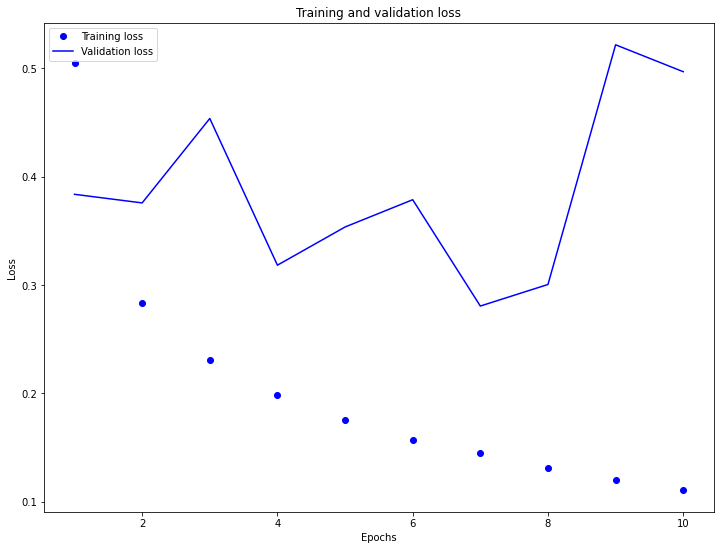

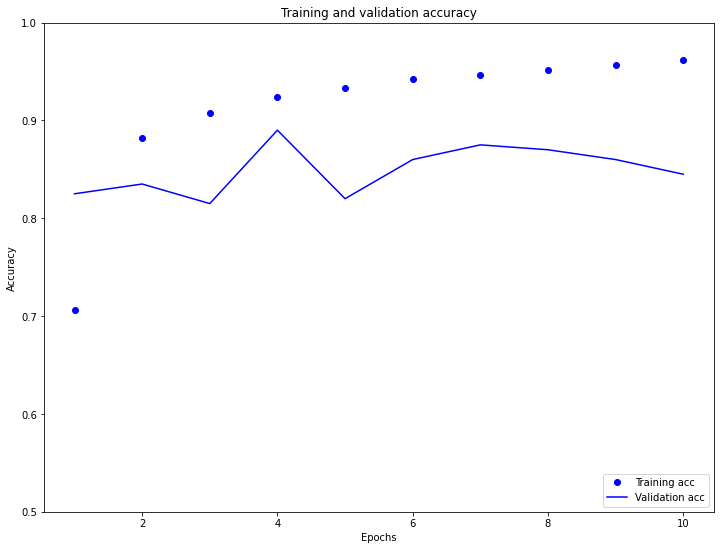

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`.

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in [Colaboratory](https://colab.research.google.com), you can use the following snippet to download these files to your local machine (or use the file browser, *View -> Table of contents -> File browser*).

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files we created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## Next steps


This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

* To learn about recurrent networks see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).

* To learn more about text classification (including the overall workflow, and if you're curious about when to use embeddings vs one-hot encodings) we recommend this practical text classification [guide](https://developers.google.com/machine-learning/guides/text-classification/step-2-5).